In [3]:
# Masters Thesis willem

import pypsa
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import glob
from dtw import *
import itertools

plt.style.use ("bmh")
from pprint import *
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)


    
#from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [132]:
# Willem Master's Thesis

import pypsa
import matplotlib.pyplot as plt
import math
import pandas as pd
import gc
import numpy as np
import pickle as pkl
import glob


def set_parameters_from_optimized(n, n_optim, ratio_wind, ratio_pv):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.

    CHANGE IN FUNCTION: wind power allocation esp. in the north was VERY weird. Therefore: Setting p_nom of wind generators
    to p_nom and NOT p_nom_opt
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    print("\n\n")
    print(ratio_wind)
    print(ratio_pv)
    
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
            np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
            n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)

    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False

    l_shedding = abs(n_optim.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(2).index.to_list()
    n.lines.loc[l_shedding, "s_max_pu"] = 0.80
    n.lines.loc[l_shedding, "num_parallel"] = 1

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    if not n.links.empty:
        links_dc_i = n.links.index[n.links.carrier == 'DC']
        n.links.loc[links_dc_i, 'p_nom'] = \
            n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
        n.links.loc[links_dc_i, 'p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)

    # Overwrite renewables with un-optimized capacities to approximate real life better
    gen_onwind = n.generators.index[n.generators.carrier == "onwind"]
    gen_offwind = n.generators.index[(n.generators.carrier == "offwind-ac") | (n.generators.carrier == "offwind-ac")]
    gen_solar = n.generators.index[n.generators.carrier == "solar"]
    # Overwrite onwind power values with p_nom * 0.2
    n.generators.loc[gen_onwind, 'p_nom'] = n_optim.generators['p_nom'].reindex(gen_onwind, fill_value=0.) * ratio_wind + 0.01
    # Overwrite offwind power values with p_nom_max * 0.1
    n.generators.loc[gen_offwind, 'p_nom'] = \
        n_optim.generators['p_nom_max'].reindex(gen_offwind, fill_value=0.) * 0.2 + 0.01
    # Overwrite solar power values with p_nom * 0.1
    n.generators.loc[gen_solar, 'p_nom'] = \
        n_optim.generators['p_nom'].reindex(gen_solar, fill_value=0.) * ratio_pv + 0.01
    
    display(n.generators[n.generators["carrier"] == "solar"].p_nom)
    display(n.generators[n.generators["carrier"] == "onwind"].p_nom)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    return n



def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)

    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0) / network.lines.s_nom)
    max_loading = (network.lines_t.p0 / network.lines.s_nom).max(axis=0)
    print(max_loading)

    # In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    # At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    # it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    # to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)


def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                              if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                            if "BESS" in name])



def add_BESS_load(network, network_year, start_hour, start_hour_0, c_rate, flex_potential, s_SOC_batteries):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    s_SOC_batteries: Series of battery SOCs from LAST hour of previous day. Dafault = empty pandas series (for first day)
    
    
    Sources: Alex paper, frontier study
    '''
    print("add_BESS_load")
    print(str(flex_potential) + "\n\n")

    # Flexibility potential
    
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads.copy()
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)
    p_mean_sum = df_loads["p_mean"].sum()
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        
        # determine flexibility at bus: Total flexibility at bus equals share of mean load of aggregate mean load
        df_load_bus = df_loads[df_loads["bus"] == bus_name]
        p_mean_bus = df_load_bus["p_mean"].iloc[0] if not df_load_bus.empty else 0
        flex_share = p_mean_bus / p_mean_sum
        p_flex = flex_potential * flex_share   
        
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus", name=battery_bus, x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, e_max_pu=1, e_initial= p_flex / c_rate * 0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link
        network.add("Link", name="BESS_{}_discharger".format(i + 1),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
        # charge link
        network.add("Link", name="BESS_{}_charger".format(i + 1),
                    bus0=bus_name, bus1=battery_bus, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries

        
def add_BESS_supply(network, network_year, start_hour, start_hour_0, c_rate, plant_potential, s_SOC_batteries):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the Powerplants allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    s_SOC_batteries: Series of battery SOCs from LAST hour of previous day. Dafault = empty pandas series (for first day)
    '''
    print("\n\nsupply\n\n")
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    # get bus names
    bus_names = network.buses.index.tolist()
    
    
    
    # Add supply side storage at power plants according to NDP goal
    # ----------------
    min_gen_size = 500
    
    # Total large scale plant capcity (generators > 500)
    df_gen = network_year.generators[["p_nom_max", "p_nom", "bus"]].copy()
    df_gen["flex_plant"] = df_gen["p_nom"].apply(lambda x: x if x > min_gen_size else 0)
    p_gen_sum = df_gen["flex_plant"].sum()
    
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        gen_battery_bus = "{}_{}".format(bus_name, "generator_BESS")
        
        # determine powerplant sided storage: share of generation capacity of generation capacity added as storage 
        # ONLY if generation cap exceeds threshhold -> NDP: Large scale generation shall have storage for RD
        # Adds flexibility for each generator if p_nom > 100 -> flexibility is then aggregated to one storage
        df_gen_bus = df_gen[df_gen["bus"] == bus_name]

        p_flex_plant = df_gen_bus["flex_plant"].sum()
        p_flex_plant = plant_potential * p_flex_plant/p_gen_sum
        
        if p_flex_plant > 0:
            # add additional bus for battery at location of previous bus
            network.add("Bus", name=gen_battery_bus, 
                        x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
            # add store
            network.add("Store", name="generator_BESS_{}".format(i), bus=gen_battery_bus,
                        e_nom=p_flex_plant / c_rate, 
                        e_nom_extendable=False, e_min_pu=0, e_max_pu=1, e_initial= p_flex_plant / c_rate * 0.5, e_cyclic=False,
                        p_set=p_flex_plant, 
                        q_set=0.05, marginal_cost=0,
                        capital_cost=0, standing_loss=0)
            # discharge link
            network.add("Link", name="generator_BESS_{}_discharger".format(i + 1),
                        bus0=gen_battery_bus, bus1=bus_name, capital_cost=0,
                        p_nom=p_flex_plant, 
                        p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost=0, efficiency=0.96)
            # charge link
            network.add("Link", name="generator_BESS_{}_charger".format(i + 1),
                        bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                        p_nom=p_flex_plant, 
                        p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost=0, efficiency=0.96)

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries
        
        
def add_BESS_all(network, network_year, start_hour, start_hour_0, c_rate, flex_potential, plant_potential, s_SOC_batteries):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    s_SOC_batteries: Series of battery SOCs from LAST hour of previous day. Dafault = empty pandas series (for first day)
    '''
    print("\n\nall\n\n")
    
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads.copy()
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)
    p_mean_sum = df_loads["p_mean"].sum()
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        
        # determine flexibility at bus: Total flexibility at bus equals share of mean load of aggregate mean load
        df_load_bus = df_loads[df_loads["bus"] == bus_name]
        p_mean_bus = df_load_bus["p_mean"].iloc[0] if not df_load_bus.empty else 0
        flex_share = p_mean_bus / p_mean_sum
        p_flex = flex_potential * flex_share   
        
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus", name=battery_bus, x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, e_max_pu=1, e_initial= p_flex / c_rate * 0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link
        network.add("Link", name="BESS_{}_discharger".format(i + 1),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
        # charge link
        network.add("Link", name="BESS_{}_charger".format(i + 1),
                    bus0=bus_name, bus1=battery_bus, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
    
    
    
    # Add supply side storage at power plants according to NDP goal
    # ----------------
    min_gen_size = 500
    
    # Total large scale plant capcity (generators > 500)
    df_gen = network_year.generators[["p_nom_max", "p_nom", "bus"]].copy()
    df_gen["flex_plant"] = df_gen["p_nom"].apply(lambda x: x if x > min_gen_size else 0)
    p_gen_sum = df_gen["flex_plant"].sum()
    
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        gen_battery_bus = "{}_{}".format(bus_name, "generator_BESS")
        
        # determine powerplant sided storage: share of generation capacity of generation capacity added as storage 
        # ONLY if generation cap exceeds threshhold -> NDP: Large scale generation shall have storage for RD
        # Adds flexibility for each generator if p_nom > 100 -> flexibility is then aggregated to one storage
        df_gen_bus = df_gen[df_gen["bus"] == bus_name]

        p_flex_plant = df_gen_bus["flex_plant"].sum()
        p_flex_plant = plant_potential * p_flex_plant/p_gen_sum
        
        if p_flex_plant > 0:
            # add additional bus for battery at location of previous bus
            network.add("Bus", name=gen_battery_bus, 
                        x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
            # add store
            network.add("Store", name="generator_BESS_{}".format(i), bus=gen_battery_bus,
                        e_nom=p_flex_plant / c_rate, 
                        e_nom_extendable=False, e_min_pu=0, e_max_pu=1, e_initial= p_flex_plant / c_rate * 0.5, e_cyclic=False,
                        p_set=p_flex_plant, 
                        q_set=0.05, marginal_cost=0,
                        capital_cost=0, standing_loss=0)
            # discharge link
            network.add("Link", name="generator_BESS_{}_discharger".format(i + 1),
                        bus0=gen_battery_bus, bus1=bus_name, capital_cost=0,
                        p_nom=p_flex_plant, 
                        p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost=0, efficiency=0.96)
            # charge link
            network.add("Link", name="generator_BESS_{}_charger".format(i + 1),
                        bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                        p_nom=p_flex_plant, 
                        p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost=0, efficiency=0.96)

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries


def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)    
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal", "lignite", "gas", "oil", "nuclear", "OCGT", "CCGT"]

    for generator in l_generators:
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name="{}_pos".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=network.generators.loc[generator]["marginal_cost"],
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=0,
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] -
                                                  network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
    # add load shedding
    bus_names = network_redispatch.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        # add load shedding generator at every bus
        network_redispatch.add("Generator",
                    name="load_{}".format(i + 1),
                    carrier = "load", 
                    bus = bus_name,
                    p_nom = 80000, # in pypsa-eur: 1*10^9 KW, marginal cost auch per kW angegeben
                    efficiency = 1,  
                    marginal_cost = 8000, # non zero marginal cost to ensure unique optimization result
                    capital_cost = 0,
                    p_nom_extendable = False,
                    p_nom_min = 0,
                    p_nom_max = math.inf)
        
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''
    mode = "default"
    network_dispatch = network.copy()

    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses

    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x", "y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name)  # save bus name, remove brackets & quotemarks
    else:
        # bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch


def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch = build_redispatch_network(network, network_dispatch)
    network_redispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")
    return network_redispatch


# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, start_hour, start_hour_0, 
                                      c_rate, storage_ops, flex_potential, plant_potential, s_SOC_batteries):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Param:
    network: network from dispatch optimization
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    if storage_ops == "load":
        add_BESS_load(network_redispatch_bat, network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate,
                      flex_potential = flex_potential, s_SOC_batteries = s_SOC_batteries)
    elif storage_ops == "supply":
        add_BESS_supply(network_redispatch_bat, network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate, 
                        plant_potential = plant_potential, s_SOC_batteries = s_SOC_batteries)
    elif storage_ops == "all":
        add_BESS_all(network_redispatch_bat, network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate, 
                     flex_potential = flex_potential, plant_potential = plant_potential, s_SOC_batteries = s_SOC_batteries)
    return network_redispatch_bat


def solve_redispatch_network_with_bat(network, network_dispatch, network_year, start_hour, start_hour_0, 
                                      c_rate, storage_ops, flex_potential, plant_potential, s_SOC_batteries):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, start_hour, start_hour_0, 
                                                               c_rate, storage_ops, flex_potential, plant_potential, s_SOC_batteries)
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

    return network_redispatch_bat


def concat_network(list_networks, ignore_standard_types=False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    # create new network out of first network of the list of identical networks
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                           override_components=override_components,
                           override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(
            ["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        df = component.df
        # drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)

    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        component_t = component.list_name + "_t"

        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                # each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t), attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis=0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)

    # catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw, attr, getattr(n_input, attr))

        # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj

    return nw


def redispatch_workflow(network, network_optim, c_rate, flex_potential, plant_potential, storage_ops, scenario, ratio_wind, ratio_pv):
    '''
    Function for executing the whole redispatch workflow.

    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    
    print("\n\nratio_wind: " + str(ratio_wind) + "\n\n")
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    start_hour_0 = 7848
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(n = network, n_optim = network_optim, ratio_wind = ratio_wind, ratio_pv = ratio_pv)
    print("redispatch_workflow")
    print(str(flex_potential) + "\n\n")

    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:, "capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(start_hour_0, start_hour_0+7*24, 24):

        # print(start_hour)
        n_24 = network.copy(snapshots=network.snapshots[start_hour:start_hour + 24])
        
        # start SOC of storage_units equals state of charge at last snapshot of previous day
        n_24.storage_units["cyclic_state_of_charge"] = False
        if start_hour != start_hour_0:
            n_24.storage_units["state_of_charge_initial"] = s_SOC_storage_units
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

        
############### CHANGED
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat" and start_hour == start_hour_0:
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, 
                                                             start_hour = start_hour, start_hour_0 = start_hour_0,
                                                             c_rate = c_rate, flex_potential = flex_potential, 
                                                             plant_potential = plant_potential, storage_ops = storage_ops, 
                                                             s_SOC_batteries=pd.Series([]))
        elif scenario == "bat" and start_hour != start_hour_0:
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, 
                                                             start_hour = start_hour, start_hour_0 = start_hour_0,
                                                             c_rate = c_rate, flex_potential = flex_potential, 
                                                             plant_potential = plant_potential, storage_ops = storage_ops, 
                                                             s_SOC_batteries = s_SOC_batteries)
############### CHANGED ENDE
        display(n_redispatch.stores)

        # Initialize series for passing the 24th snapshot SOC value to next day network
        # ---------------
        s_SOC_storage_units = n_redispatch.storage_units_t.state_of_charge.iloc[-1].copy()
        if scenario == "bat":
            s_SOC_batteries = n_redispatch.stores_t.e.iloc[-1].copy()
            # TEST DONE: SEAMLESS STORAGE WORKS!!
        
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)

    # For each results list: Create a network out of daily networks for dispatch & redispatch
    # ---------------
    network_dispatch = concat_network(l_networks_dispatch)
    network_redispatch = concat_network(l_networks_redispatch)

    return network_dispatch, network_redispatch





def solve_redispatch_workflow(c_rate=0.25):
    """
    Function to run the redispatch workflow for one network in the networks_redispatch folder.
    Used to compare bat and no bat scenario for a single network.
    """

    # folder = r'/cluster/home/wlaumen/Euler/pypsa-eur/networks_redispatch'
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    filename = "elec_s300_200_ec_lcopt_1H-noex"
    

    
    
    
    # path_n = folder + "/" + filename + ".nc"
    # path_n_optim = folder + "/solved/" + filename + ".nc"

    path_n = folder + "\\" + filename + ".nc"
    path_n_optim = folder + "\solved\\" + filename + ".nc"

    # Define network and network_optim
    n = pypsa.Network(path_n)
    n_optim = pypsa.Network(path_n_optim)
    n.plot()
    ###

    scenario_year = 2018 # 2025, 2030
    ### SCENARIO YEAR WILL BE SOLVED IN DIFFERENT .py file

    
    # Scenario parameters
    storage_ops = "all"
    flex_potential = 300
    plant_potential = 100


    # Run redispatch with batteries & export files
    n_d, n_rd = redispatch_workflow(network = n, network_optim = n_optim, storage_ops= storage_ops,
                                                  flex_potential = flex_potential, 
                                                  plant_potential = plant_potential, scenario="no bat",  c_rate=c_rate,
                                                  ratio_wind = 1, ratio_pv = 0.9)
    
    n_d2, n_rd2 = redispatch_workflow(network = n, network_optim = n_optim, storage_ops= storage_ops,
                                                  flex_potential = flex_potential, 
                                                  plant_potential = plant_potential, scenario="no bat",  c_rate=c_rate,
                                                  ratio_wind = 2.54, ratio_pv = 1.38)
    gc.collect()

    
    # return statement to be excluded from cluster script
    return n_d, n_rd, n_d2, n_rd2



In [ ]:
# n_200_d, n_200_rd, 
n_d, n_rd, n_d2, n_rd2 = solve_redispatch_workflow()

INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units




ratio_wind: 1





1
0.9


name
DE0 0 solar      109.020267
DE0 1 solar      129.018606
DE0 10 solar     133.528537
DE0 100 solar    203.620484
DE0 101 solar    154.816524
                    ...    
DE0 95 solar      94.132005
DE0 96 solar     253.241369
DE0 97 solar     312.532539
DE0 98 solar      79.781707
DE0 99 solar     171.836636
Name: p_nom, Length: 193, dtype: float64

name
DE0 0 onwind        0.0146
DE0 1 onwind      116.9900
DE0 10 onwind      98.3500
DE0 100 onwind    132.0160
DE0 101 onwind     96.6854
                    ...   
DE0 95 onwind      15.0115
DE0 96 onwind      49.3960
DE0 97 onwind       4.0110
DE0 98 onwind      12.6100
DE0 99 onwind     136.2903
Name: p_nom, Length: 193, dtype: float64

redispatch_workflow
300




INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-j9k6lin1.lp
Reading time = 0.54 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0xad4488a7
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21807 columns
Presolve time: 0.13s
Presolved: 4032 rows, 5050 columns, 24829 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xupobfjy.lp
Reading time = 1.00 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0xd5b12cac
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108483 rows and 27956 columns
Presolve time: 0.19s
Presolved: 7365 rows, 26333 columns, 57108 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.331e+04
 Factor NZ  : 1.542e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.789e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e+05


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.71s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-p8wmojom.lp
Reading time = 0.27 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0xc4e95bee
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21811 columns
Presolve time: 0.08s
Presolved: 4032 rows, 5046 columns, 24825 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ijfg50gi.lp
Reading time = 0.65 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0xa192b048
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108488 rows and 28245 columns
Presolve time: 0.17s
Presolved: 7360 rows, 26044 columns, 56825 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.327e+04
 Factor NZ  : 1.540e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.782e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e+05


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-9l9z7o9d.lp
Reading time = 0.55 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0x5d4c28b3
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [2e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21802 columns
Presolve time: 0.10s
Presolved: 4032 rows, 5055 columns, 24834 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-sqcam1ss.lp
Reading time = 1.00 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0xcd9a92a3
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [2e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108482 rows and 26934 columns
Presolve time: 0.19s
Presolved: 7366 rows, 27355 columns, 58139 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.347e+04
 Factor NZ  : 1.540e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.781e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 9.36e+06


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.68s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-6zusvmus.lp
Reading time = 0.26 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0x5408e7a9
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56954 rows and 21804 columns
Presolve time: 0.07s
Presolved: 4030 rows, 5053 columns, 24830 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.872e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-m2yvp_qm.lp
Reading time = 0.64 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0x929996d1
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108488 rows and 28518 columns
Presolve time: 0.23s
Presolved: 7360 rows, 25771 columns, 56576 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.339e+04
 Factor NZ  : 1.546e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.901e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 9.20e+06


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.72s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-52wa1n8h.lp
Reading time = 0.28 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0x63877679
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [2e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56956 rows and 21812 columns
Presolve time: 0.07s
Presolved: 4028 rows, 5045 columns, 24820 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.888e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.346e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.45e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-i24wb749.lp
Reading time = 0.50 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0x4671f044
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [2e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108484 rows and 27095 columns
Presolve time: 0.12s
Presolved: 7364 rows, 27194 columns, 57968 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.343e+04
 Factor NZ  : 1.547e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.898e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 6.50e+06


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-r_4a78b9.lp
Reading time = 0.29 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0x3d5808e9
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-04, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56955 rows and 21810 columns
Presolve time: 0.08s
Presolved: 4029 rows, 5047 columns, 24823 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-wa615tv2.lp
Reading time = 0.51 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0x99af6146
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-04, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108483 rows and 27210 columns
Presolve time: 0.12s
Presolved: 7365 rows, 27079 columns, 57855 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.342e+04
 Factor NZ  : 1.547e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.903e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 6.75e+06


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-rymvvdij.lp
Reading time = 0.54 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0x5ac13dc3
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-04, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21804 columns
Presolve time: 0.14s
Presolved: 4032 rows, 5053 columns, 24832 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.40e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-5_vk_7nf.lp
Reading time = 0.93 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0x2ee449fe
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-04, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108480 rows and 27164 columns
Presolve time: 0.23s
Presolved: 7368 rows, 27125 columns, 57903 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.343e+04
 Factor NZ  : 1.541e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.782e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+07


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []



ratio_wind: 2.54





2.54
1.38


name
DE0 0 solar      167.159076
DE0 1 solar      197.823196
DE0 10 solar     204.738423
DE0 100 solar    312.212742
DE0 101 solar    237.380004
                    ...    
DE0 95 solar     144.330408
DE0 96 solar     388.298099
DE0 97 solar     479.211226
DE0 98 solar     122.326617
DE0 99 solar     263.477508
Name: p_nom, Length: 193, dtype: float64

name
DE0 0 onwind        0.021684
DE0 1 onwind      297.139200
DE0 10 onwind     249.793600
DE0 100 onwind    335.305240
DE0 101 onwind    245.565516
                     ...    
DE0 95 onwind      38.113810
DE0 96 onwind     125.450440
DE0 97 onwind      10.172540
DE0 98 onwind      32.014000
DE0 99 onwind     346.161962
Name: p_nom, Length: 193, dtype: float64

redispatch_workflow
300




INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.72s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-d3wj0f_m.lp
Reading time = 0.52 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0xad983409
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21807 columns
Presolve time: 0.15s
Presolved: 4032 rows, 5050 columns, 24829 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-axiqp0zq.lp
Reading time = 0.50 seconds
obj: 115848 rows, 54289 columns, 193275 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 115848 rows, 54289 columns and 193275 nonzeros
Model fingerprint: 0xd950c8d6
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 8e+03]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 108483 rows and 28025 columns
Presolve time: 0.17s
Presolved: 7365 rows, 26264 columns, 57042 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.327e+04
 Factor NZ  : 1.542e+05 (roughly 15 MBytes of memory)
 Factor Ops : 4.789e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                R

INFO:pypsa.linopf:Optimization successful. Objective value: 5.49e+05


Empty DataFrame
Columns: [bus, type, e_nom, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_cyclic, p_set, q_set, sign, marginal_cost, capital_cost, standing_loss, e_nom_opt]
Index: []

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-qd7pxdgs.lp
Reading time = 0.28 seconds
obj: 60984 rows, 26857 columns, 110979 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60984 rows, 26857 columns and 110979 nonzeros
Model fingerprint: 0xe1280935
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+00, 1e+01]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56952 rows and 21809 columns
Presolve time: 0.08s
Presolved: 4032 rows, 5048 columns, 24827 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.060e+04
 Factor NZ  : 6.871e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.338e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residu

INFO:pypsa.linopf:Optimization successful. Objective value: 1.84e+07


In [ ]:
print(n_d.objective)
print(n_rd.objective)
display(n_d.generators)
display(n_rd.generators_t.p)

display(n_d.generators[n_d.generators["carrier"]=="onwind"]["p_nom"])

print(n_d2.objective)
print(n_rd2.objective)
display(n_rd2.generators_t.p)

display(n_d2.generators[n_d.generators["carrier"]=="onwind"]["p_nom"])

In [69]:
#### ACTUAL RENEWABLE CAPACITY FROM NDP ####

n_base = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300.nc")
cap = n_base.generators.groupby("carrier")["p_nom"].sum()
ratio_wind = 50500 / cap.loc["onwind"]
ratio_pv = 43400 / cap.loc["solar"]


display(ratio_wind)
display(ratio_pv)

INFO:pypsa.io:Imported network elec_s300.nc has buses, carriers, generators, lines, links, loads, storage_units


2.5379643040092015

1.3802403490956292

name      2018-11-24 00:00:00  2018-11-24 01:00:00  2018-11-24 02:00:00  \
BESS_0               5.644092             5.644092         0.000000e+00   
BESS_1               2.020384             2.020384        -8.081536e-02   
BESS_2               3.108734             3.108734         0.000000e+00   
BESS_3               1.931843             1.931843        -7.727272e-02   
BESS_4               4.864365             4.864365         1.000000e-06   
...                       ...                  ...                  ...   
BESS_195             6.184886             6.184886        -2.473954e-01   
BESS_196            -2.351578            -2.351578         2.449560e+00   
BESS_197             0.000000            -0.209163         2.614553e+00   
BESS_198             0.670213             0.670213        -2.680752e-02   
BESS_199             3.867504             3.867504        -1.546992e-01   

name      2018-11-24 03:00:00  2018-11-24 04:00:00  2018-11-24 05:00:00  \
BESS_0               0.000000             0.000000            -0.225764   
BESS_1              -1.939569             2.020384             0.000000   
BESS_2              -2.649631             2.649632            -2.984385   
BESS_3              -1.854569             0.000000             1.931843   
BESS_4               0.000000             0.000000            -4.669790   
...                       ...                  ...                  ...   
BESS_195            -5.937491             6.184886             0.000000   
BESS_196             2.449560            -2.351578             0.000000   
BESS_197             0.000000            -2.509971             0.000000   
BESS_198            -0.643404             0.670213            -0.643404   
BESS_199            -3.712804             3.867504             0.000000   

name      2018-11-24 06:00:00  2018-11-24 07:00:00  2018-11-24 08:00:00  \
BESS_0              -5.418328             0.000000             0.000000   
BESS_1              -1.939569             1.939569             0.000000   
BESS_2              -0.124349             0.000000             0.000000   
BESS_3              -1.854569             1.854569             0.000000   
BESS_4              -0.778298             0.000000             0.000000   
...                       ...                  ...                  ...   
BESS_195            -5.937491             0.000000             5.442700   
BESS_196            -0.293948             2.449560             2.449560   
BESS_197            -2.509971             2.614553             2.614553   
BESS_198             0.000000             0.000000             0.000000   
BESS_199            -3.712804             3.712804             0.000000   

name      2018-11-24 09:00:00  2018-11-24 10:00:00  2018-11-24 11:00:00  \
BESS_0               0.000000             0.000000             5.644092   
BESS_1               0.000000            -0.161631            -1.939569   
BESS_2               0.000000             0.000000             3.108734   
BESS_3               0.000000            -1.854569            -1.854569   
BESS_4               0.000000             0.000000             4.864365   
...                       ...                  ...                  ...   
BESS_195             0.000000            -5.937491             6.184886   
BESS_196             2.449560             0.000000            -2.351578   
BESS_197             2.614553             0.000000            -2.509971   
BESS_198             0.000000            -0.080426             0.670213   
BESS_199             0.000000             0.000000            -3.712804   

name      2018-11-24 12:00:00  2018-11-24 13:00:00  2018-11-24 14:00:00  \
BESS_0              -5.418328             0.000000            -5.418328   
BESS_1              -1.939569             2.020384             2.020384   
BESS_2              -2.984385             0.000000            -2.984385   
BESS_3              -0.154547             1.931843             1.931843   
BESS_4              -

name    2018-11-24 00:00:00  2018-11-24 01:00:00  2018-11-24 02:00:00  \
BESS_5             3.529712         0.000000e+00             0.000000   
BESS_6             1.562382         0.000000e+00             0.062495   
BESS_7             3.415562         0.000000e+00             0.000000   
BESS_8             1.976062        -1.000000e-06             0.079043   
BESS_9             7.514372         9.951466e+00             7.412827   

name    2018-11-24 03:00:00  2018-11-24 04:00:00  2018-11-24 05:00:00  \
BESS_5             0.000000             0.000000             3.388524   
BESS_6             1.562382             0.000000             0.000000   
BESS_7             0.000000             0.000000             3.278940   
BESS_8             1.976063             0.000000             0.000000   
BESS_9             4.874188             7.311281             7.311281   

name    2018-11-24 06:00:00  2018-11-24 07:00:00  2018-11-24 08:00:00  \
BESS_5             6.777047             6.777047             3.529712   
BESS_6             1.499887             0.000000             0.000000   
BESS_7             6.557879             6.557879             3.142317   
BESS_8             1.897020             0.000000             0.000000   
BESS_9             7.615917             5.077278             2.538639   

name    2018-11-24 09:00:00  2018-11-24 10:00:00  2018-11-24 11:00:00  \
BESS_5             3.529712             3.529712             0.000000   
BESS_6             0.000000             1.499887             2.999773   
BESS_7             3.142317             3.142317             0.000000   
BESS_8             0.000000             0.000000             1.897020   
BESS_9             0.000000             0.000000             2.437093   

name    2018-11-24 12:00:00  2018-11-24 13:00:00  2018-11-24 14:00:00  \
BESS_5             3.388524             6.777047            10.165571   
BESS_6             3.124764             1.562382             0.000000   
BESS_7             3.278940             6.557879             9.836819   
BESS_8             0.079043             1.976063             0.000000   
BESS_9             0.203091             2.640185             2.640185   

name    2018-11-24 15:00:00  2018-11-24 16:00:00  2018-11-24 17:00:00  \
BESS_5            10.165571             6.635859             3.529712   
BESS_6             1.499887             2.999773             4.499660   
BESS_7             9.836819             6.421257             3.415562   
BESS_8             1.897020             3.794041             5.691061   
BESS_9             2.640185             5.077278             2.538639   

name    2018-11-24 18:00:00  2018-11-24 19:00:00  2018-11-24 20:00:00  \
BESS_5             0.000000             0.000000             0.000000   
BESS_6             5.999547             4.437165             2.874783   
BESS_7             0.000000             0.000000             0.000000   
BESS_8             5.928189             3.952126             1.976063   
BESS_9             0.000000             2.437093             0.101546   

name    2018-11-24 21:00:00  2018-11-24 22:00:00  2018-11-24 23:00:00  \
BESS_5             3.388524                  0.0                  0.0   
BESS_6             1.562382                  0.0                  0.0   
BESS_7             3.278940                  0.0                  0.0   
BESS_8             1.976063                  0.0                  0.0   
BESS_9             2.538639                  0.0                  0.0   

name    2018-11-25 00:00:00  2018-11-25 01:00:00  2018-11-25 02:00:00  \
BESS_5             0.000000             0.000000             0.000000   
BESS_6             1.499887             1.499887             1.499887   
BESS_7             0.000000             0.000000             0.000000   
BESS_8             1.897020             1.897020             1.897020   
BESS_9             0.000000             0.000000             2.437093   

name    2018-11-25 03:00:00  2018-11-25 04:00:00 

<AxesSubplot:xlabel='name'>

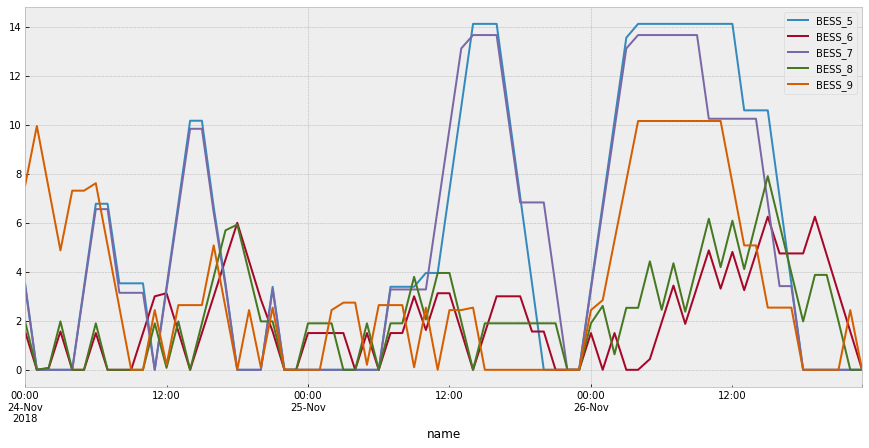

In [67]:
# Test for storage: SEAMLESS STORAGE
#n_200_rd_bat.stores_t.e.plot(figsize=(20,5))
display(n_200_rd_bat.stores_t.p.T)

n_200_rd_bat.stores.e_initial
display(n_200_rd_bat.stores_t.e.iloc[:,5:10].T)

# <u> Analysis of Pypsa-eur networks <u>

# <b> Analyze redispatch costs manually per day <b>

In [33]:
# import functions to load the network 
def load_networks(import_path, filename):
    network_d = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    network_rd = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    network_rd_bat4h = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_4h.nc")
    network_rd_bat8h = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_8h.nc")
    network_rd_bat12h = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_12h.nc")
    return network_d, network_rd, network_rd_bat4h, network_rd_bat8h, network_rd_bat12h

network_d, network_rd, network_rd_bat4h, network_rd_bat8h, network_rd_bat12h = \
load_networks(import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results", filename = r"elec_s300_200_ec_lcopt_1H-noex")


INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex_bat_4h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex_bat_8h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex_bat_12h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [5]:
# Manual objective analysis -> redispatch cost reduction
# ---------------------

def analyze_objective(network_rd, network_rd_bat):
    # Calculate the hourly realized redispatch cost for every generator 
    print(network_rd.objective)
    print(network_rd_bat.objective)
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    cols_rd_b = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd_b]
    
    # positive redispatch cost
    d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()
    df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
    df_ramp_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "pos" in column]]
    for col in list(df_ramp):
        df_ramp.loc[:,col] = df_ramp[col] * d_marg_cost[col]
        df_ramp_bat.loc[:,col] = df_ramp_bat [col] * d_marg_cost[col]
    df_ramp_cost = df_ramp.copy()
    df_ramp_cost_bat = df_ramp_bat.copy()
    df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
    df_ramp_cost_bat["sum_ramp_cost_bat"] = df_ramp_cost_bat.sum(axis = 1)

    # negative redispatch cost
    df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
    df_marginal_cost_bat = network_rd_bat.generators_t.marginal_cost.round(2)
    df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
    df_curtail_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "neg" in column]]
    df_curtail_cost = df_curtail * df_marginal_cost
    df_curtail_cost_bat = df_curtail_bat * df_marginal_cost_bat
    # add sums
    df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)
    df_curtail_cost_bat["sum_curtailment_cost_bat"] = df_curtail_cost_bat.sum(axis = 1)
    
    # df for comparison bat vs. no bat
    df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"], df_curtail_cost_bat["sum_curtailment_cost_bat"],
                                  df_ramp_cost["sum_ramp_cost"], df_ramp_cost_bat["sum_ramp_cost_bat"]], axis = 1)
    df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"]
    df_obj["redispatch_cost_bat"] = df_obj["sum_curtailment_cost_bat"] + df_obj["sum_ramp_cost_bat"]
    df_obj["delta_ramp_cost"] = df_obj["sum_ramp_cost_bat"] - df_obj["sum_ramp_cost"]
    df_obj["delta_curtailment_cost"] = df_obj["sum_curtailment_cost_bat"].round(2) - \
                                                 df_obj["sum_curtailment_cost"].round(2)
    df_obj["delta_rd_cost"] = df_obj["delta_curtailment_cost"] + df_obj["delta_ramp_cost"]
    df_obj["delta_rd_cost_rel"] = df_obj["delta_rd_cost"] / df_obj["redispatch_cost"]

    # create dataframe for DAILY redispatch 
    df_obj_day = df_obj.iloc[:,:-1].groupby(np.arange(len(df_obj))//24).sum()
    df_obj_day["delta_rd_cost_rel"] = df_obj_day["delta_rd_cost"] / df_obj_day["redispatch_cost"]

    df_obj_day.index.rename("Time horizon (day)", inplace = True)

    # create dataframe for WEEKLY redispatch
    df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
    df_obj_week.index.rename("Time horizon (week)", inplace = True)
    return df_obj, df_obj_day, df_obj_week


def analyze_objective_rd(network_rd):
    # Calculate the hourly realized redispatch cost for every generator 
    print(network_rd.objective)
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd]
    # positive redispatch cost
    d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()
    df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
    for col in list(df_ramp):
        df_ramp.loc[:,col] = df_ramp[col] * d_marg_cost[col]
    df_ramp_cost = df_ramp.copy()
    df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
    # negative redispatch cost
    df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
    df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
    df_curtail_cost = df_curtail * df_marginal_cost
    # add sums
    df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)
    # df for comparison between different redispatch networks
    df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"], df_ramp_cost["sum_ramp_cost"]], axis = 1)
    df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"]
    # create dataframe for DAILY redispatch 
    df_obj_day = df_obj.groupby(np.arange(len(df_obj))//24).sum()
    df_obj_day.index.rename("Time horizon (day)", inplace = True)
    # create dataframe for WEEKLY redispatch
    df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
    df_obj_week.index.rename("Time horizon (week)", inplace = True)
    return df_obj, df_obj_day, df_obj_week

# Plot MANUAL objective insights
# --------------

def plot_objective_analysis(df_obj, df_obj_day, df_obj_week):
    """
    Function to plot objective analysis insights
    """

    colors = ["royalblue","navy","lightgreen"]

    # Redispatch cost difference per day
    cols = ["redispatch_cost","redispatch_cost_bat"]
    fig, ax  = plt.subplots(figsize = (20, 5))
    ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 2, fontsize = 12)
    df_obj_day["delta_rd_cost"].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                       color = "lightgreen", legend = True, linewidth = 2.5, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Redispatch cost difference per week
    cols = ["redispatch_cost","redispatch_cost_bat"]
    fig, ax1  = plt.subplots(figsize = (20, 5))
    ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax1.set_xlabel("Time horizon (week)", fontsize = 12)
    ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 2.5, fontsize = 12)
    df_obj_week["delta_rd_cost"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                       color = "lightgreen", legend = True, width = 0.4, fontsize = 12)
    ax1.set_facecolor('white')
    ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
    ax1.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Relative redispatch cost savings vs absolute savings
    fig, ax2  = plt.subplots(figsize = (20, 5))
    ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
    ax2.set_xlabel("Time horizon (day)", fontsize = 12)
    ax2 = df_obj_day["delta_rd_cost"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                       color = ["lightgreen"], legend = True, fontsize = 12)
    ax2.set_facecolor('white')
    ax2.legend(loc = "upper left")
    ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
    ax2.set_axisbelow(True)

    # TODO: REMOVE GRAPH OFFSET
    
    ax2_ = ax2.twinx()
    abs(df_obj_day["delta_rd_cost_rel"]).abs().plot.line(ax = ax2_, linewidth = 1.2, 
                                               color = "crimson", legend = True, fontsize = 12)
    ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
    #ax2_.set_ylim(0,1.0)
    fig.tight_layout()
    plt.show()
    
    
# Reduction of redispatch energy (positive and negative)
# ---------------

def analyze_dynamic_time_warping(network_rd, network_rd_bat, df_obj, df_obj_day):
    """
    Function to analyze total change in redispatch, curtailment, ramp up energy.
    Function to map time series distance between redispatch energy time series and time series of biggest 
    redispatch cost savings -> map correlation.
    """
    # Redispatch power dataframe
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
    df_rd_p = network_rd.generators_t.p[cols_rd]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
    # sum of positive redispatch
    cols_pos = [column for column in list(df_rd_p) if "pos" in column]
    df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
    df_rd_p_bat["Positive redispatch bat"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
    # sum of negative redispatch
    cols_neg = [column for column in list(df_rd_p_bat) if "neg" in column]
    df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
    df_rd_p_bat["Negative redispatch bat"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)

    # Difference of redispatch (pos/neg) and total redispatch datarame
    df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                                 df_rd_p_bat[["Negative redispatch bat", "Positive redispatch bat"]]], 
                                axis = 1)

    # differences in redispatch bat vs no bat
    df_bat_nobat = df_bat_nobat.round(2)
    # diff curtailment: old - new => so that + = more curtailment & - = less curtialment
    df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,0] - df_bat_nobat.iloc[:,2]
    df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
    df_bat_nobat["Total redispatch"] = abs(df_bat_nobat["Negative redispatch"]) + abs(df_bat_nobat["Positive redispatch"])
    df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat["Negative redispatch bat"]) + abs(df_bat_nobat["Positive redispatch bat"])
    df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
    df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
    df_bat_nobat = df_bat_nobat.append(df_bat_nobat.sum(axis = 0), ignore_index = True)

    # Create daily dataframe 
    df_bat_nobat_day = df_bat_nobat.iloc[:-1].groupby(np.arange(len(df_obj))//24).sum()
    df_bat_nobat_day.index.rename("Time horizon (day)", inplace = True)
    display(df_bat_nobat_day)

    # Analyze: are the days of most cost reduction also the days of most redispatch power in the no_bat scenario?
    # --------------

    def get_dtw_diff_matrix(cols:list, df_dtw):
        """
        From a list of column names referring to a pandas dataframe with series as columns, compute a distance matrix by computing the 
        DTW distance of all pairwise combinations of series. I take the column names as input so it does reduce the complexity when indexing.
        """
        diff_matrix = {}
        cross = itertools.product(cols, cols)
        for (col1, col2) in cross:
            series1 = df_dtw[col1]
            series2 = df_dtw[col2]
            #print(series1,series2)
            # measure difference dtw
            diff = dtw(series1, 
                       series2, 
                       keep_internals=True, 
                       step_pattern=rabinerJuangStepPattern(2, "c")).normalizedDistance
            diff_matrix[(col1 , col2)] = [diff]
        # convert to pandas dataframe    
        dtw_diff_df = pd.DataFrame(diff_matrix).T.reset_index()\
          .rename(columns = {"level_0":"Delta_obj_day", "level_1":"Total redispatch", 0:"diff"})\
          .pivot_table(index = "Delta_obj_day", columns = "Total redispatch", values = "diff")
        return dtw_diff_df

    # Create dtw dataframe for comparison of redispatch cost savings and total redispatch energy in nobat scenario
    df_dtw = pd.concat([df_bat_nobat_day["Total redispatch"], - df_obj_day["delta_rd_cost"]], axis = 1).round(2)
    df_dtw[df_dtw == -0.0] = 0
    scaler = MinMaxScaler()
    df_dtw[["Total redispatch","delta_rd_cost"]] = scaler.fit_transform(df_dtw[["Total redispatch","delta_rd_cost"]])
    # distance object
    dtw_diff = dtw(df_dtw.iloc[-40:, 0], df_dtw.iloc[-40:, 1], keep_internals=True, 
                   step_pattern=rabinerJuangStepPattern(2, "b"))
    # Distance matrix
    dtw_diff_df = get_dtw_diff_matrix(list(df_dtw), df_dtw)
    display(dtw_diff_df)
    return df_bat_nobat, df_bat_nobat_day, dtw_diff

    # WHy dynamic time warping? Because dtw can not only identify direct euclidian similarities for every point but also determine wheather
    # two time series have a similar trend (which is just zeitversetzt), e.g. a very high total redispatch in t = T is usually followed by 
    # a large delta_rd_costs every t = T + 2. Euclidian distance would measure no similarity here!
    
    # Plots of objective and redispatch power reduction
# ------------

def plot_energy_dynamic_time_warping(df_bat_nobat, df_bat_nobat_day, dtw_diff):
    colors = ["royalblue","navy"]
    
    # Dynamic time warping distance between cost difference per day (examplary)
    ax = dtw_diff.plot(type="twoway")
    ax = dtw_diff.plot(type="twoway", offset = -0.5)

    # Negative and positive redispatch w/o bat
    cols = ["Negative redispatch","Positive redispatch"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Negative and positive redispatch WITH bat
    cols = ["Negative redispatch bat","Positive redispatch bat"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot difference in curtailment energy bat vs nobat
    cols = ["Difference in curtailment"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Hourly difference in curtailment power (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].where(df_bat_nobat_day[cols].ge(0), 0)\
                               .plot.line(stacked = False, ax = ax, title = "Difference in curtailment energy", 
                                          color = "red", legend = True, linewidth = 1, fontsize = 12)
    df_bat_nobat_day[cols].where(df_bat_nobat_day[cols].lt(0), 0).plot.line(ax = ax, color = "green", linewidth = 0.8)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
# Map the change in merit order
# ------------------

def plot_merit_order(s_dispatch_p_t, s_merit, s_redispatch_p_t, colorarray=["blue","green"]):
    '''
    Plots merit order curve as step function.
    -----
    Param:
    s_dispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_redispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_merit: series with marginal generator prices
    '''
    if s_dispatch_p_t["oil"].sum() == 0:
        np_x = np.cumsum(s_dispatch_p_t.iloc[:-2].to_numpy())
    else:
        np_x = np.cumsum(s_dispatch_p_t.iloc[:-1].to_numpy())
    
    if s_redispatch_p_t["oil"].sum() == 0:
        np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-2].to_numpy())
    else: 
        np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-1].to_numpy())
    
    if s_dispatch_p_t["oil"].sum() == 0 and s_dispatch_p_t["oil"].sum() == 0:
        np_y = s_merit.iloc[:-2].to_numpy()
    else:
        np_y = s_merit.iloc[:-1].to_numpy()
    
    # Plot merit order of dispatch & redispatch
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.step(np_x, np_y, color = colorarray[0], linewidth = 1.2)
    ax.step(np_x2, np_y, color = colorarray[1], linewidth = 1.2)
    ax.set_ylabel('Marginal generation price (€)',  fontsize = 12)
    ax.set_xlabel("Dispatched power (MW)", fontsize = 12)
    ax.set_title("Shift in power plant dispatch from merit order to post-redispatch",  fontsize = 14)
    ax.set_facecolor('white')
    ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()
    plt.show()

def analyze_and_plot_merit_order_shift(network_d, network_rd, network_rd_bat, df_obj):
    # Generate Merit order per day
    df_gen = network_d.generators.copy()
    dict_prices = df_gen.groupby(["carrier"]).mean()["marginal_cost"].round(4).to_dict()
    dict_prices["offwind"] = dict_prices.pop("offwind-ac")
    dict_prices.pop("offwind-dc")
    for key in dict_prices:
        if dict_prices[key] == 0:
            dict_prices.update({key: 0.01})
    pprint(dict_prices)

    # Create dataframe with dispatch by carrier
    df_dispatch = network_d.generators_t.p.copy()
    cols_CCGT = [column for column in list(df_dispatch) if "CCGT" in column]
    cols_OCGT = [column for column in list(df_dispatch) if "OCGT" in column]
    cols_oil = [column for column in list(df_dispatch) if "oil" in column]
    cols_lignite = [column for column in list(df_dispatch) if "lignite" in column]
    cols_nuclear = [column for column in list(df_dispatch) if "nuclear" in column]
    cols_coal = [column for column in list(df_dispatch) if "coal" in column]
    cols_biomass = [column for column in list(df_dispatch) if "biomass" in column]
    cols_offwind = [column for column in list(df_dispatch) if "offwind" in column]
    cols_onwind = [column for column in list(df_dispatch) if "onwind" in column]
    cols_solar = [column for column in list(df_dispatch) if "solar" in column]
    cols_runofriver = [column for column in list(df_dispatch) if "ror" in column]

    df_dispatch["OCGT"] = df_dispatch[cols_OCGT].sum(axis = 1)
    df_dispatch["CCGT"] = df_dispatch[cols_CCGT].sum(axis = 1)
    df_dispatch["oil"] = df_dispatch[cols_oil].sum(axis = 1)
    df_dispatch["lignite"] = df_dispatch[cols_lignite].sum(axis = 1)
    df_dispatch["nuclear"] = df_dispatch[cols_nuclear].sum(axis = 1)
    df_dispatch["coal"] = df_dispatch[cols_coal].sum(axis = 1)
    df_dispatch["biomass"] = df_dispatch[cols_biomass].sum(axis = 1)
    df_dispatch["offwind"] = df_dispatch[cols_offwind].sum(axis = 1)
    df_dispatch["onwind"] = df_dispatch[cols_onwind].sum(axis = 1)
    df_dispatch["solar"] = df_dispatch[cols_solar].sum(axis = 1)
    df_dispatch["ror"] = df_dispatch[cols_runofriver].sum(axis = 1)
    df_merit = df_dispatch.loc[:,"OCGT":"ror"]

    # Map Marginal prices and sort dataframe for merit order
    df_merit = df_merit.T.round(4)
    df_merit['Marginal price'] = df_merit.index.map(dict_prices)
    df_merit = df_merit.sort_values(by = "Marginal price", axis = 0)
    df_merit = df_merit.T
    # Control sum
    df_merit["sum"] = df_merit.sum(axis = 1)

    # Generate Merit order AFTER REDISPATCH
    df_redis = network_rd.generators_t.p.copy()
    cols_CCGT =    [column for column in list(df_redis) if "CCGT" in column]
    cols_OCGT =    [column for column in list(df_redis) if "OCGT" in column]
    cols_oil =     [column for column in list(df_redis) if "oil" in column]
    cols_lignite = [column for column in list(df_redis) if "lignite" in column]
    cols_nuclear = [column for column in list(df_redis) if "nuclear" in column]
    cols_coal =    [column for column in list(df_redis) if "coal" in column]
    cols_biomass = [column for column in list(df_redis) if "biomass" in column]
    cols_offwind = [column for column in list(df_redis) if "offwind" in column]
    cols_onwind =  [column for column in list(df_redis) if "onwind" in column]
    cols_solar =   [column for column in list(df_redis) if "solar" in column]
    cols_runofriver = [column for column in list(df_redis) if "ror" in column]
    df_redis["OCGT"] =    df_redis[cols_OCGT].sum(axis = 1)
    df_redis["CCGT"] =    df_redis[cols_CCGT].sum(axis = 1)
    df_redis["oil"] =     df_redis[cols_oil].sum(axis = 1)
    df_redis["lignite"] = df_redis[cols_lignite].sum(axis = 1)
    df_redis["nuclear"] = df_redis[cols_nuclear].sum(axis = 1)
    df_redis["coal"] =    df_redis[cols_coal].sum(axis = 1)
    df_redis["biomass"] = df_redis[cols_biomass].sum(axis = 1)
    df_redis["offwind"] = df_redis[cols_offwind].sum(axis = 1)
    df_redis["onwind"] =  df_redis[cols_onwind].sum(axis = 1)
    df_redis["solar"] =   df_redis[cols_solar].sum(axis = 1)
    df_redis["ror"] =     df_redis[cols_runofriver].sum(axis = 1)
    df_merit_rd = df_redis.loc[:,"OCGT":"ror"]
    df_merit_rd = df_merit_rd.T.round(4)
    df_merit_rd['Marginal price'] = df_merit_rd.index.map(dict_prices)
    df_merit_rd = df_merit_rd.sort_values(by = "Marginal price", axis = 0)
    df_merit_rd = df_merit_rd.T
    df_merit_rd["sum"] = df_merit_rd.sum(axis = 1)

    # Generate Merit order AFTER REDISPATCH with BAT
    df_redis_bat = network_rd_bat.generators_t.p.copy()
    cols_CCGT =    [column for column in list(df_redis_bat) if "CCGT" in column]
    cols_OCGT =    [column for column in list(df_redis_bat) if "OCGT" in column]
    cols_oil =     [column for column in list(df_redis_bat) if "oil" in column]
    cols_lignite = [column for column in list(df_redis_bat) if "lignite" in column]
    cols_nuclear = [column for column in list(df_redis_bat) if "nuclear" in column]
    cols_coal =    [column for column in list(df_redis_bat) if "coal" in column]
    cols_biomass = [column for column in list(df_redis_bat) if "biomass" in column]
    cols_offwind = [column for column in list(df_redis_bat) if "offwind" in column]
    cols_onwind =  [column for column in list(df_redis_bat) if "onwind" in column]
    cols_solar =   [column for column in list(df_redis_bat) if "solar" in column]
    cols_runofriver = [column for column in list(df_redis_bat) if "ror" in column]
    df_redis_bat["OCGT"] =    df_redis_bat[cols_OCGT].sum(axis = 1)
    df_redis_bat["CCGT"] =    df_redis_bat[cols_CCGT].sum(axis = 1)
    df_redis_bat["oil"] =     df_redis_bat[cols_oil].sum(axis = 1)
    df_redis_bat["lignite"] = df_redis_bat[cols_lignite].sum(axis = 1)
    df_redis_bat["nuclear"] = df_redis_bat[cols_nuclear].sum(axis = 1)
    df_redis_bat["coal"] =    df_redis_bat[cols_coal].sum(axis = 1)
    df_redis_bat["biomass"] = df_redis_bat[cols_biomass].sum(axis = 1)
    df_redis_bat["offwind"] = df_redis_bat[cols_offwind].sum(axis = 1)
    df_redis_bat["onwind"] =  df_redis_bat[cols_onwind].sum(axis = 1)
    df_redis_bat["solar"] =   df_redis_bat[cols_solar].sum(axis = 1)
    df_redis_bat["ror"] =     df_redis_bat[cols_runofriver].sum(axis = 1)
    df_merit_rd_bat = df_redis_bat.loc[:,"OCGT":"ror"]
    df_merit_rd_bat = df_merit_rd_bat.T.round(4)
    df_merit_rd_bat['Marginal price'] = df_merit_rd_bat.index.map(dict_prices)
    df_merit_rd_bat = df_merit_rd_bat.sort_values(by = "Marginal price", axis = 0)
    df_merit_rd_bat = df_merit_rd_bat.T
    df_merit_rd_bat["sum"] = df_merit_rd_bat.sum(axis = 1)

    # Generate DAILY merit order dataframes
    df_merit_day = df_merit.iloc[:-1].groupby(np.arange(len(df_merit.iloc[:-1]))//24).sum()
    df_merit_rd_day = df_merit_rd.iloc[:-1].groupby(np.arange(len(df_merit_rd.iloc[:-1]))//24).sum()
    df_merit_rd_bat_day = df_merit_rd_bat.iloc[:-1].groupby(np.arange(len(df_merit_rd_bat.iloc[:-1]))//24).sum()

    # METHODOLOGIE: Untersuche den shift der merit order dispatch -> redispatch (bat vs. nobat) an Tagen mit 
    # a) den GRÖSSTEN  Ensparungen an redispatch kosten
    # b) biggest grid loads
    # c) smallest grid loads

    # a) Gather 5 (10) days with biggest redispatch cost savings
    df_obj_l = df_obj.nsmallest(10, "delta_rd_cost")
    l_obj_largest = df_obj_l.index.to_list()
    df_merit_obj = df_merit.loc[l_obj_largest]
    df_merit_rd_obj = df_merit_rd.loc[l_obj_largest]
    df_merit_rd_bat_obj = df_merit_rd_bat.loc[l_obj_largest]

    # b) & c) Gather 5 days with biggest & smallest loads
    df_merit_s = df_merit.iloc[:-1].nsmallest(5, 'sum')
    df_merit_l = df_merit.iloc[:-1].nlargest(5, 'sum')
    l_nlargest = df_merit_l.index.to_list()
    l_nsmallest = df_merit_s.index.to_list()

    # Generate redispatch & rd_bat dataframes with merit order of these days
    df_merit_rd_l = df_merit_rd.loc[l_nlargest]
    df_merit_rd_bat_l = df_merit_rd_bat.loc[l_nlargest]
    
    # series for marginal prices
    s_merit = df_merit.iloc[-1,:]

    # plot hours with largest loads
    for i in range(len(l_nlargest)):
        # plot for with and without bat
        print("\n\n" + str(l_nlargest[i]))
        
        plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_l.iloc[i,:])
        plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_bat_l.iloc[i,:])
        print("taste")
        plot_merit_order(df_merit_rd_l.iloc[i,:], s_merit, df_merit_rd_bat_l.iloc[i,:], colorarray=["red","green"])

    # plot hours with biggest rd cost saving
    for i in range(len(l_obj_largest)):
        plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_obj.iloc[i,:])
        plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_bat_obj.iloc[i,:])
        plot_merit_order(df_merit_rd_obj.iloc[i,:], s_merit, df_merit_rd_bat_obj.iloc[i,:], colorarray=["red","green"])

# CO2 ANALYSIS
# ------------

def map_values(row, values_dict):
    if row != "load":
        return values_dict[row]
    else:
        return 0

def analyze_and_plot_co2_reduction(network_rd,network_rd_bat):
    """
    Function to analyze and plot co2 related metrics
    """

    # W/o bat
    df_gen = network_rd.generators.copy()
    dict_co2 = pd.Series(network_rd.carriers["co2_emissions"].values,index=network_rd.carriers.index).to_dict()
    df_gen["co2_emissions"] = df_gen["carrier"].apply(map_values, args = (dict_co2,)) 
    dict_co2_gen = pd.Series(df_gen["co2_emissions"].values,index=df_gen.index).to_dict()
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p):
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
    df_rd_p["co2_sum"] = df_rd_p.sum(axis = 1)
    df_rd_p.index.rename("Time horizon (hour)", inplace = True)
    
    # With Bat
    df_gen_bat = network_rd_bat.generators.copy()
    dict_co2 = pd.Series(network_rd_bat.carriers["co2_emissions"].values,index=network_rd_bat.carriers.index).to_dict()
    df_gen_bat["co2_emissions"] = df_gen_bat["carrier"].apply(map_values, args = (dict_co2,))
    dict_co2_gen = pd.Series(df_gen_bat["co2_emissions"].values,index=df_gen_bat.index).to_dict()
    cols_rd = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p_bat):
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
    df_rd_p_bat["co2_sum_bat"] = df_rd_p_bat.sum(axis = 1)
    df_rd_p_bat.index.rename("Time horizon (hour)", inplace = True)

    # Df for direct co2 comparison
    df_co2 = pd.concat([df_rd_p["co2_sum"], df_rd_p_bat["co2_sum_bat"]], axis = 1)
    df_co2["co2_difference"] = df_co2["co2_sum_bat"] - df_co2["co2_sum"]
    df_co2.index.rename("Time horizon (hour)", inplace = True)
    diff_co2_sum = df_co2["co2_difference"].sum()
    
    # Df for daily co2 comparison
    df_co2_day = df_co2.iloc[:-1].groupby(np.arange(len(df_co2.iloc[:-1]))//24).sum()
    co2_sum_day = df_co2_day["co2_difference"].sum()

    display(diff_co2_sum)

    # Wind curtailment analysis -> reduction in wind curtailment
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_wind = [column for column in list(df_rd_p) if "wind" in column]
    df_rd_wind = df_rd_p[cols_wind]
    df_rd_bat_wind = df_rd_p_bat[cols_wind]
    df_rd_diff_wind = df_rd_wind - df_rd_bat_wind # > 0 more curtailment < 0 less curtailment
    df_rd_diff_wind["sum_diff_curtailment"] = df_rd_diff_wind.sum(axis = 1)
    # add row with curtailment sums
    df_rd_diff_wind = df_rd_diff_wind.append(df_rd_diff_wind.sum(axis = 0), ignore_index=True)

    # DAILY wind curtailment analysis
    df_rd_diff_wind_day = df_rd_diff_wind.iloc[:-1].groupby(np.arange(len(df_rd_diff_wind.iloc[:-1]))//24).sum()
    df_rd_diff_wind_day.index.rename("Time horizon (day)", inplace = True)

    # WEEKLY wind curtailment analysis
    df_rd_diff_wind_week = df_rd_diff_wind_day.groupby(np.arange(len(df_rd_diff_wind_day))//7).sum()[:-1]
    df_rd_diff_wind_week.index.rename("Time horizon (week)", inplace = True)


    # Conventional analysis -> reduction in conventional ramp up
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_pos = [column for column in list(df_rd_p) if "pos" in column]
    df_ramp_p = df_rd_p[cols_pos]
    df_ramp_p_bat = df_rd_p_bat[cols_pos]
    # Only extract columns with conventional carriers 
    cols_gas = [column for column in list(df_ramp_p) if "CCGT" in column or "OCGT" in column]
    cols_oil = [column for column in list(df_ramp_p) if "oil" in column]
    cols_lignite = [column for column in list(df_ramp_p) if "lignite" in column]
    cols_nuclear = [column for column in list(df_ramp_p) if "nuclear" in column]
    cols_coal = [column for column in list(df_ramp_p) if "coal" in column]
    cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_coal
    df_ramp_conv = df_ramp_p[cols_conv]
    df_ramp_conv_bat = df_ramp_p_bat[cols_conv]
    df_ramp_diff_conv = df_ramp_conv_bat - df_ramp_conv # < 0 less ramp up > 0 more ramp up
    df_ramp_diff_conv["sum_diff_ramp_up"] = df_ramp_diff_conv.sum(axis = 1)
    # column for sums of diff per energy carrier
    df_ramp_diff_conv["gas_diff_ramp_up"] = df_ramp_diff_conv[cols_gas].sum(axis = 1)
    df_ramp_diff_conv["oil_diff_ramp_up"] = df_ramp_diff_conv[cols_oil].sum(axis = 1)
    df_ramp_diff_conv["lignite_diff_ramp_up"] = df_ramp_diff_conv[cols_lignite].sum(axis = 1)
    df_ramp_diff_conv["nuclear_diff_ramp_up"] = df_ramp_diff_conv[cols_nuclear].sum(axis = 1)
    df_ramp_diff_conv["coal_diff_ramp_up"] = df_ramp_diff_conv[cols_coal].sum(axis = 1)
    # add row with ramp up sums 
    df_ramp_diff_conv = df_ramp_diff_conv.append(df_ramp_diff_conv.sum(axis = 0), ignore_index=True)

    # DAILY conv ramp up analysis
    df_ramp_diff_conv_day = df_ramp_diff_conv.iloc[:-1].groupby(np.arange(len(df_ramp_diff_conv.iloc[:-1]))//24).sum()
    df_ramp_diff_conv_day.index.rename("Time horizon (day)", inplace = True)

    # WEEKLY conv ramp up analysis
    df_ramp_diff_conv_week = df_ramp_diff_conv_day.groupby(np.arange(len(df_ramp_diff_conv_day))//7).sum()[:-1]
    df_ramp_diff_conv_week.index.rename("Time horizon (week)", inplace = True)

    
    # Plot Co2 insights
    # --------------
    colors = ["navy","green","lightgreen"]

    # CO2 balance with bat vs. w/o bat DAILY
    cols = ["co2_sum","co2_sum_bat"]
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_co2_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
    # Differences in CO2 balances bat vs. no bat 
    cols = ["co2_difference"]
    fig, ax  = plt.subplots(figsize =(15, 7))
    ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_co2["co2_difference"].where(df_co2["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                       color = "red", legend = True, linewidth = 1.2, fontsize = 12)
    df_co2["co2_difference"].where(df_co2["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
    # Differences in CO2 balances bat vs. no bat DAILY
    cols = ["co2_difference"]
    fig, ax  = plt.subplots(figsize =(15, 7))
    ax.set_ylabel('Difference in CO2 balance of redispatch',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Daily Co2 balance of redispatch operations", 
                                       color = "red", legend = True, linewidth = 1.2, fontsize = 12)
    df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


    # Differences in conventional ramp up (without sum row) DAILY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].ge(0), 0)\
    .plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
               color = "red", legend = True, linewidth = 1.2, fontsize = 12)
    df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Differences in conventional ramp up (without sum row) WEEKLY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].ge(0), np.NaN)\
    .plot.bar(stacked = False, ax = ax, title = "Weekly conventional ramp up difference", 
               color = "red", legend = True, fontsize = 12)
    df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].lt(0), 0).plot.bar(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Wind curtailment

    # Difference in wind curtailment DAILY
    cols = ["sum_diff_curtailment"]
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].ge(0), np.NaN)\
                .plot.line(stacked = False, ax = ax, title = "Daily wind curtailment difference", 
                           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
    df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].lt(0), 0).plot.line(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
    # Difference in wind curtailment WEEKLY
    cols = ["sum_diff_curtailment"]
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].ge(0), 0)\
                .plot.bar(stacked = False, ax = ax, title = "Weekly wind curtailment difference", 
                           color = "red", legend = True, fontsize = 12)
    df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].lt(0), 0).plot.bar(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

418863367.059097
403308452.6906259
418863367.059097
402903548.584027
418863367.059097
401577585.5494103


sum_curtailment_cost  sum_curtailment_cost_bat  \
Time horizon (day)                                                   
0                           80688.802379              79599.399534   
1                               0.000000                  0.000000   
2                          140879.776403             137951.321206   
3                           46628.222247              56638.342966   
4                           35587.798363              33301.784923   
...                                  ...                       ...   
360                             0.000000                  0.000000   
361                             0.000000                  0.000000   
362                         29061.755734              25022.606837   
363                         93543.801582              97156.555846   
364                          1978.533060               1942.968216   

                    sum_ramp_cost  sum_ramp_cost_bat  redispatch_cost  \
Time horizon (day)                                                      
0                    6.658638e+05       6.450619e+05     7.465526e+05   
1                    2.945824e+05       2.410612e+05     2.945824e+05   
2                    2.326683e+06       2.275400e+06     2.467563e+06   
3                    1.481005e+06       1.562276e+06     1.527633e+06   
4                    1.277345e+06       1.257131e+06     1.312933e+06   
...                           ...                ...              ...   
360                  3.643395e+05       2.634491e+05     3.643395e+05   
361                  1.957629e+05       1.907373e+05     1.957629e+05   
362                  6.271992e+05       5.709887e+05     6.562609e+05   
363                  1.184054e+06       1.233052e+06     1.277598e+06   
364                  3.833084e+05       3.645368e+05     3.852869e+05   

                    redispatch_cost_bat  delta_ramp_cost  \
Time horizon (day)                                         
0                          7.246613e+05    -20801.907124   
1                          2.410612e+05    -53521.288366   
2                          2.413351e+06    -51283.247977   
3                          1.618915e+06     81271.088261   
4                          1.290433e+06    -20214.311364   
...                                 ...              ...   
360                        2.634491e+05   -100890.331129   
361                        1.907373e+05     -5025.610830   
362                        5.960113e+05    -56210.495249   
363                        1.330208e+06     48997.783788   
364                        3.664797e+05    -18771.646727   

                    delta_curtailment_cost  delta_rd_cost  delta_rd_cost_rel  
Time horizon (day)                                                            
0                                 -1089.41  -21891.317124          -0.029323  
1                                     0.00  -53521.288366          -0.181685  
2                                 -2928.47  -54211.717977          -0.021970  
3                                 10010.14   91281.228261           0.059753  
4                                 -2286.02  -22500.331364          -0.017137  
...                                    ...            ...                ...  
360                                   0.00 -100890.331129          -0.276913  
361                                   0.00   -5025.610830          -0.025672  
362                               -4039.15  -60249.645249          -0.091807  
363                                3612.76   52610.543788           0.041179  
364                                 -35.56  -18807.206727          -0.048814  

[365 rows x 10 columns]

-1.0


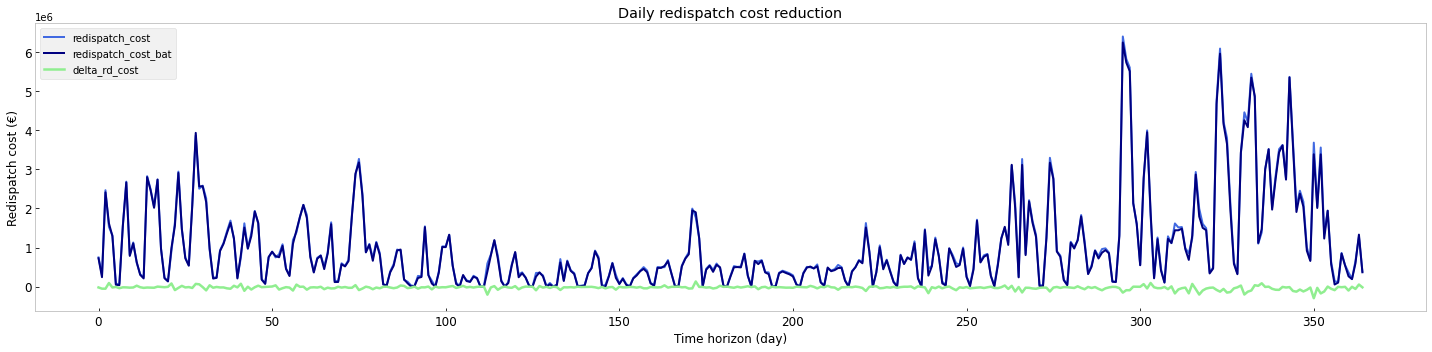

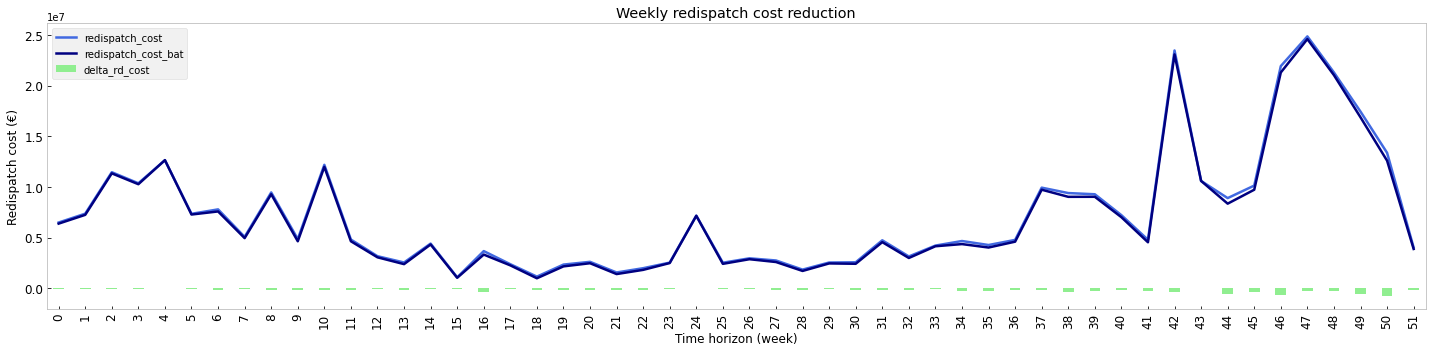

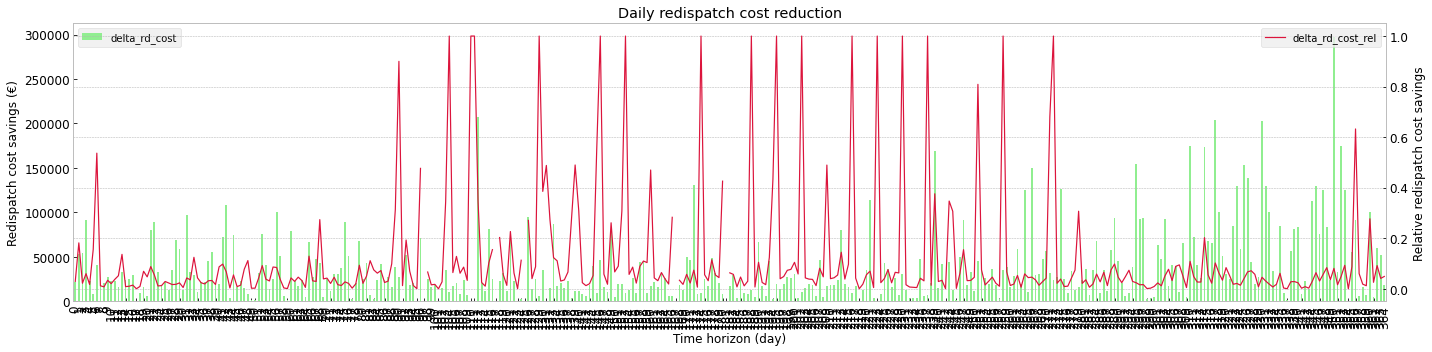

In [58]:
# df_obj, df_obj_day, df_obj_week = analyze_objective_rd(network_rd) 

# Objective analysis
df_obj4, df_obj_day4, df_obj_week4 = analyze_objective(network_rd, network_rd_bat4h) 
df_obj8, df_obj_day8, df_obj_week8 = analyze_objective(network_rd, network_rd_bat8h)
df_obj12, df_obj_day12, df_obj_week12 = analyze_objective(network_rd, network_rd_bat12h)
display(df_obj_day4)
print(df_obj_day4["delta_rd_cost_rel"].min())

# Plot
plot_objective_analysis(df_obj4, df_obj_day4, df_obj_week4)


# Analysis of redispatch energy reduction incl. dynamic time warping


name                Negative redispatch  Positive redispatch  \
Time horizon (day)                                             
0                             -25630.38             39346.17   
1                              -4812.19              6558.01   
2                             -28285.19             49724.64   
3                             -17301.35             31455.67   
4                             -16390.53             27062.41   
...                                 ...                  ...   
360                            -1512.18              7719.06   
361                            -2731.07              4147.52   
362                            -6468.48             18515.01   
363                           -26216.18             38142.39   
364                            -2891.76              9457.76   

name                Negative redispatch bat  Positive redispatch bat  \
Time horizon (day)                                                     
0                                 -26441.22                 38164.65   
1                                  -2758.86                  5388.46   
2                                 -27237.18                 48731.87   
3                                 -19135.45                 32871.25   
4                                 -15918.74                 26634.11   
...                                     ...                      ...   
360                                -1408.00                  5581.54   
361                                -2378.40                  4041.03   
362                                -5572.76                 17295.20   
363                               -28858.60                 40196.77   
364                                -2587.22                  9060.46   

name                Difference in curtailment  Difference in ramp-up  \
Time horizon (day)                                                     
0                                      810.84               -1181.52   
1                                    -2053.33               -1169.55   
2                                    -1048.01                -992.77   
3                                     1834.10                1415.58   
4                                     -471.79                -428.30   
...                                       ...                    ...   
360                                   -104.18               -2137.52   
361                                   -352.67                -106.49   
362                                   -895.72               -1219.81   
363                                   2642.42                2054.38   
364                                   -304.54                -397.30   

name                Total redispatch  Total redispatch bat  \
Time horizon (day)                                           
0                           64976.55              64605.87   
1                           11370.20               8147.32   
2                           78009.83              75969.05   
3                           48757.02              52006.70   
4                           43452.94              42552.85   
...                              ...                   ...   
360                          9231.24               6989.54   
361                          6878.59               6419.43   
362                         24983.49              22867.96   
363                         64358.57              69055.37   
364                         12349.52              11647.68   

name                Total redispatch difference  
Time horizon (day)                               
0                                       -370.68  
1                                      -3222.88  
2                                      -2040.78  
3                                       3249.68  
4                                       -900.09  
...                                         ...  
360                                    -2241.70  
361                                 

Total redispatch  Total redispatch  delta_rd_cost
Delta_obj_day                                    
Total redispatch          0.000000       0.186788
delta_rd_cost             0.171166       0.000000

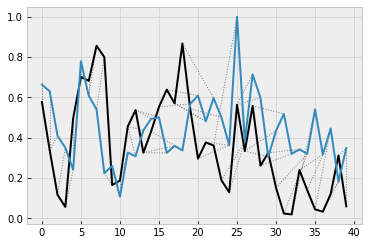

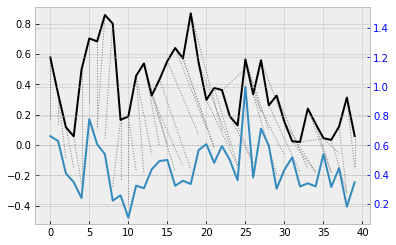

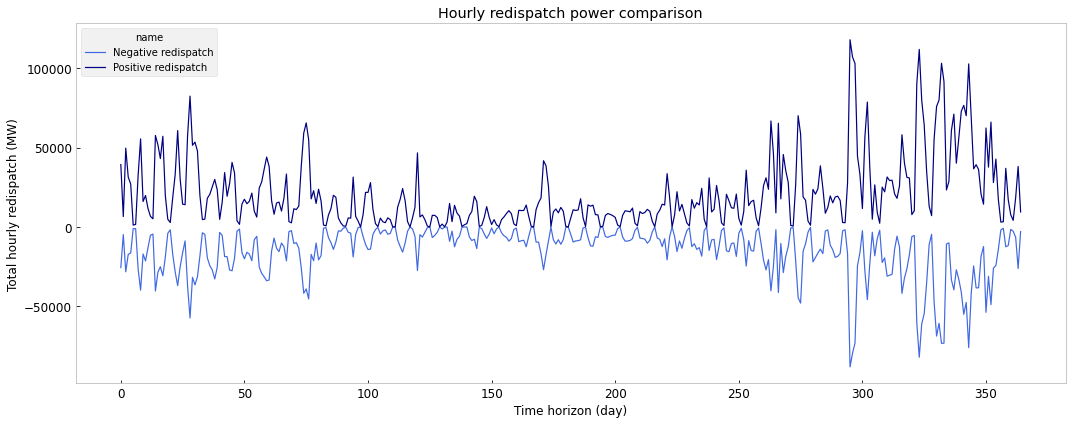

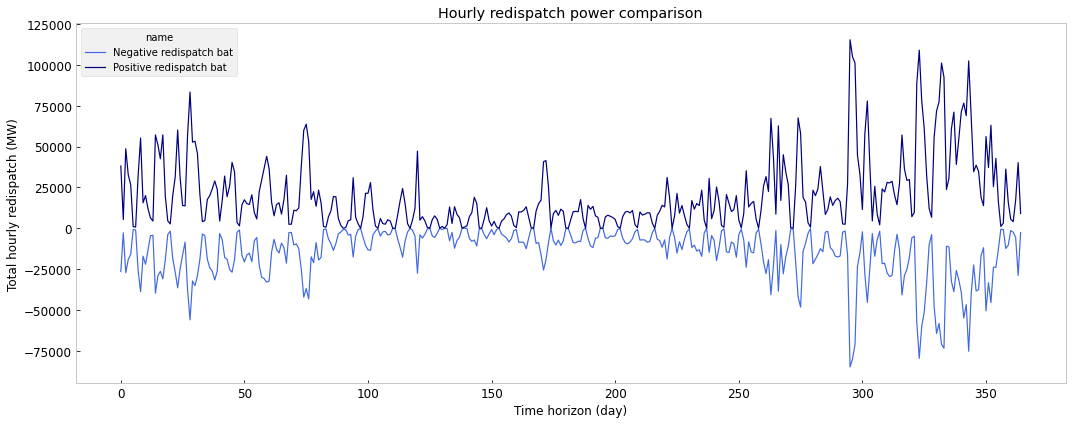

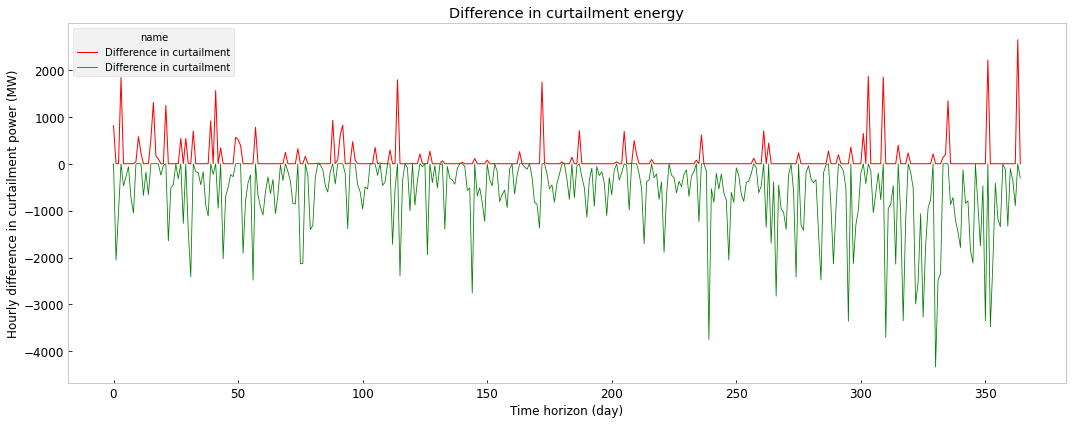

In [87]:
df_bat_nobat4, df_bat_nobat_day4, dtw_diff4 = analyze_dynamic_time_warping(network_rd, network_rd_bat4h, df_obj4, df_obj_day4)
plot_energy_dynamic_time_warping(df_bat_nobat4, df_bat_nobat_day4, dtw_diff4)

# Difference Merit order (dispatch) -> Reorganization of dispatch

{'CCGT': 47.2,
 'OCGT': 58.3846,
 'biomass': 14.9573,
 'coal': 24.1034,
 'lignite': 13.4877,
 'nuclear': 16.9021,
 'offwind': 0.015,
 'oil': 130.2265,
 'onwind': 0.015,
 'ror': 0.01,
 'solar': 0.01}


2018-02-26 11:00:00


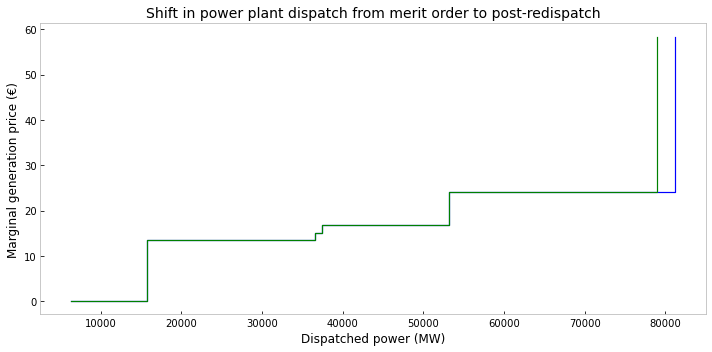

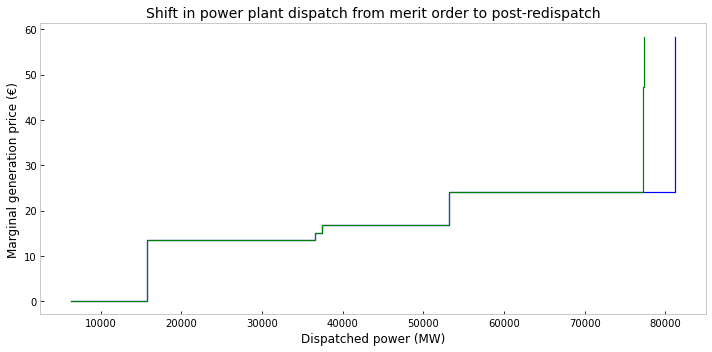

taste


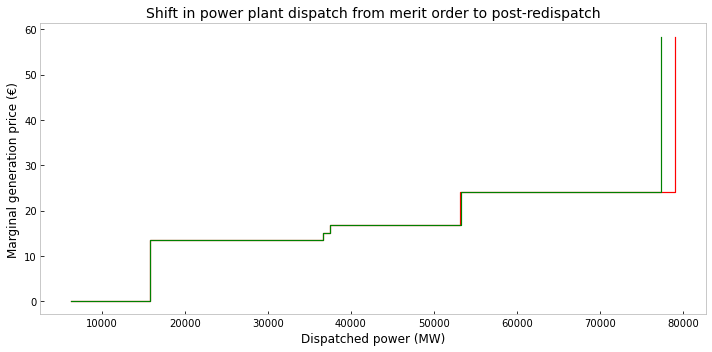



2018-02-27 12:00:00


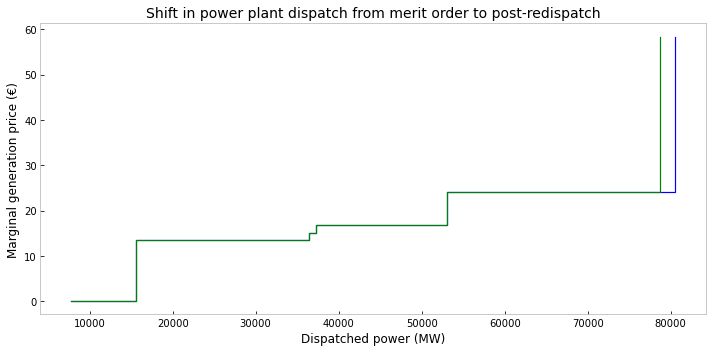

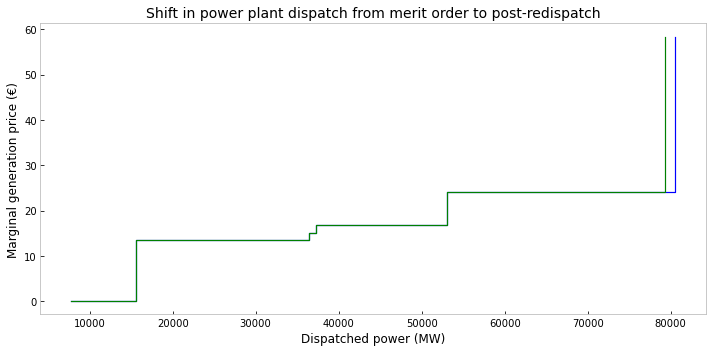

taste


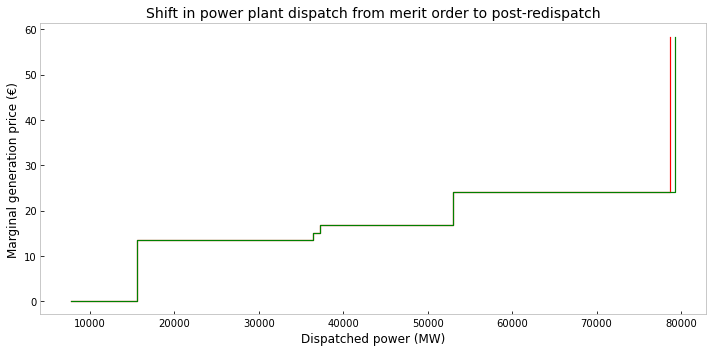



2018-02-28 18:00:00


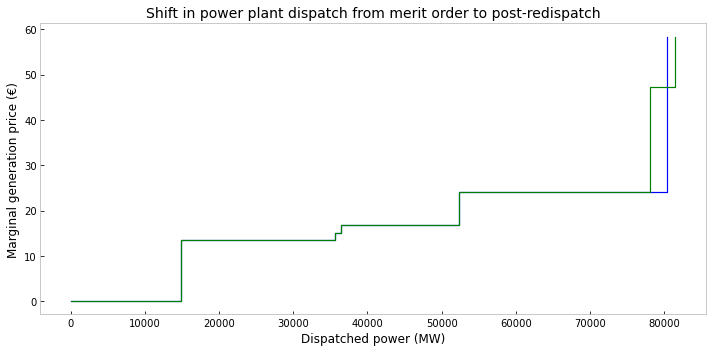

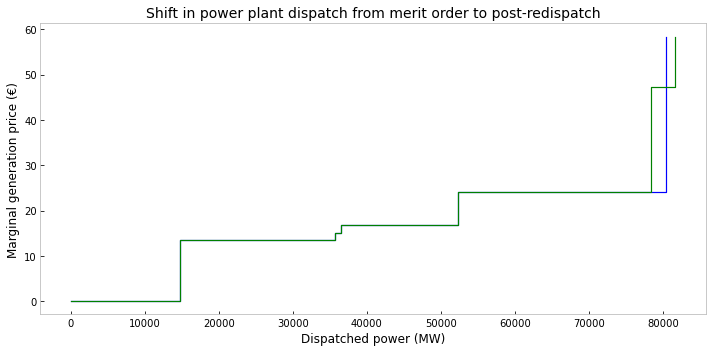

taste


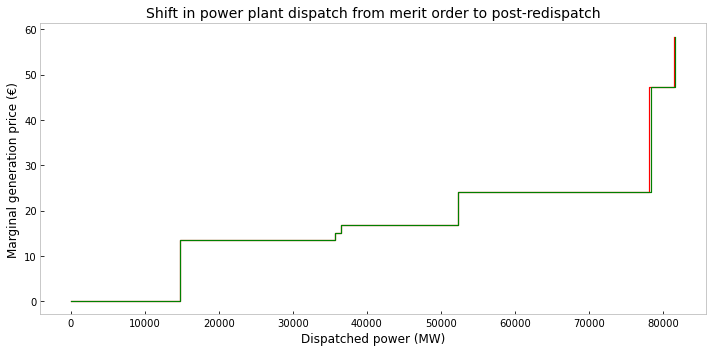



2018-02-28 10:00:00


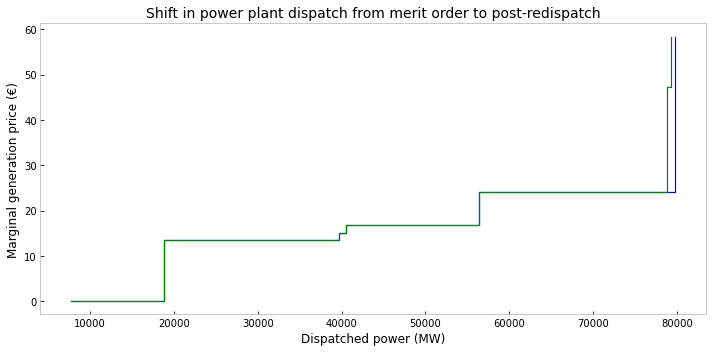

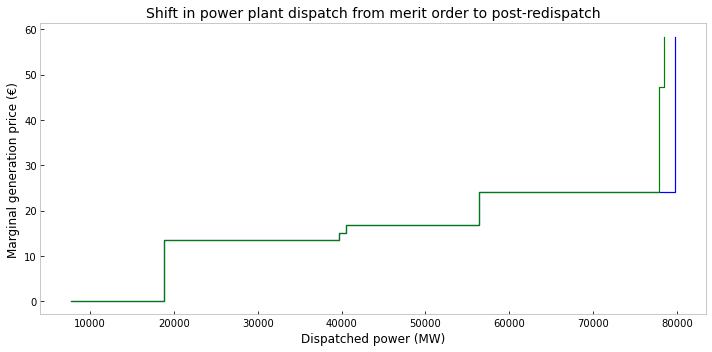

taste


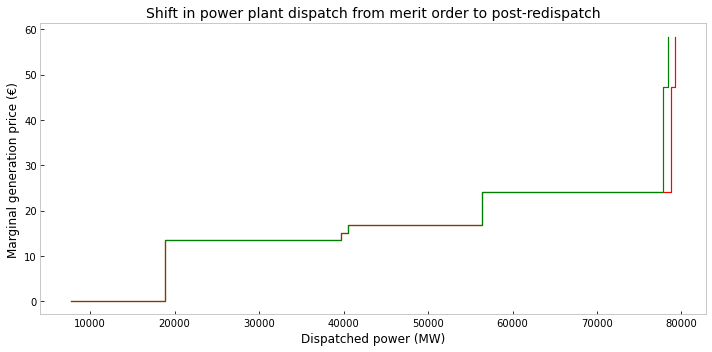



2018-02-28 17:00:00


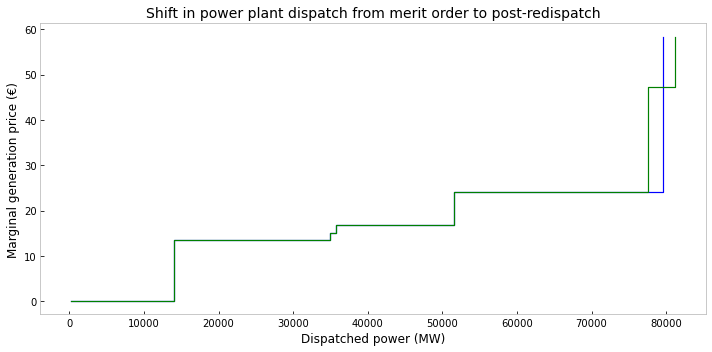

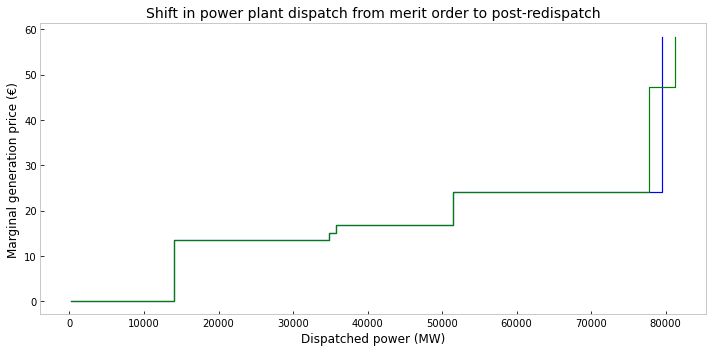

taste


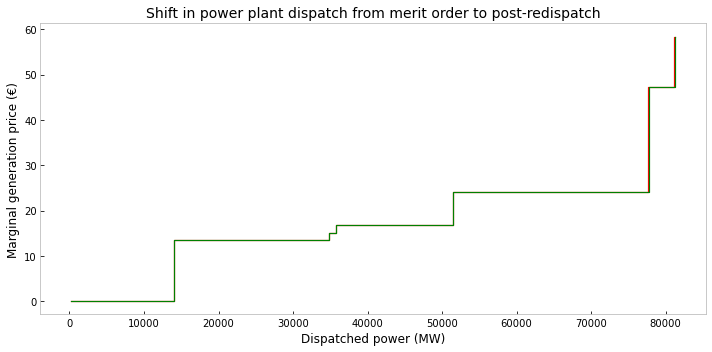

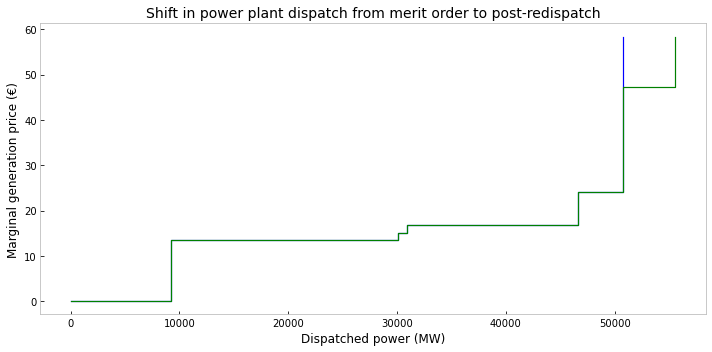

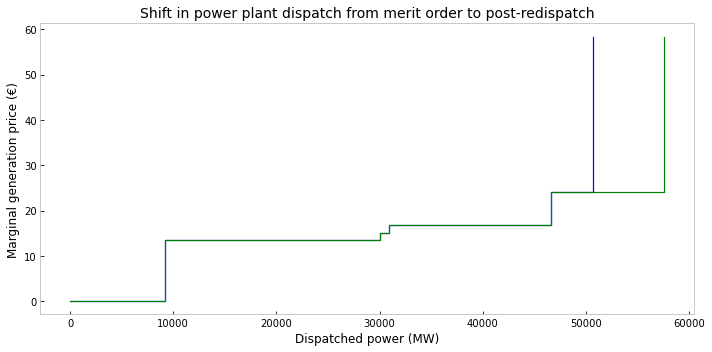

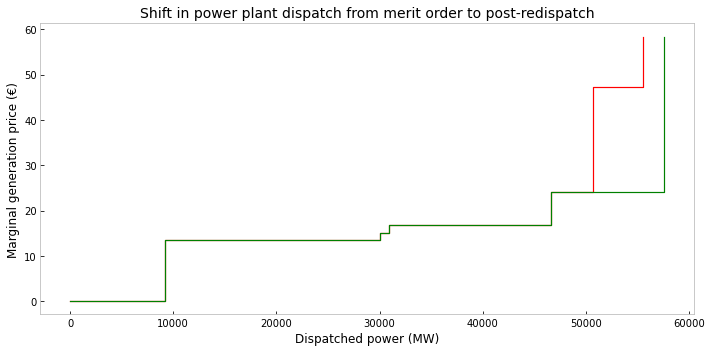

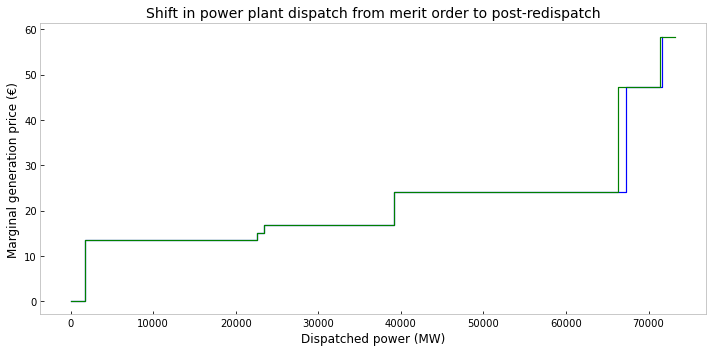

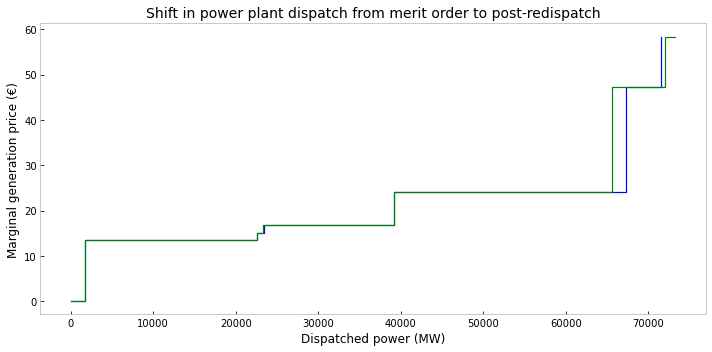

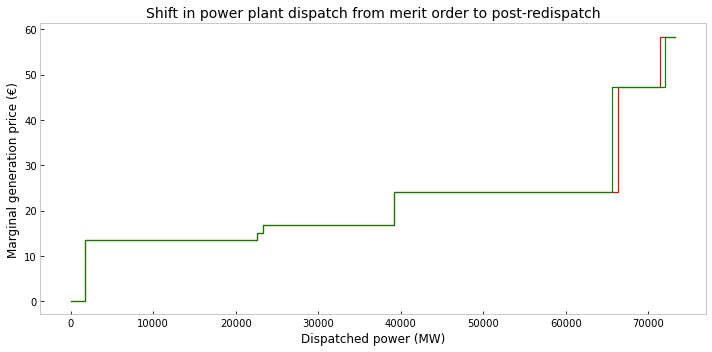

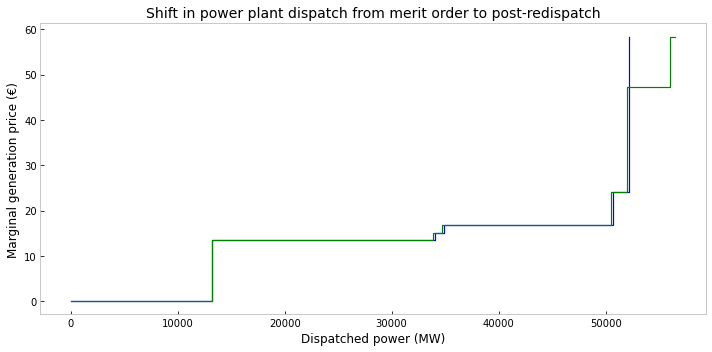

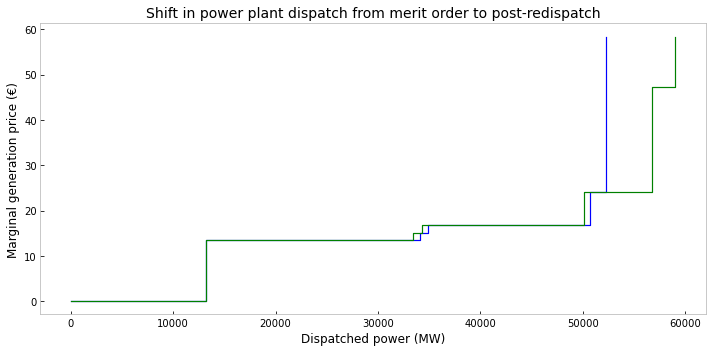

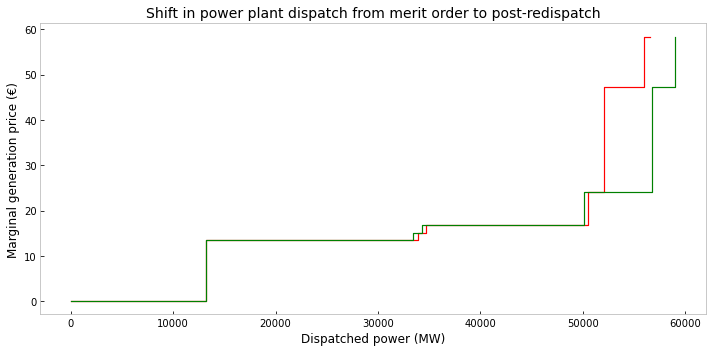

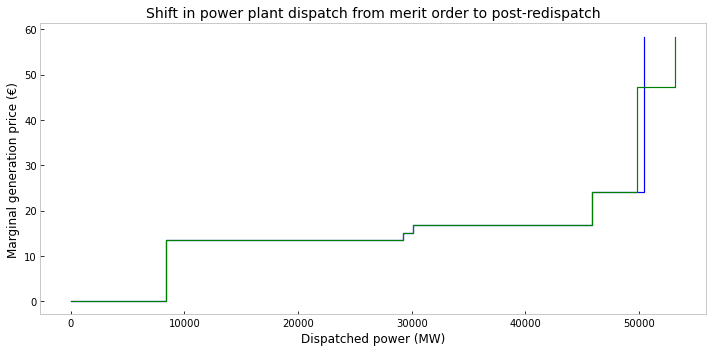

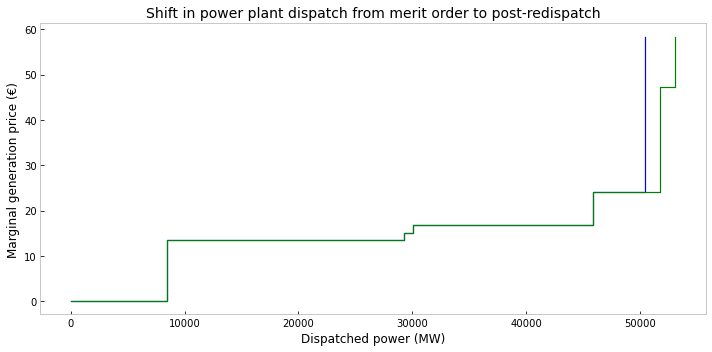

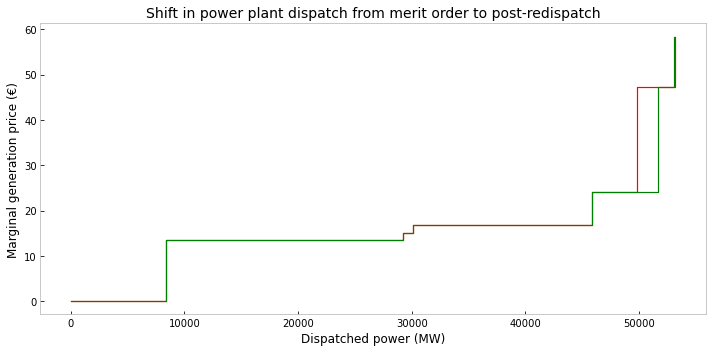

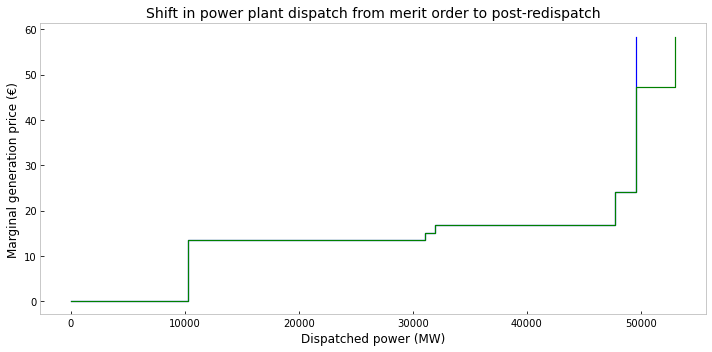

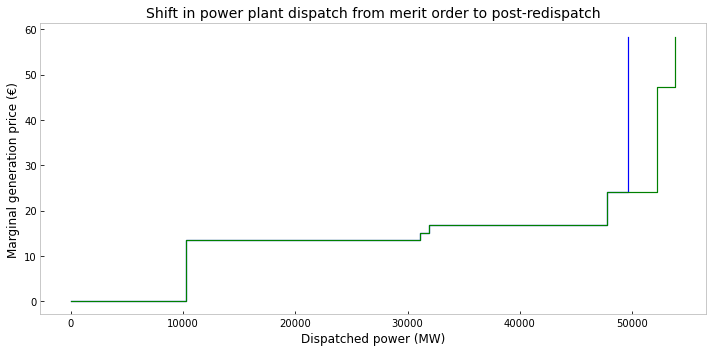

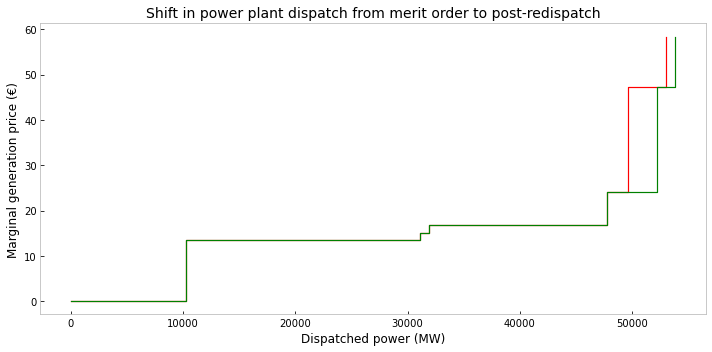

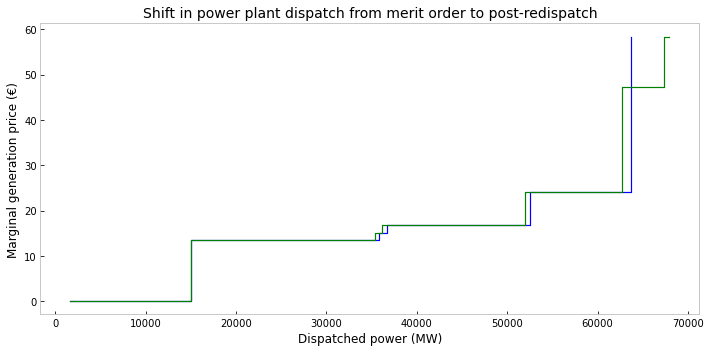

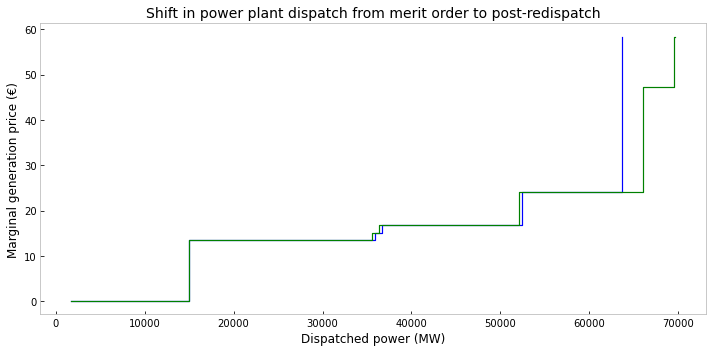

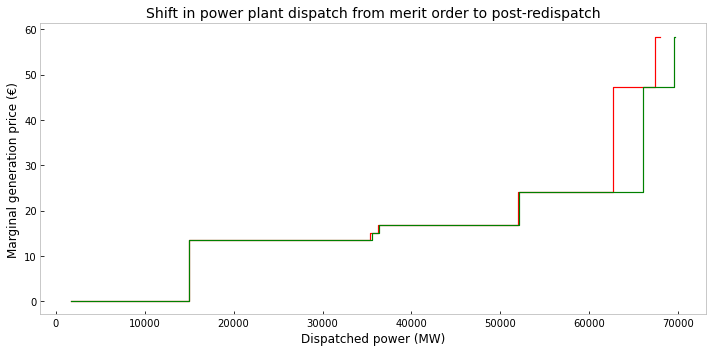

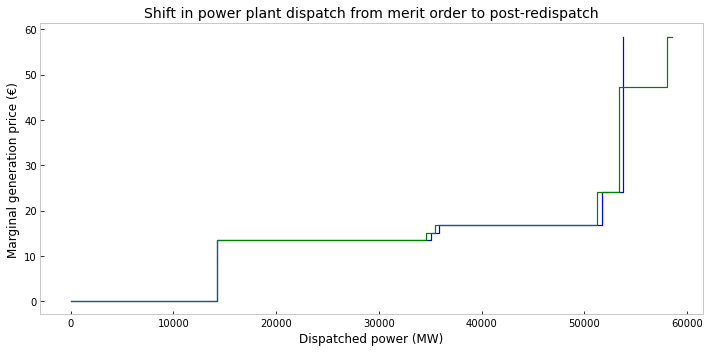

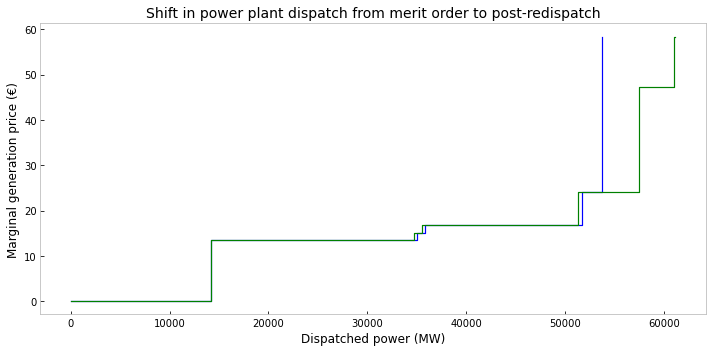

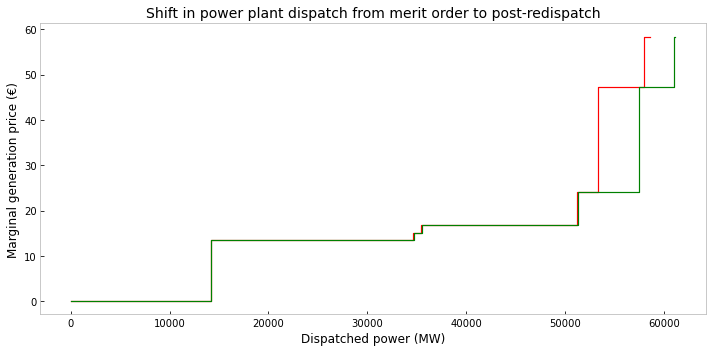

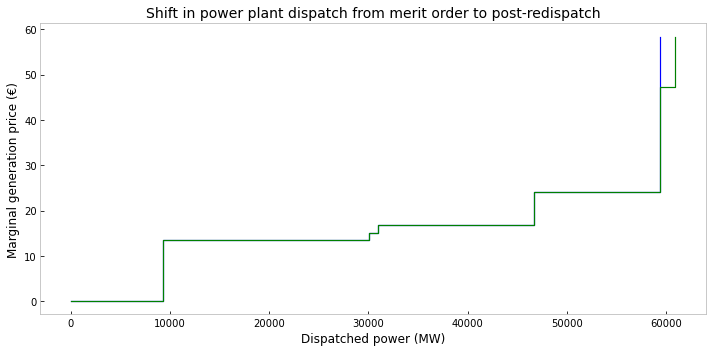

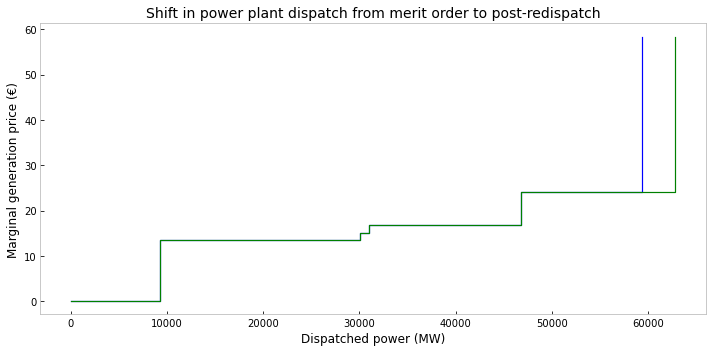

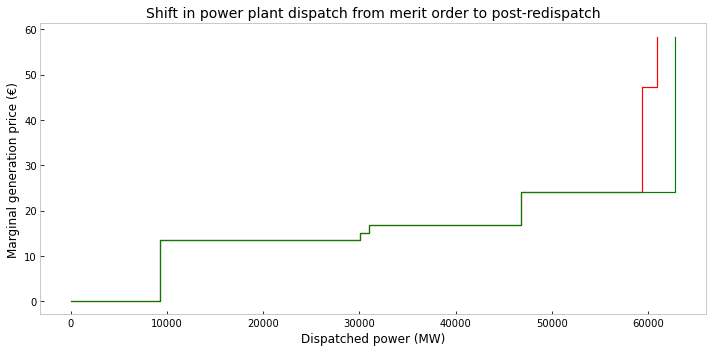

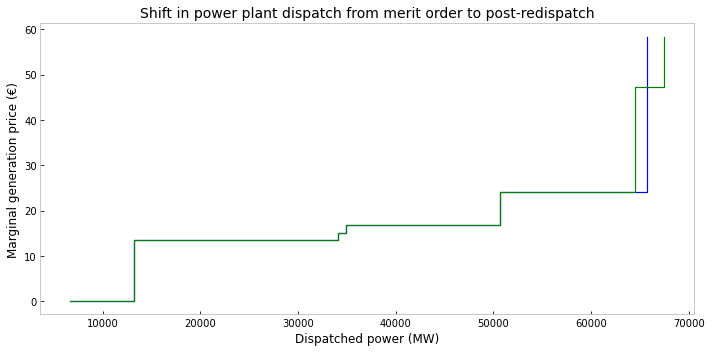

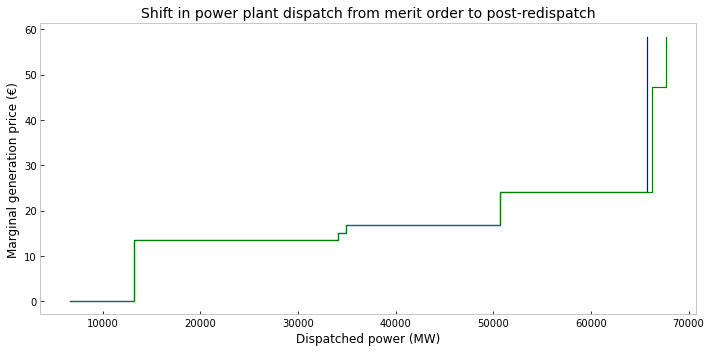

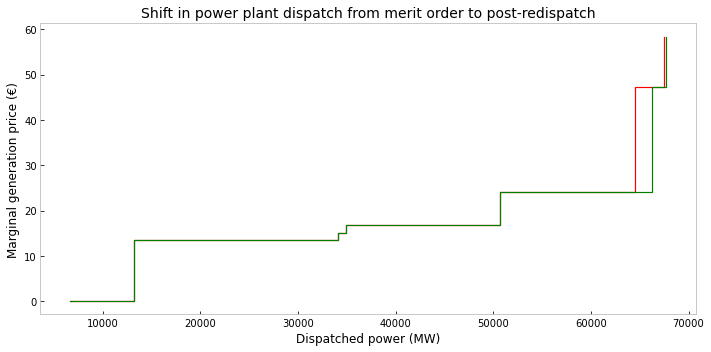

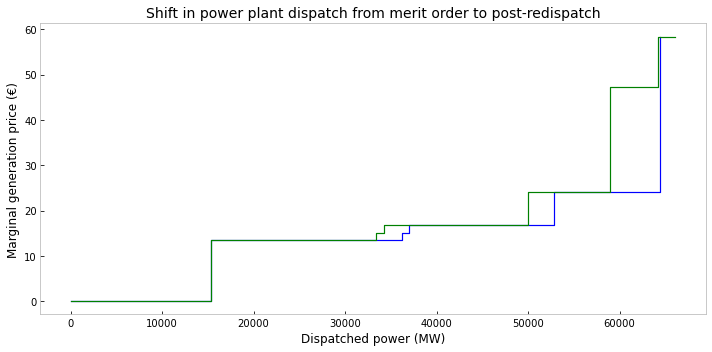

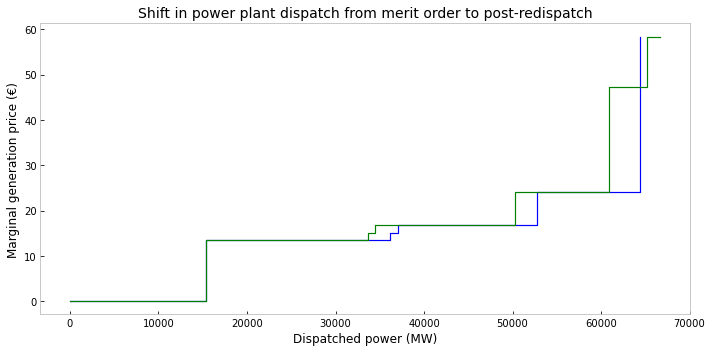

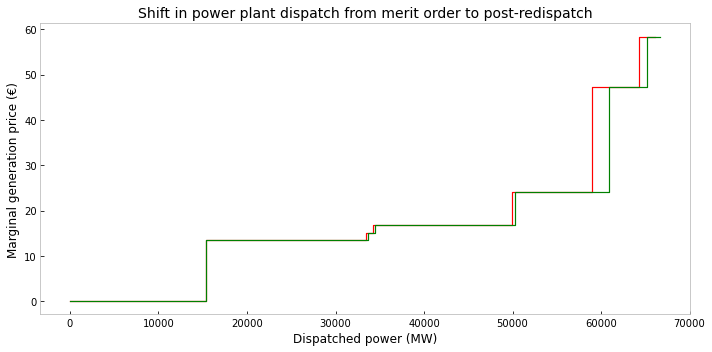

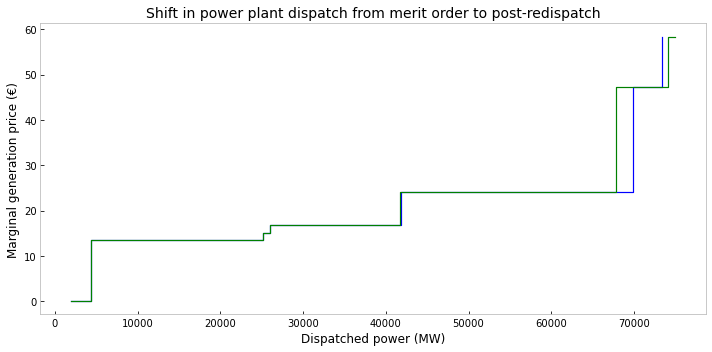

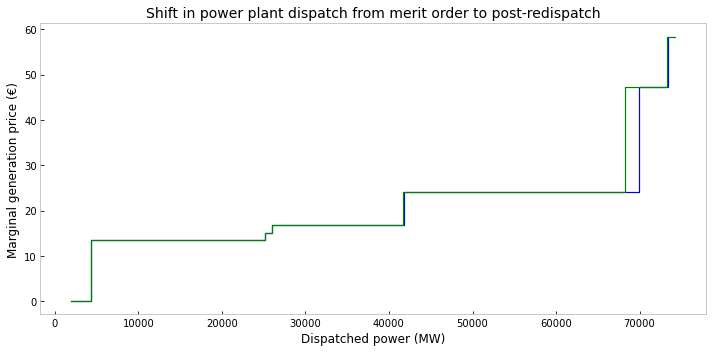

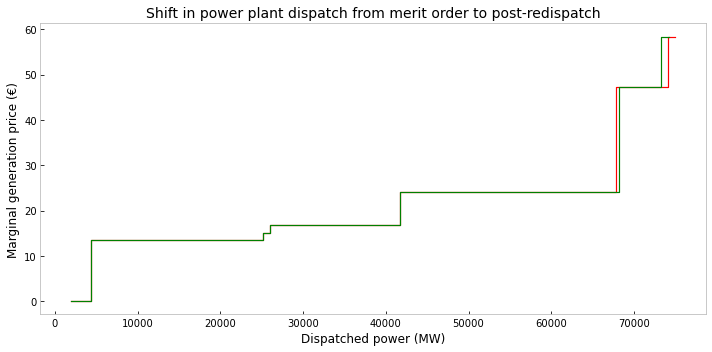

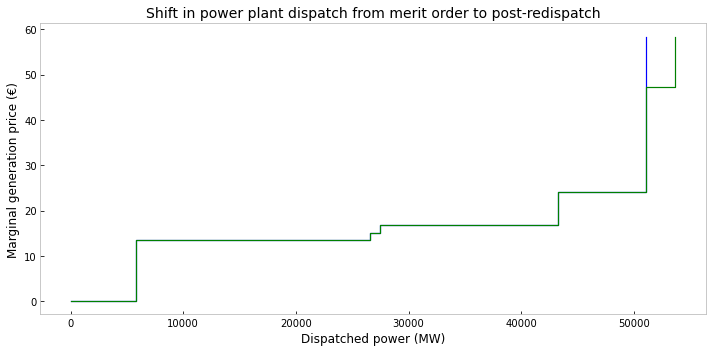

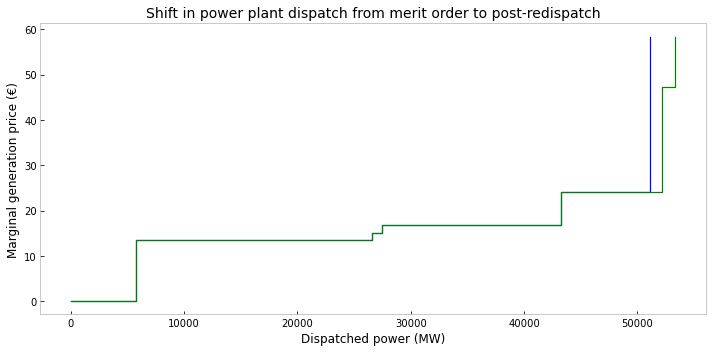

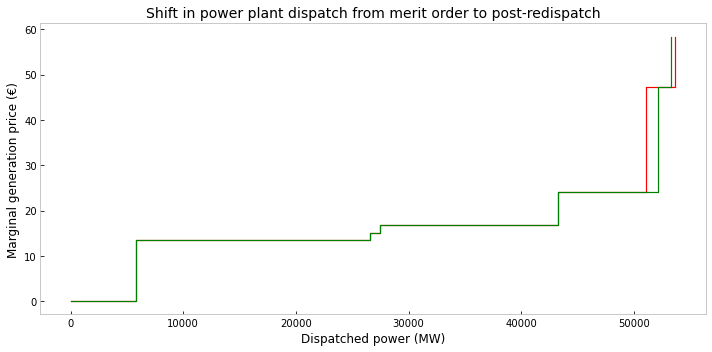

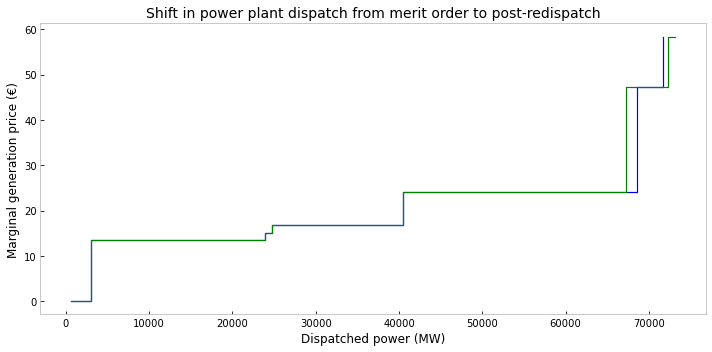

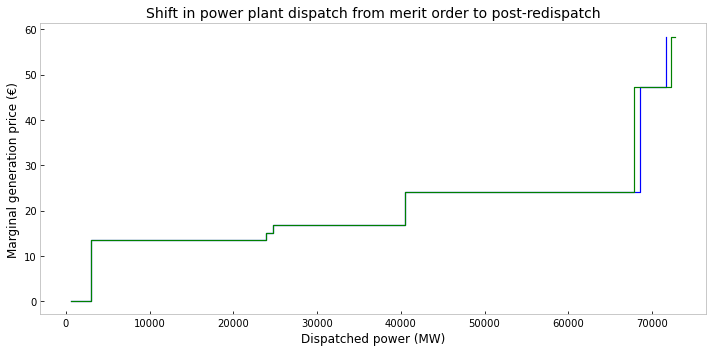

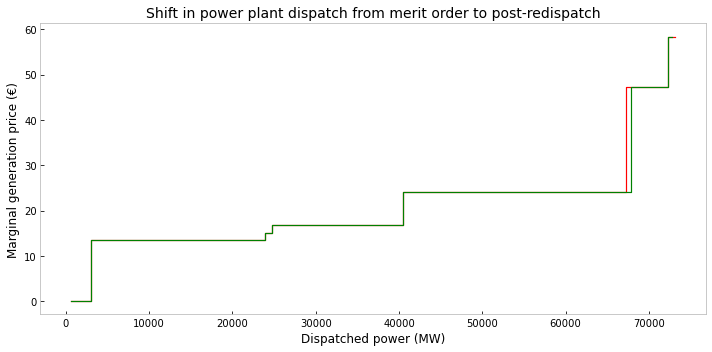

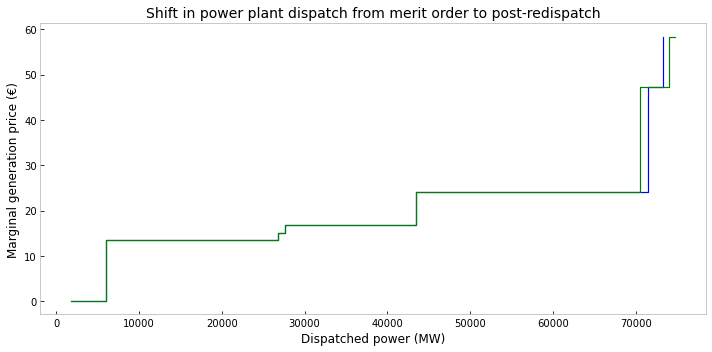

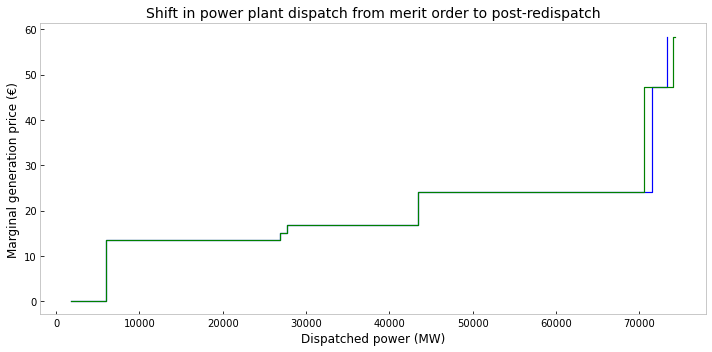

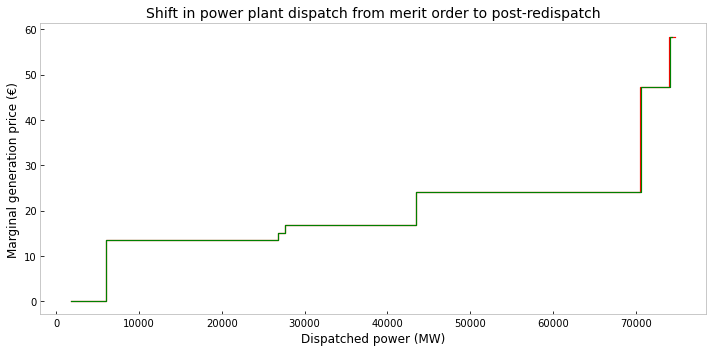

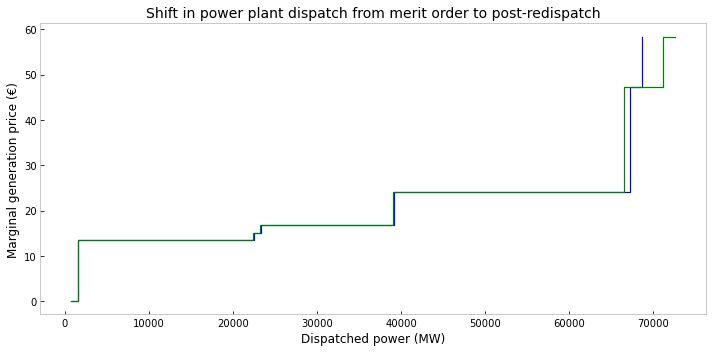

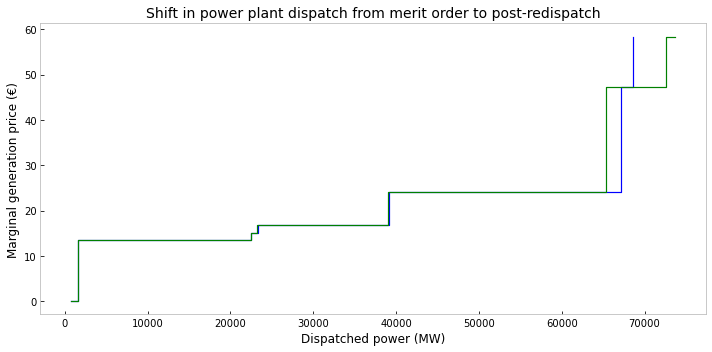

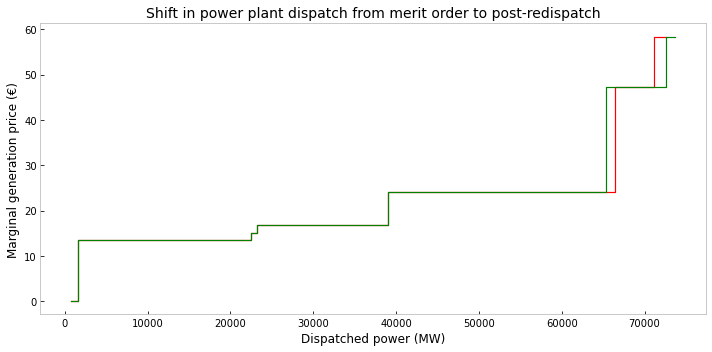

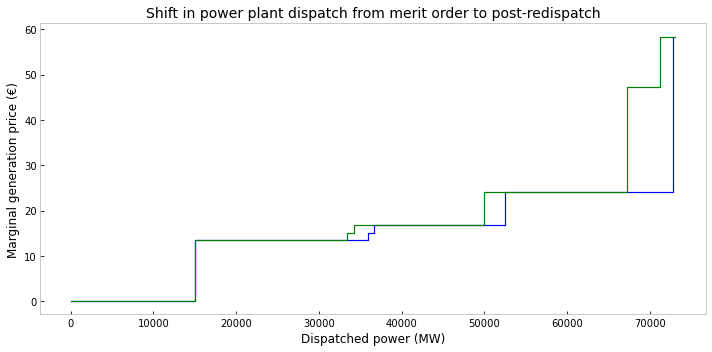

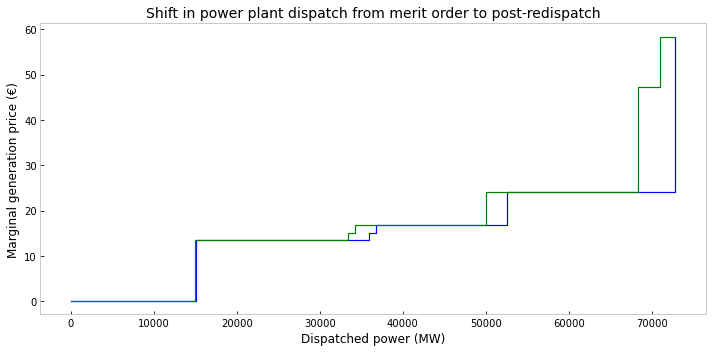

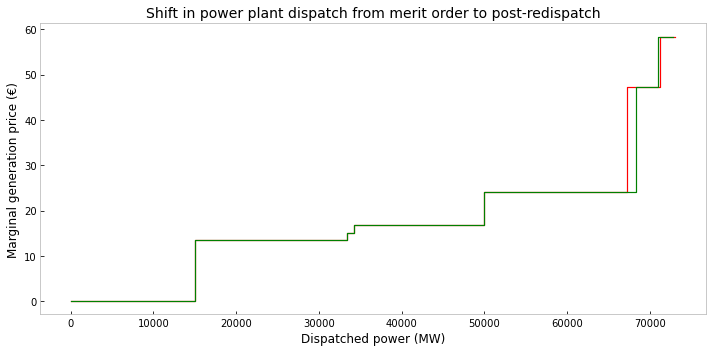

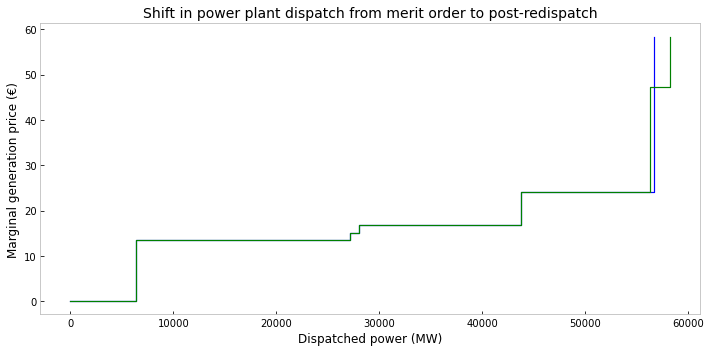

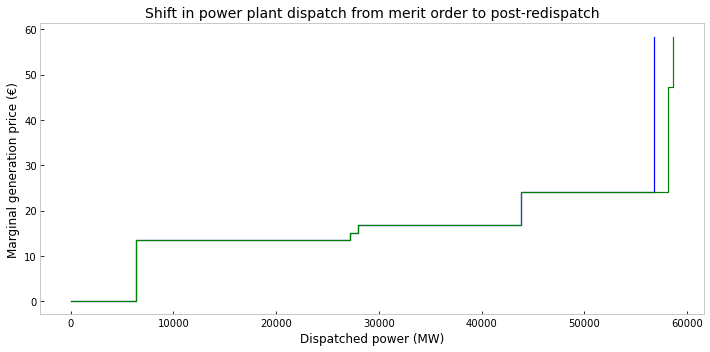

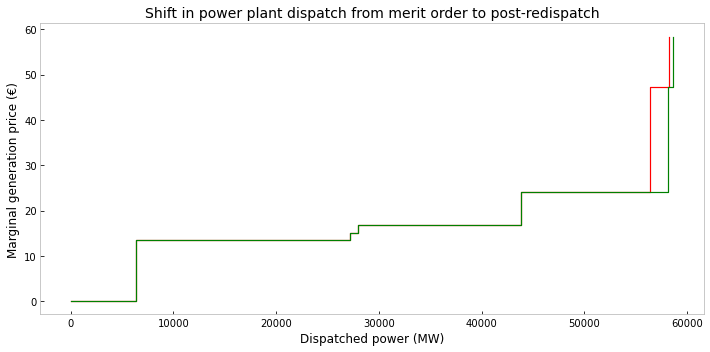

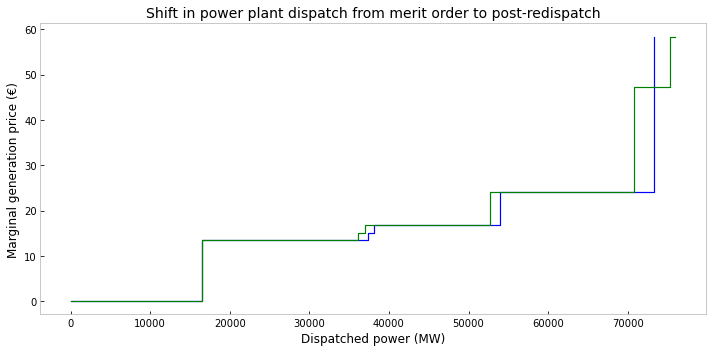

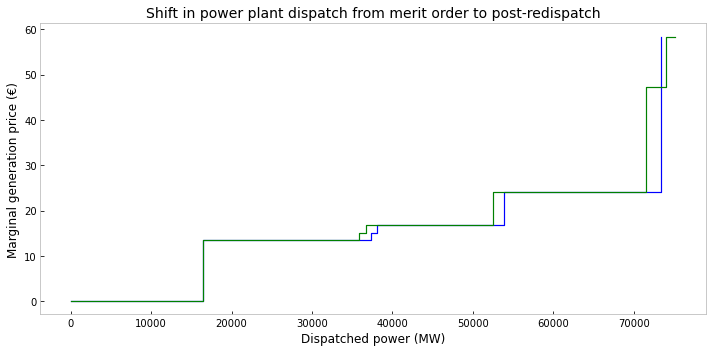

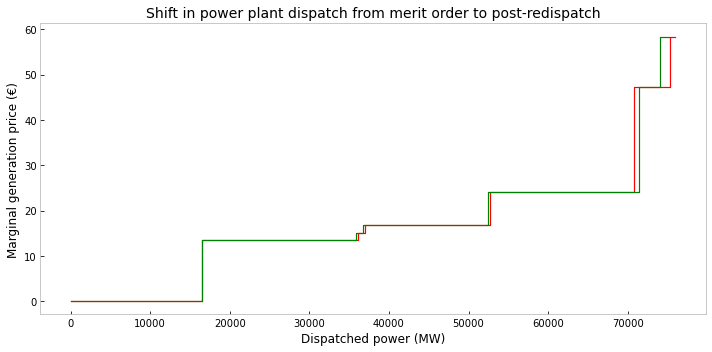

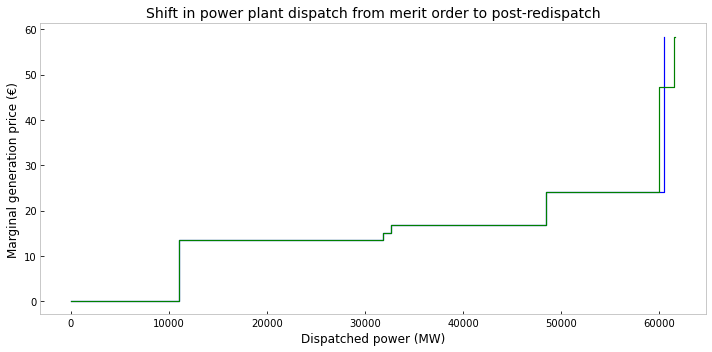

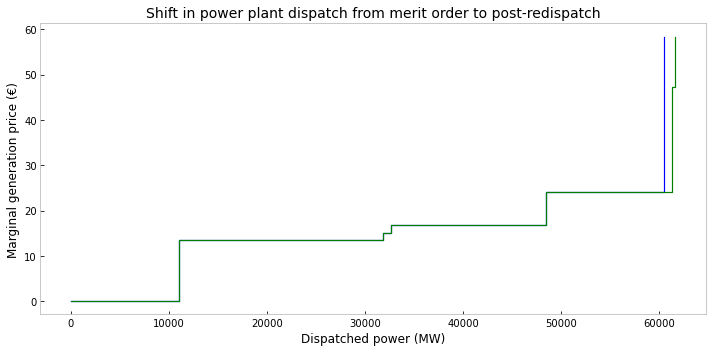

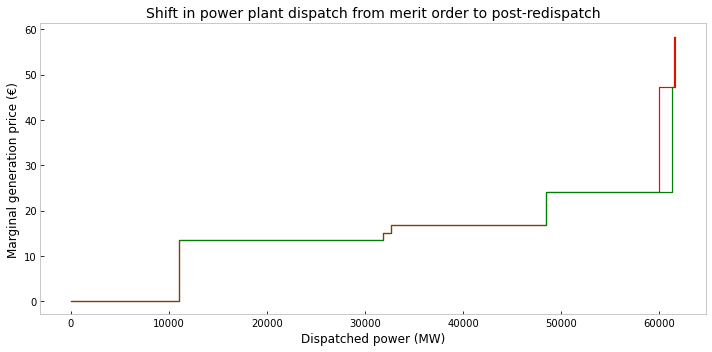

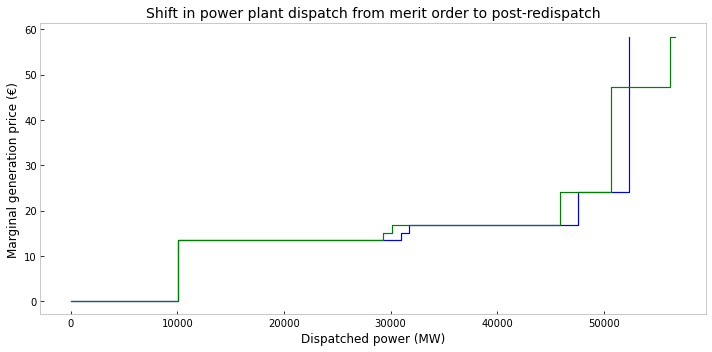

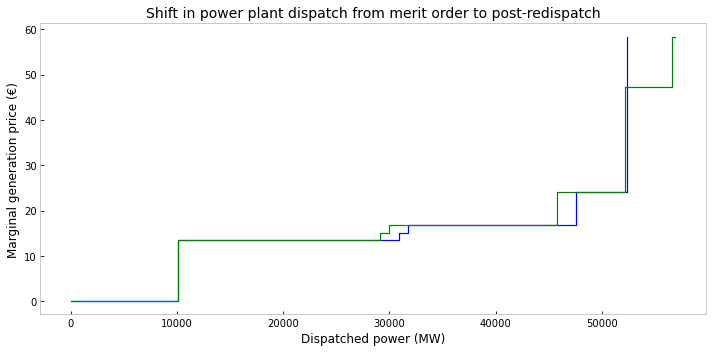

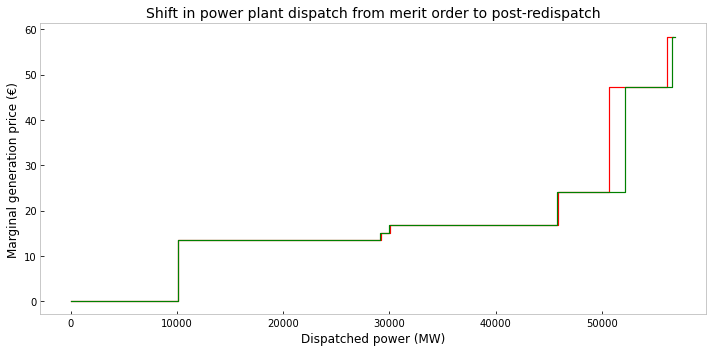

In [128]:
analyze_and_plot_merit_order_shift(network_d, network_rd, network_rd_bat4h, df_obj4)    

# Co2 Analysis 

23102.34661879833

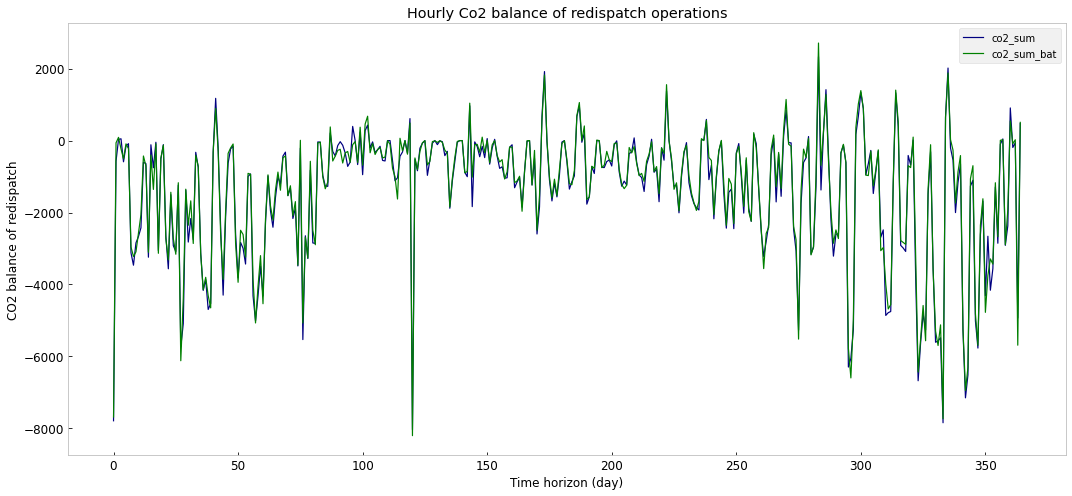

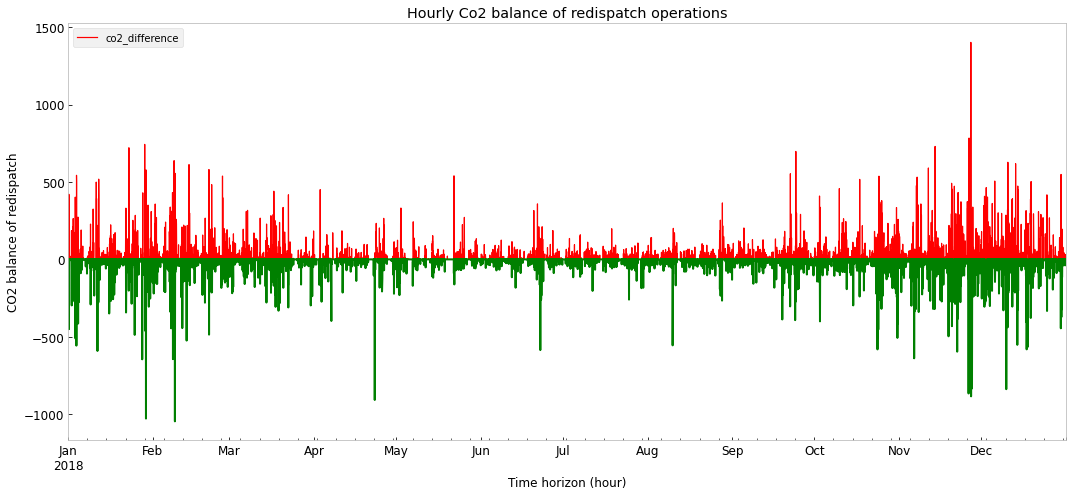

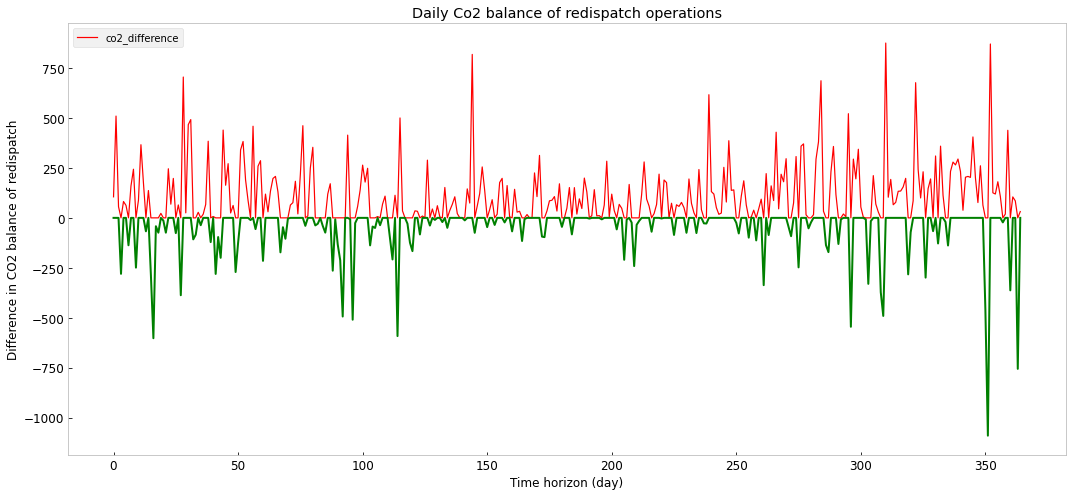

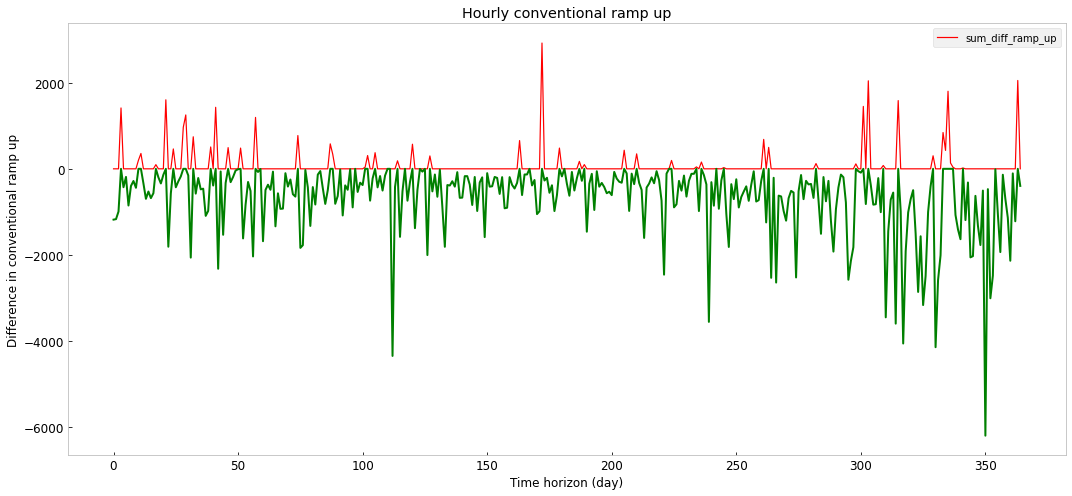

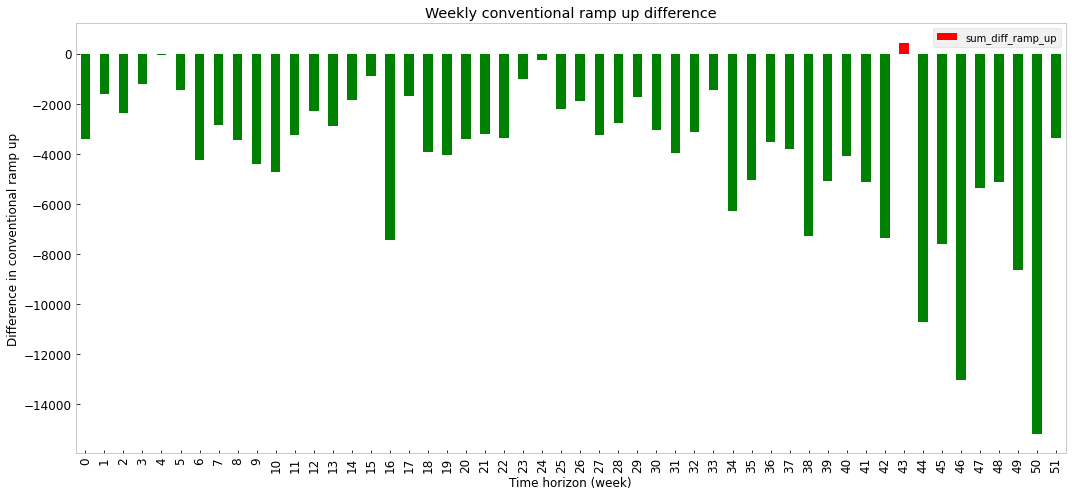

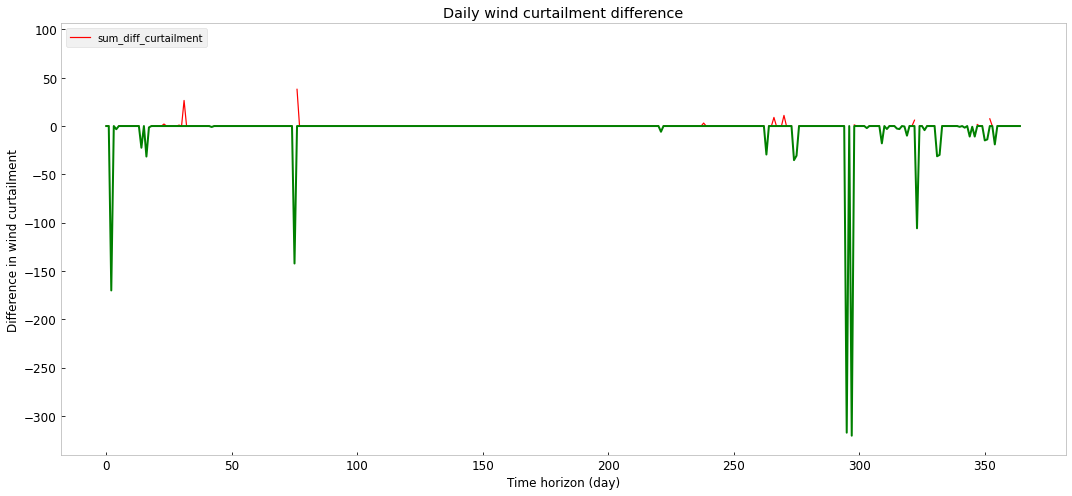

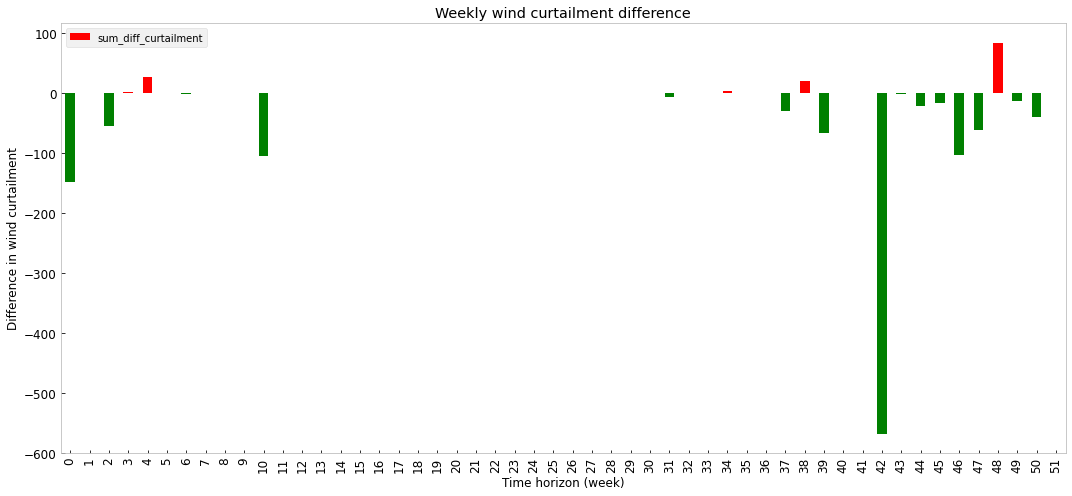

In [156]:
analyze_and_plot_co2_reduction(network_rd,network_rd_bat4h)

# <b> Line congestion analysis <b>

103       104          105       115        139  \
name                                                                         
2018-01-01 00:00:00   0.091912  0.802541     0.891232  0.096474   0.602630   
2018-01-01 01:00:00   0.236994  0.926471     1.000000  0.237547   0.721729   
2018-01-01 02:00:00   0.244398  0.468343     0.535975  0.059530   0.726794   
2018-01-01 03:00:00   0.332039  0.939632     1.000000  0.124695   0.782889   
2018-01-01 04:00:00   0.205817  0.524323     0.582686  0.032305   0.685124   
...                        ...       ...          ...       ...        ...   
2018-12-31 20:00:00   0.527069  0.646011     0.837340  0.325768   0.761264   
2018-12-31 21:00:00   0.259704  0.733984     0.916607  0.341709   0.632718   
2018-12-31 22:00:00   0.315219  0.806432     0.978869  0.292329   0.683511   
2018-12-31 23:00:00   0.309644  0.306861     0.455889  0.256604   0.698458   
Number overloaded h  36.000000  2.000000  2419.000000  4.000000  23.000000   

                             150         156         19       193     199  \
name                                                                        
2018-01-01 00:00:00     0.288591    0.676753   0.274431  0.153805     1.0   
2018-01-01 01:00:00     0.179982    0.819791   0.246174  0.273722     1.0   
2018-01-01 02:00:00     0.165653    0.823770   0.242871  0.271162     1.0   
2018-01-01 03:00:00     0.162780    0.882625   0.238198  0.337110     1.0   
2018-01-01 04:00:00     0.186416    0.774245   0.161992  0.238218     1.0   
...                          ...         ...        ...       ...     ...   
2018-12-31 20:00:00     0.832391    0.808128   0.462617  0.602008     1.0   
2018-12-31 21:00:00     0.834095    0.669533   0.424708  0.324976     1.0   
2018-12-31 22:00:00     0.776937    0.732182   0.410585  0.362999     1.0   
2018-12-31 23:00:00     0.699550    0.750920   0.428044  0.341127     1.0   
Number overloaded h  1490.000000  344.000000  27.000000  7.000000  1303.0   

                           208         216       240          246  \
name                                                                
2018-01-01 00:00:00   0.468244    0.874269  0.540786     0.996986   
2018-01-01 01:00:00   0.003460    0.781004  0.325295     1.000000   
2018-01-01 02:00:00   0.760172    0.803936  0.453065     1.000000   
2018-01-01 03:00:00   0.085874    0.916282  0.336052     1.000000   
2018-01-01 04:00:00   0.340222    0.751800  0.325222     1.000000   
...                        ...         ...       ...          ...   
2018-12-31 20:00:00   0.101244    0.792880  0.541300     0.949234   
2018-12-31 21:00:00   0.109305    0.402953  0.535441     0.939219   
2018-12-31 22:00:00   0.080879    0.713954  0.507223     1.000000   
2018-12-31 23:00:00   0.098777    0.796145  0.483335     1.000000   
Number overloaded h  14.000000  187.000000  2.000000  1177.000000   

                              26          268         277        47  \
name                                                                  
2018-01-01 00:00:00     0.781297     0.061260    0.515925  0.144438   
2018-01-01 01:00:00     0.703506     0.279769    0.599144  0.184728   
2018-01-01 02:00:00     0.674897     0.244407    0.615166  0.168698   
2018-01-01 03:00:00     0.853911     0.197374    0.671960  0.217845   
2018-01-01 04:00:00     0.670476     0.060234    0.566319  0.077819   
...                          ...          ...         ...       ...   
2018-12-31 20:00:00     0.617491     0.275021    0.585874  0.303701   
2018-12-31 21:00:00     0.961299     0.404517    0.487062  0.222755   
2018-12-31 22:00:00     0.539997     0.395557    0.518858  0.243058   
2018-12-31 23:00:00     0.647042     0.313225    0.564350  0.315145   
Number overloaded h  3585.000000  3077.000000  393.000000  7.000000   

                             49         51          69      74  \
name                                                             
2018-01-01 00:00:00    0.496259   0.356831    0.379932  

Mean shadow price  Mean shadow price w/ batteries  difference
name                                                               
150          146.681787                      138.592482   -8.089305
49            41.028578                       39.952344   -1.076234
69             0.997790                        0.924747   -0.073042
246            2.401489                        2.340101   -0.061388
274            0.000000                        0.000000    0.000000
...                 ...                             ...         ...
187            0.000000                        0.000000    0.000000
99             0.000000                        0.000000    0.000000
47             0.020966                        0.024802    0.003837
104            0.007526                        0.011627    0.004101
51             0.043042                        0.055234    0.012192

[287 rows x 3 columns]

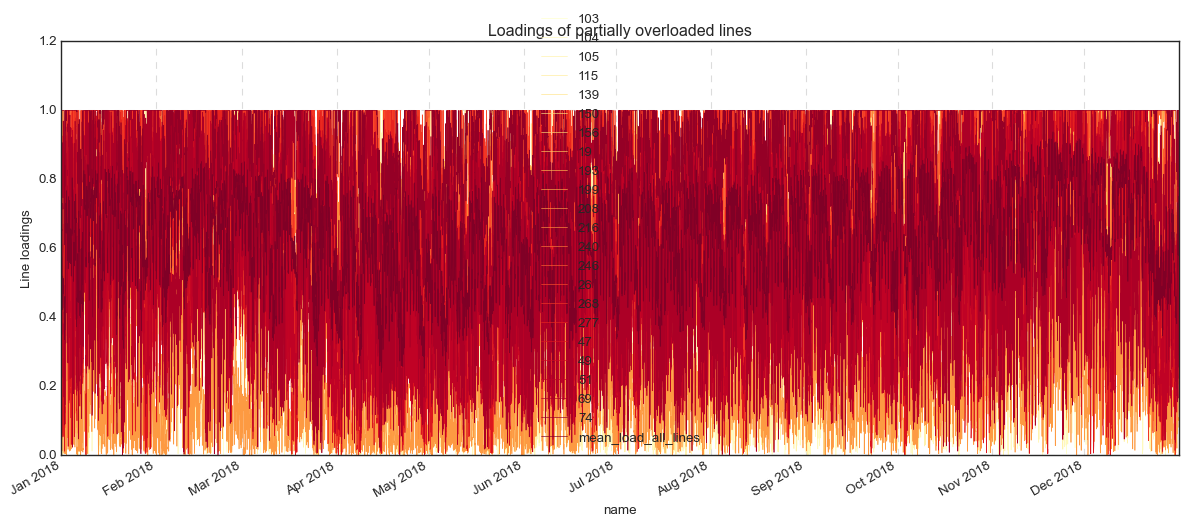

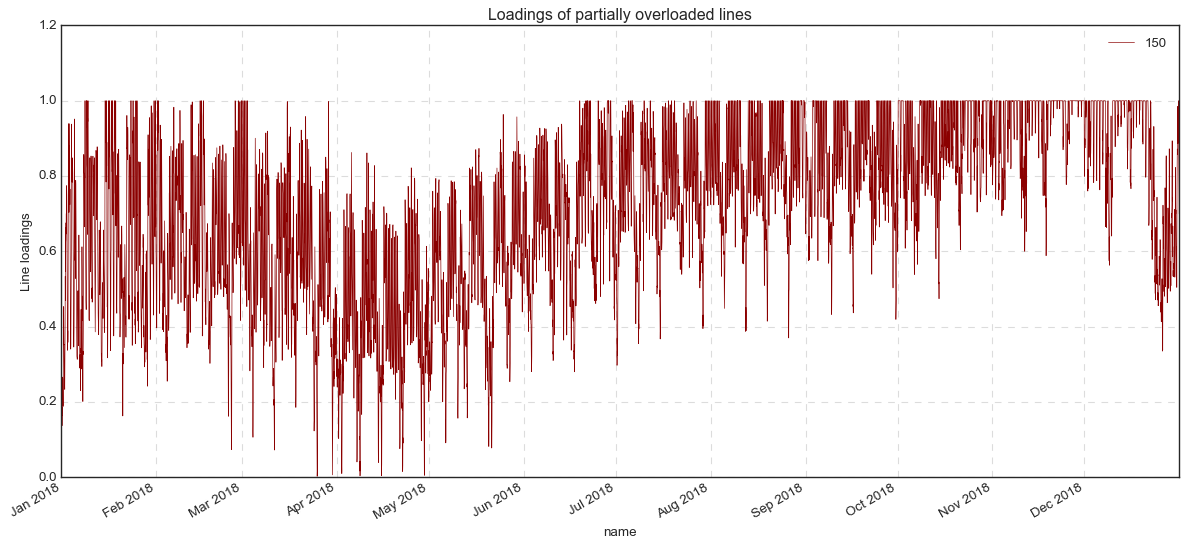

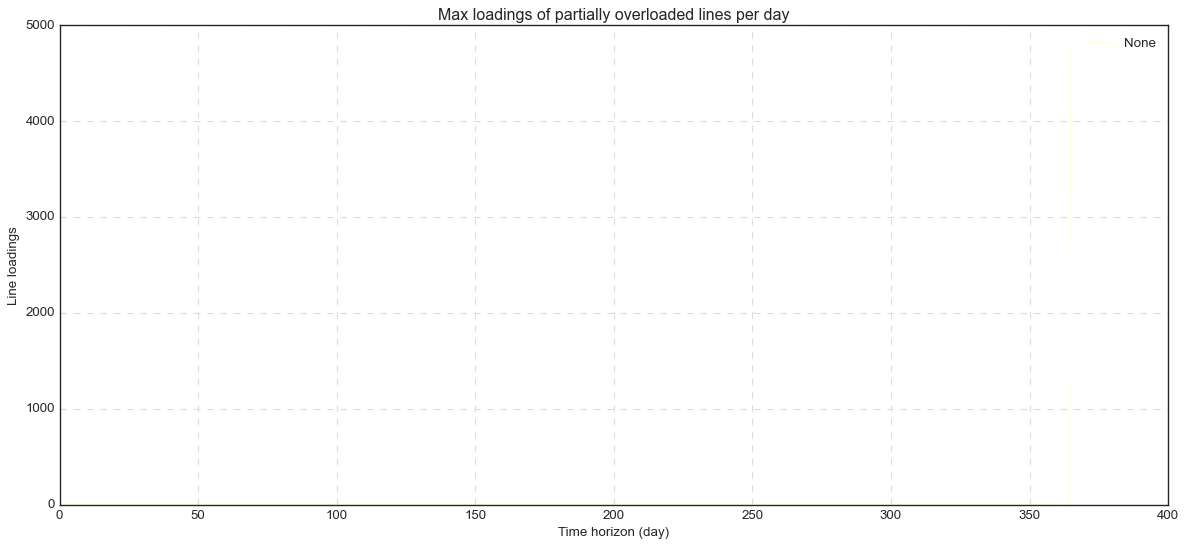

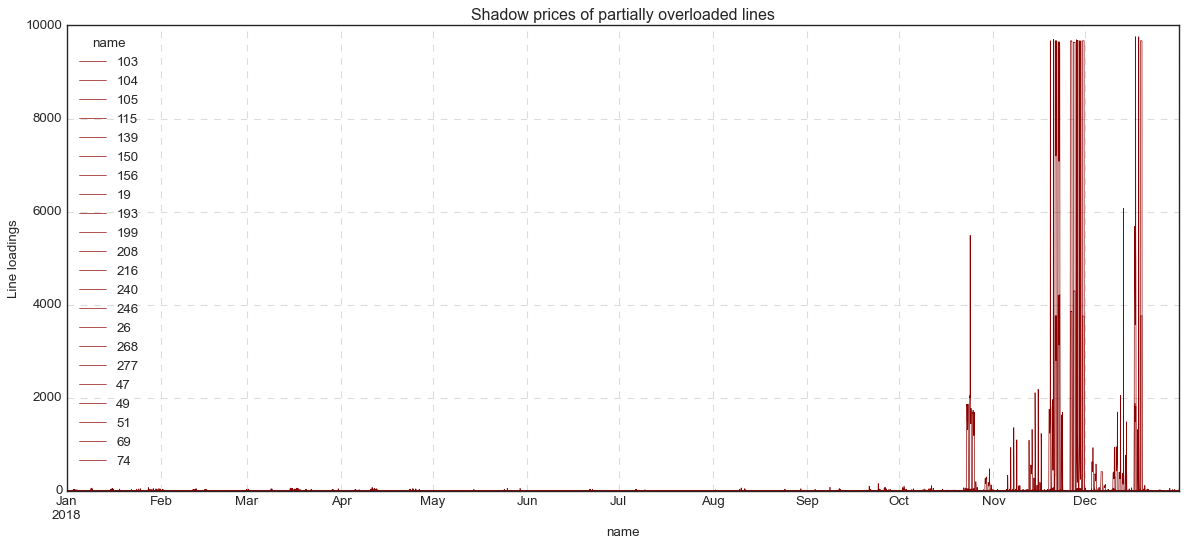

In [187]:
# Line Congestion Analysis
# ------------------------

def analyze_and_plot_line_congestion(network_rd, network_rd_bat):
    df_line_p = network_rd.lines_t.p0.copy()
    df_line_loading = (network_rd.lines_t.p0.abs()/(network_rd.lines.s_nom_opt*network_rd.lines.s_max_pu).sort_index().fillna(0.)).copy()
    df_shadows = abs(network_rd.lines_t.mu_upper.copy())
    
    
    # NO BATTERIES
    # Loading analysis: Only keep lines with loading == 1
    cols_overload = []
    for col in list(df_line_loading):
        if df_line_loading[col].max() >= 0.999999:
            cols_overload.append(col)
    df_line_overload = df_line_loading[cols_overload]
    df_line_overload["mean_load_all_lines"] = df_line_overload.mean(axis=1)
    
    # Append number of overloaded hours
    dict_overload={}
    for col in list(df_line_overload):
        count_overload = df_line_overload[col].value_counts().values[0]
        dict_overload[col] = count_overload
    s_overload = pd.Series(dict_overload, name = "Number overloaded h")
    df_line_overload = df_line_overload.append(s_overload)
    display(df_line_overload)
    
    # dataframe for maximum daily load of overloaded lines (hoy many days is a line overloaded)
    df_line_overload_day = df_line_overload.groupby(np.arange(len(df_line_overload))//24).max()
    # Get shadow prices of overloaded lines
    df_shadows_overload = df_shadows[cols_overload]
    # Get lines with biggest mean shadow prices
    s_shadows_overload_mean = df_shadows_overload.mean(axis=0).sort_values()
    
    # BATTERIES
    df_line_loading_bat = (network_rd_bat.lines_t.p0.abs()/(network_rd_bat.lines.s_nom_opt*network_rd_bat.lines.s_max_pu).sort_index().fillna(0.)).copy()
    df_shadows_bat = abs(network_rd_bat.lines_t.mu_upper.copy())
    
    # Loading analysis: Only keep lines with loading == 1
    cols_overload = []
    for col in list(df_line_loading_bat):
        if df_line_loading_bat[col].max(axis=0) >= 0.999999:
            cols_overload.append(col)
    df_line_overload_bat = df_line_loading_bat[cols_overload]
    df_line_overload_bat["mean_load_all_lines"] = df_line_overload_bat.mean(axis=1)
    
    # dataframe for maximum daily load of overloaded lines (hoy many days is a line overloaded)
    df_line_overload_bat_day = df_line_overload_bat.groupby(np.arange(len(df_line_overload_bat))//24).max()
    # Get shadow prices of overloaded lines
    df_shadows_bat_overload = df_shadows_bat[cols_overload]
    
    # Get lines with biggest mean shadow prices
    s_shadows_bat_overload_mean = df_shadows_bat_overload.mean(axis=0).sort_values()
    line_worst = abs(network_rd.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(1).index.values[0]
    
    # DATAFRAMES FOR DIRECT COMPARISON
    
    
    
    # Reduction in mean shadow price
    df_shadows_mean_diff = pd.concat([df_shadows.mean(axis=0), df_shadows_bat.mean(axis=0)], axis=1)
    df_shadows_mean_diff.columns = ["Mean shadow price", "Mean shadow price w/ batteries"]
    df_shadows_mean_diff["difference"] = df_shadows_mean_diff["Mean shadow price w/ batteries"] - df_shadows_mean_diff["Mean shadow price"]
    df_shadows_mean_diff = df_shadows_mean_diff.sort_values(by=["difference"])
    display(df_shadows_mean_diff)
    
    

    
    # Plot line congestion analysis
    # -----------------------------

    # # Plot line loadings
    # cols = list(df_line_loading)
    # fig, ax  = plt.subplots(figsize = (15, 7))
    # ax.set_ylabel('Line loadings',  fontsize = 12)
    # ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    # ax = df_line_loading[cols].plot.line(stacked = False, ax = ax, cmap = "RdYlGn", legend = True, linewidth = 1.2, fontsize = 12)
    # ax.set_facecolor('white')
    # ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    # ax.set_axisbelow(True)
    # fig.tight_layout()
    # plt.show()

    # Plot line loadings of overloaded lines
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_line_overload.iloc[:-1].plot.line(stacked = False, ax = ax, cmap = "YlOrRd", legend = True, 
                                          title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot line loadings of most overloaded line
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_line_overload[line_worst].iloc[:-1].plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                          title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot MAX line loadings of overloaded lines DAILY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_line_overload_day.max(axis=1).plot.line(stacked = False, ax = ax, cmap = "YlOrRd", legend = True, 
                                          title = "Max loadings of partially overloaded lines per day", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


    # Plot shadow prices of overloaded lines
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_shadows_overload.plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                          title = "Shadow prices of partially overloaded lines", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()  
    
#     # Plot reduction in mean shadow prices w/ and w/o batteries
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Line loadings',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_shadows_mean_diff["Mean shadow price", "Mean shadow price w/ batteries"].plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
#                                           title = "Shadow prices of partially overloaded lines", linewidth = 0.6, fontsize = 12)
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show() 

analyze_and_plot_line_congestion(network_rd, network_rd_bat4h)



In [197]:
# network_rd_bat4h.stores_t.e.plot(figsize=(15,7))
#display(network_rd_bat4h.stores_t.p.loc[:,"BESS_150"])

name
2018-01-01 00:00:00   -2.275219
2018-01-01 01:00:00   -0.189601
2018-01-01 02:00:00    0.000000
2018-01-01 03:00:00   -2.275219
2018-01-01 04:00:00    0.000000
                         ...   
2018-12-31 19:00:00    0.000000
2018-12-31 20:00:00    0.000000
2018-12-31 21:00:00    0.000000
2018-12-31 22:00:00    0.000000
2018-12-31 23:00:00    0.000000
Name: BESS_150, Length: 8760, dtype: float64

# Load & load shedding analysis

In [101]:
# Load analysis
# -------------

# df_loads_p = network_rd.loads_t.p.copy()
# df_loads_p_bat = network_rd_bat.loads_t.p.copy()

df_loads_p = n_200_rd.loads_t.p.copy()
df_loads_p_bat = n_200_rd_bat.loads_t.p.copy()

df_loads_p["sum"] = df_loads_p.sum(axis = 1)
df_loads_p["avg"] = df_loads_p.iloc[:,:-1].mean(axis = 1)
df_loads_p_bat["sum"] = df_loads_p_bat.sum(axis = 1)
df_loads_p_bat["avg"] = df_loads_p_bat.iloc[:,:-1].mean(axis = 1)

# Df for daily loads
df_loads_p_day = df_loads_p.groupby(np.arange(len(df_loads_p))//24).mean()
df_loads_p_day.index.rename("Time horizon (day)", inplace = True)
df_loads_p_bat_day = df_loads_p_bat.groupby(np.arange(len(df_loads_p_bat))//24).mean()
df_loads_p_bat_day.index.rename("Time horizon (day)", inplace = True)

# Load shedding analysis (validity check for model)
# load shedding measured in kw!!!!
# ----------------------

# Load shedding validity check w/o bat
df_gen_shed = n_200_rd.generators_t.p.copy()
cols_shed = [column for column in list(df_gen_shed) if "load" in column] 
df_gen_shed["load_shedding"] = df_gen_shed[cols_shed].sum(axis = 1)/1000
df_gen_shed["sum"] = df_gen_shed.iloc[:,:-1].sum(axis = 1)
df_gen_shed["load_shedding_share"] = df_gen_shed["load_shedding"] / df_gen_shed["sum"]
df_gen_shed.index.rename("Time horizon (hour)", inplace = True)
# With bat
df_gen_shed_bat = n_200_rd_bat.generators_t.p.copy()
cols_shed = [column for column in list(df_gen_shed_bat) if "load" in column] 
# My own load shedding given in MW not kW
#df_gen_shed_bat["load_shedding_bat"] = df_gen_shed_bat[cols_shed].sum(axis = 1)/1000
df_gen_shed_bat["load_shedding_bat"] = df_gen_shed_bat[cols_shed].sum(axis = 1)
df_gen_shed_bat["sum"] = df_gen_shed_bat.iloc[:,:-1].sum(axis = 1)
df_gen_shed_bat["load_shedding_share_bat"] = df_gen_shed_bat["load_shedding_bat"] / df_gen_shed_bat["sum"]
df_gen_shed_bat.index.rename("Time horizon (hour)", inplace = True)


# DAILY load shedding average w/o bat
df_gen_shed_day = df_gen_shed.iloc[:,:-2].groupby(np.arange(len(df_gen_shed.iloc[:,:-2]))//24).sum()
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_day = df_gen_shed_day.append(df_gen_shed_day.sum(axis = 0), ignore_index = True)
# Sum all columns with load shedding data (given in kW!) and transform it to MW
# NOPE: had to add my own load shedding, given in MW
cols_shed = [column for column in list(df_gen_shed_day) if "load" in column] 
# df_gen_shed_day["load_shedding"] = df_gen_shed_day[cols_shed].sum(axis = 1)/1000
df_gen_shed_day["load_shedding"] = df_gen_shed_day[cols_shed].sum(axis = 1)
df_gen_shed_day["sum"] = df_gen_shed_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_day["load_shedding_share"] = df_gen_shed_day["load_shedding"] / df_gen_shed_day["sum"]
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
# Maximum load shedding:
print("Maximal relative load shedding per day: " + str(round(df_gen_shed_day["load_shedding_share"].iloc[:-1].max(), 8)))

df_gen_shed_bat_day = df_gen_shed_bat.iloc[:,:-2].groupby(np.arange(len(df_gen_shed_bat.iloc[:,:-2]))//24).sum()
df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_bat_day = df_gen_shed_bat_day.append(df_gen_shed_bat_day.sum(axis = 0), ignore_index = True)

# Sum all columns with load shedding data (given in kW!) and transform it to MW
# NOPE: had to add my own load shedding, given in MW
cols_shed = [column for column in list(df_gen_shed_bat_day) if "load" in column] 
#df_gen_shed_bat_day["load_shedding_bat"] = df_gen_shed_bat_day[cols_shed].sum(axis = 1)/1000
df_gen_shed_bat_day["load_shedding_bat"] = df_gen_shed_bat_day[cols_shed].sum(axis = 1)
df_gen_shed_bat_day["sum"] = df_gen_shed_bat_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_bat_day["load_shedding_share_bat"] = df_gen_shed_bat_day["load_shedding_bat"] / df_gen_shed_bat_day["sum"]
df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
# Maximum load shedding:
print("Maximal relative load shedding per day with bat: " + str(round(df_gen_shed_bat_day["load_shedding_share_bat"].iloc[:-1].max(), 8)))

# Dataframe for load shedding comparison
df_gen_shed_diff = pd.concat([df_gen_shed[["load_shedding","load_shedding_share"]], 
                              df_gen_shed_bat[["load_shedding_bat","load_shedding_share_bat"]]], axis = 1)
df_gen_shed_diff["difference"] = df_gen_shed_diff["load_shedding_bat"] - df_gen_shed_diff["load_shedding"]

# # Dataframe for load shedding comparison DAILY
# df_gen_shed_diff_day = pd.concat([df_gen_shed_day[["load_shedding","load_shedding_share"]].iloc[:-1], 
#                                   df_gen_shed_bat_day[["load_shedding_bat","load_shedding_share_bat"]].iloc[:-1]], axis = 1)
# df_gen_shed_diff_day["difference"] = df_gen_shed_diff_day["load_shedding_bat"] - df_gen_shed_diff_day["load_shedding"]


display(df_gen_shed_diff)
#display(df_gen_shed_diff_day)

# Regionalization of Load analysis


Maximal relative load shedding per day: 0.0
Maximal relative load shedding per day with bat: 0.0


load_shedding  load_shedding_share  load_shedding_bat  \
Time horizon (hour)                                                          
2018-11-24 00:00:00            0.0                  0.0                0.0   
2018-11-24 01:00:00            0.0                  0.0                0.0   
2018-11-24 02:00:00            0.0                  0.0                0.0   
2018-11-24 03:00:00            0.0                  0.0                0.0   
2018-11-24 04:00:00            0.0                  0.0                0.0   
...                            ...                  ...                ...   
2018-11-26 19:00:00            0.0                  0.0                0.0   
2018-11-26 20:00:00            0.0                  0.0                0.0   
2018-11-26 21:00:00            0.0                  0.0                0.0   
2018-11-26 22:00:00            0.0                  0.0                0.0   
2018-11-26 23:00:00            0.0                  0.0                0.0   

                     load_shedding_share_bat  difference  
Time horizon (hour)                                       
2018-11-24 00:00:00                      0.0         0.0  
2018-11-24 01:00:00                      0.0         0.0  
2018-11-24 02:00:00                      0.0         0.0  
2018-11-24 03:00:00                      0.0         0.0  
2018-11-24 04:00:00                      0.0         0.0  
...                                      ...         ...  
2018-11-26 19:00:00                      0.0         0.0  
2018-11-26 20:00:00                      0.0         0.0  
2018-11-26 21:00:00                      0.0         0.0  
2018-11-26 22:00:00                      0.0         0.0  
2018-11-26 23:00:00                      0.0         0.0  

[72 rows x 5 columns]

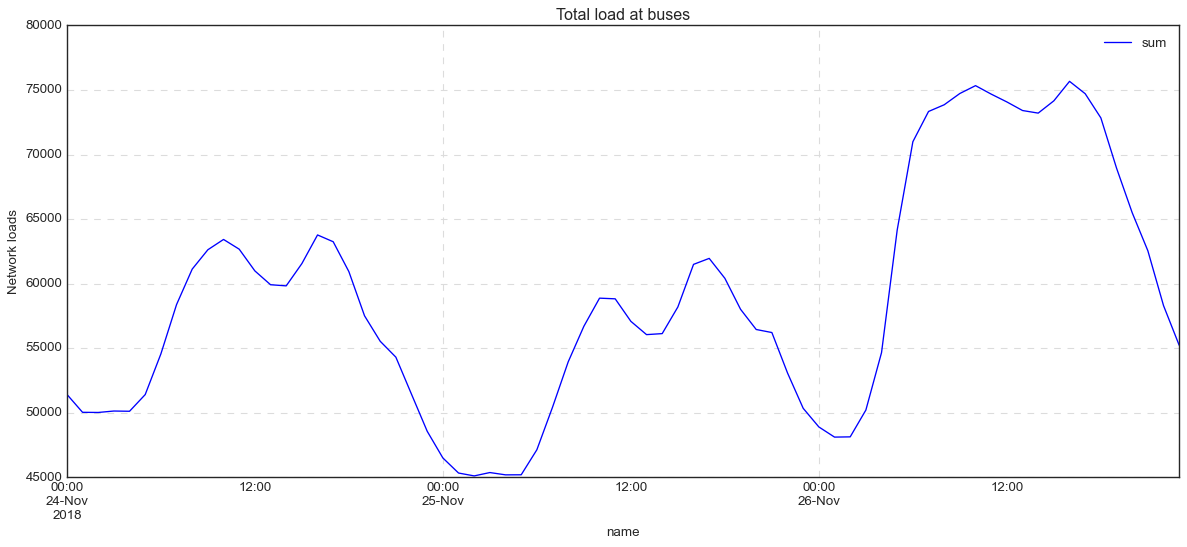

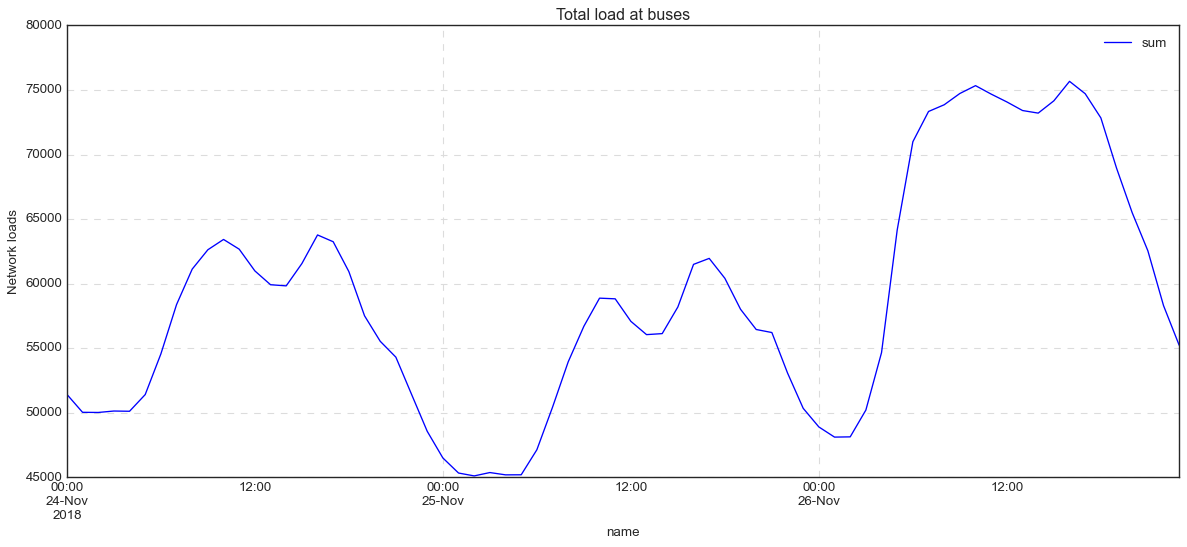

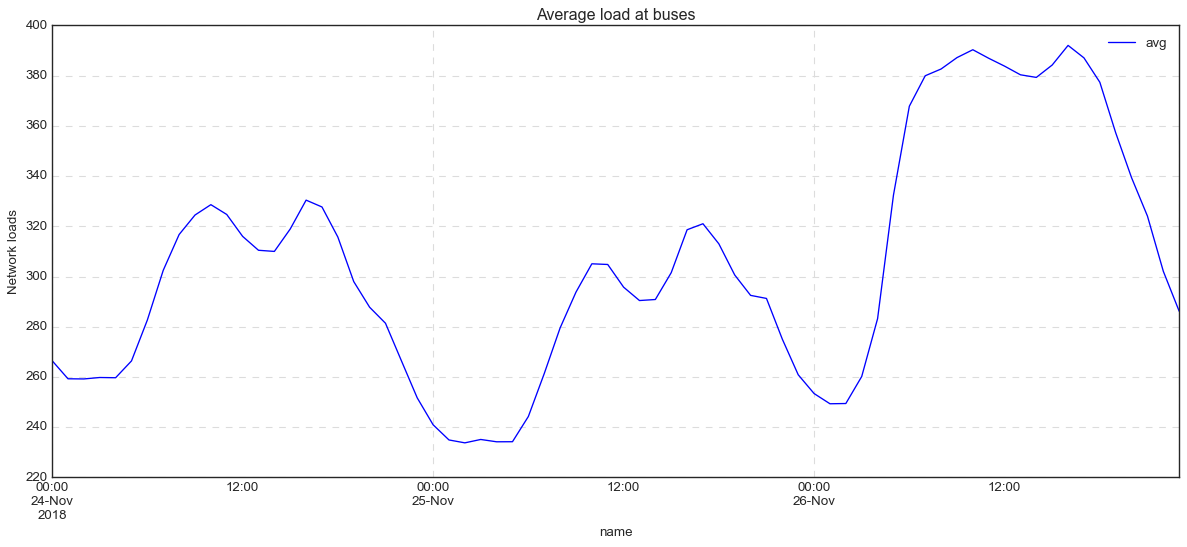

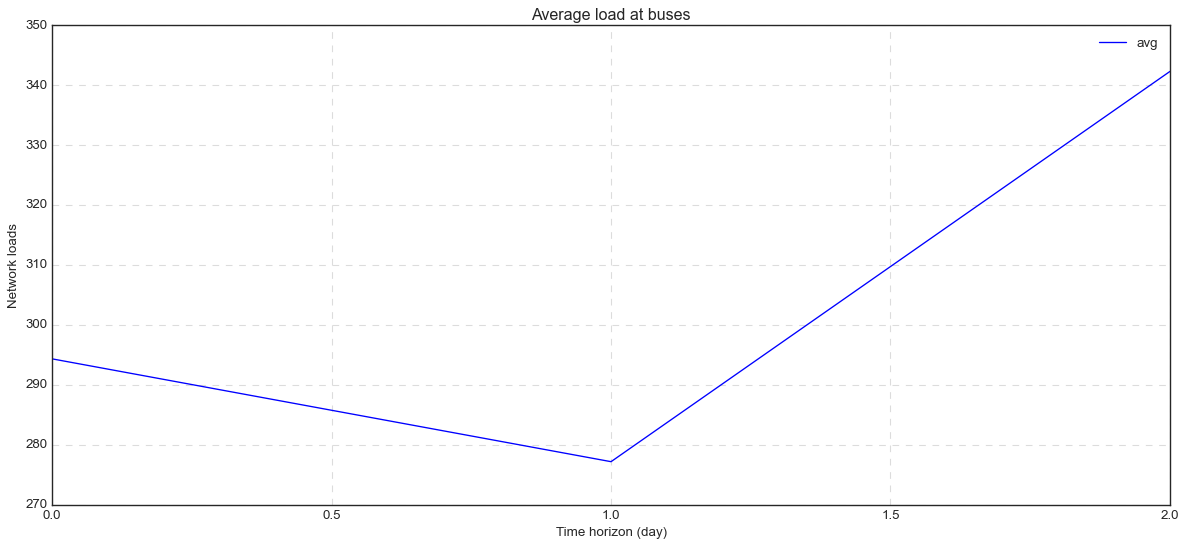

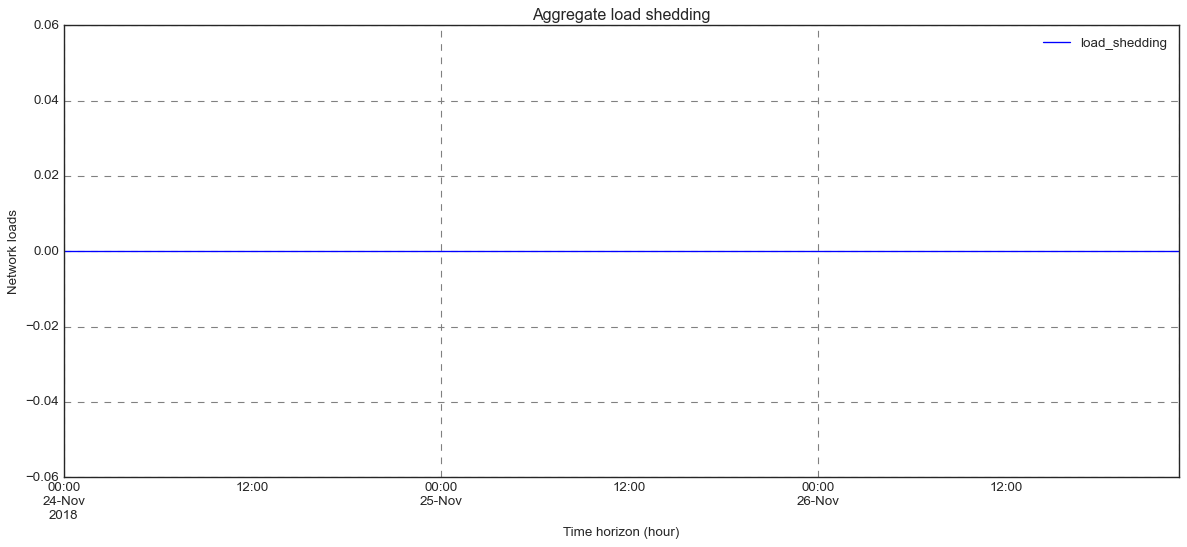

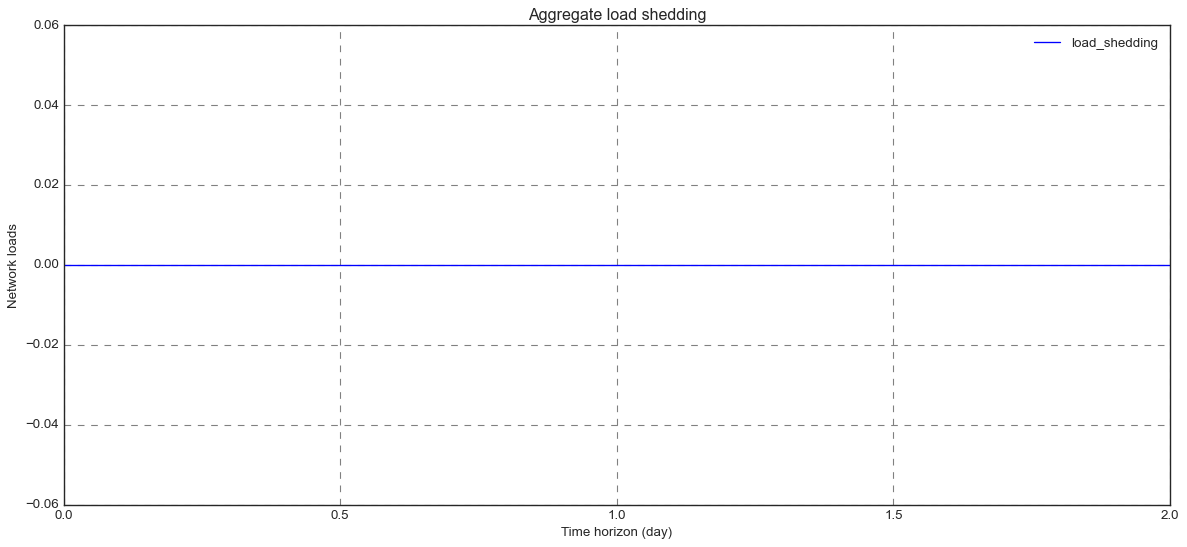

In [102]:
# Plot load analysis
# ------------------


# Hourly load SUM in germany
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p["sum"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Total load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Hourly load SUM in germany
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p_bat["sum"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Total load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Average load in germany
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Average load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Average load in germany DAILY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p_day["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Average load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot aggregated load shedding 
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_gen_shed["load_shedding"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot aggregated load shedding DAY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_gen_shed_day["load_shedding"].iloc[:-1].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Plot regionalization of analysis outcomes

name
1      0.278971
10     0.119482
100    0.221126
101    0.419001
102    0.126335
         ...   
95     0.543596
96     0.152194
97     0.299257
98     0.319937
99     0.364676
Length: 287, dtype: float64
name
1      0.279237
10     0.119400
100    0.220016
101    0.418925
102    0.126624
         ...   
95     0.543817
96     0.151878
97     0.298600
98     0.319999
99     0.364754
Length: 287, dtype: float64


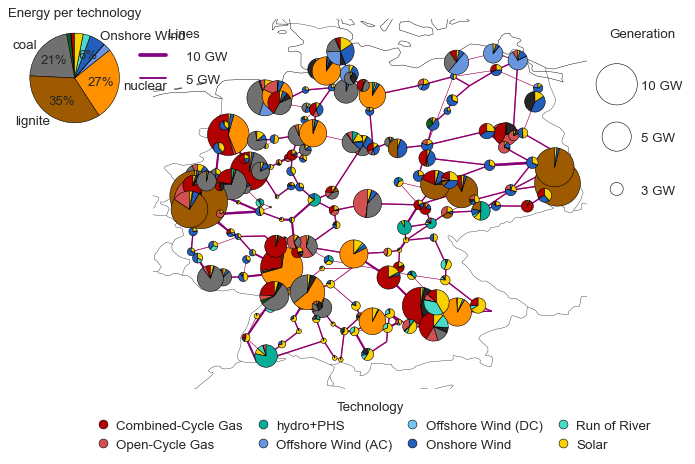

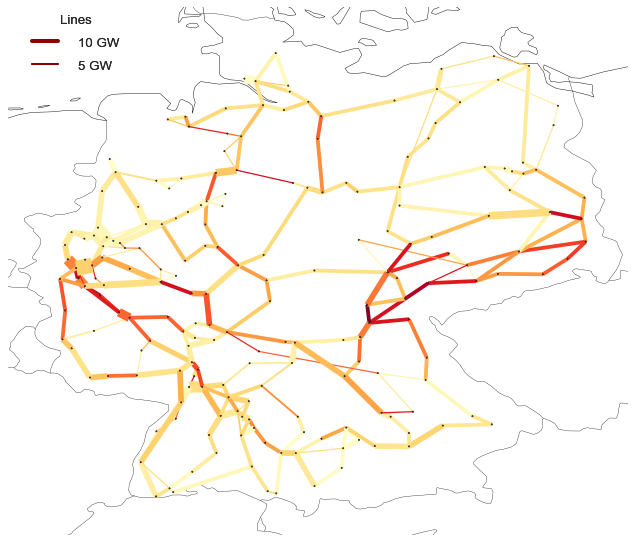

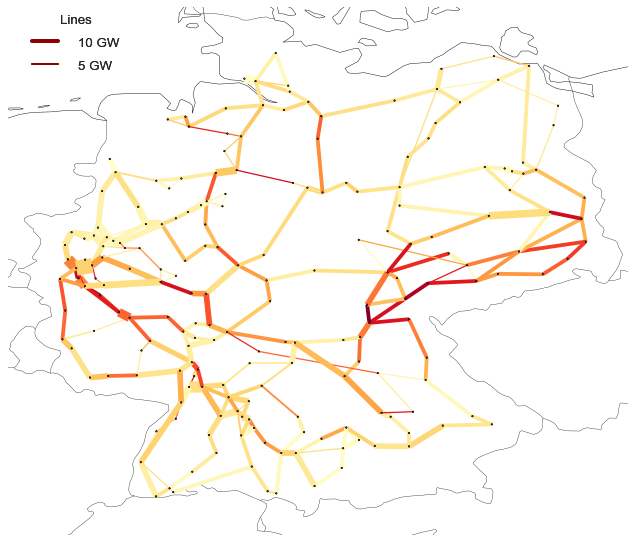

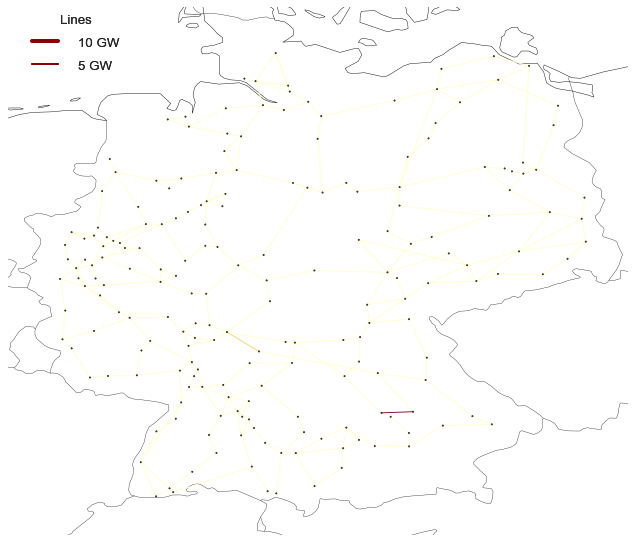

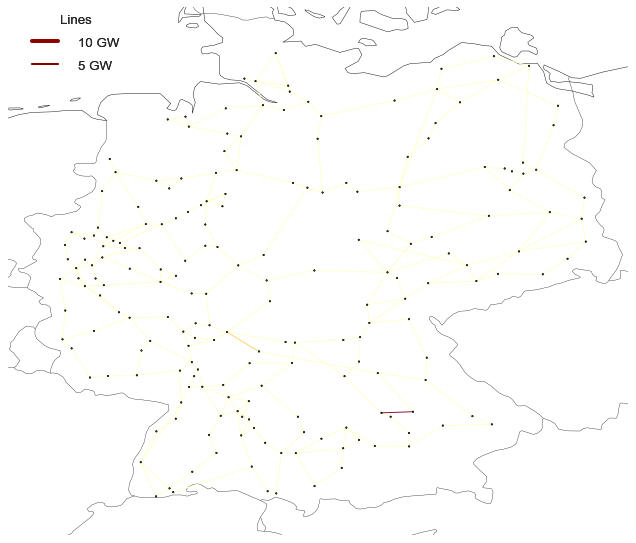

In [162]:
# SPDX-FileCopyrightText: : 2017-2020 The PyPSA-Eur Authors
#
# SPDX-License-Identifier: GPL-3.0-or-later

"""
Plots map with pie charts and cost box bar charts.

"""


import logging
import sys
# sys.path.append("C:\\Users\\Willem\\pypsa-eur\\scripts")
from _helpers import (mock_snakemake, aggregate_p, aggregate_costs)

import pandas as pd
import numpy as np
from six.moves import zip

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
to_rgba = mpl.colors.colorConverter.to_rgba

logger = logging.getLogger(__name__)

def load_network_for_plots(n_rd, config, combine_hydro_ps=True):
    import pypsa
    n = n_rd
    n.loads["carrier"] = n.loads.bus.map(n.buses.carrier) + " load"
    n.stores["carrier"] = n.stores.bus.map(n.buses.carrier)
    n.links["carrier"] = (n.links.bus0.map(n.buses.carrier) + "-" + n.links.bus1.map(n.buses.carrier))
    n.lines["carrier"] = "AC line"
    n.transformers["carrier"] = "AC transformer"
    n.lines['s_nom'] = n.lines['s_nom_min']
    n.links['p_nom'] = n.links['p_nom_min']
    if combine_hydro_ps:
        n.storage_units.loc[n.storage_units.carrier.isin({'PHS', 'hydro'}), 'carrier'] = 'hydro+PHS'
    # if the carrier was not set on the heat storage units
    # bus_carrier = n.storage_units.bus.map(n.buses.carrier)
    # n.storage_units.loc[bus_carrier == "heat","carrier"] = "water tanks"
    Nyears = n.snapshot_weightings.sum() / 8760.
    #costs = load_costs(Nyears, tech_costs, config['costs'], config['electricity'])
    #update_transmission_costs(n, costs)
    return n

def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (72./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

def set_plot_style():
    plt.style.use(['classic', 'seaborn-white',
                {'axes.grid': False, 'grid.linestyle': '--', 'grid.color': u'0.6',
                    'hatch.color': 'white',
                    'patch.linewidth': 0.5,
                    'font.size': 12,
                    'legend.fontsize': 12,
                    'lines.linewidth': 1.8,
                    'pdf.fonttype': 42}])

def plot_map(n, ax=None, attribute='p_nom', opts={}):
    if ax is None:
        ax = plt.gca()

    ## DATA
    line_colors = {'cur': "purple",
                   'exp': mpl.colors.rgb2hex(to_rgba("red", 0.7), True)}
    tech_colors = opts['tech_colors']

    if attribute == 'p_nom':
        # bus_sizes = n.generators_t.p.sum().loc[n.generators.carrier == "load"].groupby(n.generators.bus).sum()
        bus_sizes = pd.concat((n.generators.query('carrier != "load"').groupby(['bus', 'carrier']).p_nom_opt.sum(),
                               n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()))
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
    else:
        raise 'plotting of {} has not been implemented yet'.format(attribute)


    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))

    ## FORMAT
    linewidth_factor = opts['map'][attribute]['linewidth_factor']
    bus_size_factor  = opts['map'][attribute]['bus_size_factor']

    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor,
           link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'],
           link_colors=line_colors['exp'],
           bus_sizes=bus_sizes/bus_size_factor,
           bus_colors=tech_colors,
           boundaries=map_boundaries,
           geomap=True,
           ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor,
           link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='purple',
           link_colors='purple',
           bus_sizes=0,
           boundaries=map_boundaries,
           geomap=False,
           ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    # --------------
    
    # Legend for Lines
    # ----------------
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.2, 1.01), 
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    ax.add_artist(l1_1)
    
    # Legend for energy pies
    # ----------------------
    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=bus_size_factor, facecolor="w")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(1.01, 1.01),
                frameon=False, labelspacing=3,
                title='Generation',
                handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)
    techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
                handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')
    return fig

def plot_total_energy_pie(n, ax=None):
    if ax is None: ax = plt.gca()
    ax.set_title('Energy per technology', fontdict=dict(fontsize="medium"))
    e_primary = aggregate_p(n).drop('load', errors='ignore').loc[lambda s: s>0]
    patches, texts, autotexts = ax.pie(e_primary,
        startangle=90,
        labels = e_primary.rename(opts['nice_names']).index,
        autopct='%.0f%%',
        shadow=False,
        colors = [opts['tech_colors'][tech] for tech in e_primary.index])
    for t1, t2, i in zip(texts, autotexts, e_primary.index):
        if e_primary.at[i] < 0.04 * e_primary.sum():
            t1.remove()
            t2.remove()


def plot_line_loadings(network_rd, config, axe, opts={}):
    """
    Function to plot the average line loadings of lines on a map
    """
    set_plot_style()
    n = load_network_for_plots(network_rd, config)
    
    ## DATA
    tech_colors = opts['tech_colors']
    loading = (n.lines_t.p0.abs().mean().sort_index() / (n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)
    print(loading)
    # in case cmap needs to be reversed
    cmap_reversed = plt.cm.get_cmap("nipy_spectral")

    # Plot network
    n.plot(line_widths=n.lines.s_nom_opt/1e3,
           link_widths=0.8,
           line_colors = loading,
           line_cmap= "YlOrRd",
           link_colors='purple',
           bus_colors ="grey",
           bus_sizes=0.0001,
           boundaries=map_boundaries,
           geomap=True,
           ax=axe)
    axe.set_aspect('equal')
    axe.axis('off')
                                           
    # Rasterize basemap
    for c in axe.collections[:2]: c.set_rasterized(True)
    
    # Legend for Lines
    # ----------------
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color="darkred", linewidth=s*1e3/3e3))
        labels.append("{} GW".format(s))
    l1_1 = axe.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.2, 1.01),
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    axe.add_artist(l1_1)
    
    return fig


def plot_shadow_prices(network_rd, config, axe, opts={}):
    """
    Function to plot the average shadow costs on each line
    """
    set_plot_style()
    n = load_network_for_plots(network_rd, config)
    
    ## DATA
    tech_colors = opts['tech_colors']
    shadow_cost = abs(n.lines_t.mu_upper.mean().sort_index())

    # in case cmap needs to be reversed
    cmap_reversed = plt.cm.get_cmap("nipy_spectral")

    # Plot network
    n.plot(line_widths=0.8,
           link_widths=n.links.p_nom/3e3,
           line_colors = shadow_cost,
           line_cmap= "YlOrRd",
           link_colors='purple',
           bus_colors ="grey",
           bus_sizes=0.0001,
           boundaries=map_boundaries,
           geomap=True,
           ax=axe)
    axe.set_aspect('equal')
    axe.axis('off')
                                           
    # Rasterize basemap
    for c in axe.collections[:2]: c.set_rasterized(True)
    
    # Legend for Lines
    # ----------------
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color="darkred", linewidth=s*1e3/3e3))
        labels.append("{} GW".format(s))
    l1_1 = axe.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.2, 1.01),
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    axe.add_artist(l1_1)
    
    return fig                                        



# jupyter notebook has to be run from cd\users/willem/pypsa-eur/scripts
# Set plotting options:
# -----------------
snakemake = mock_snakemake('plot_network', network='elec', simpl='300', clusters='50', ll='copt', opts='1H-noex',
                           attr='p_nom', ext="pdf")
set_plot_style()
opts = snakemake.config['plotting']
map_figsize = opts['map']['figsize']
map_boundaries = [5.7, 15.1, 47,  55]
scenario_opts = snakemake.wildcards.opts.split('-')

# ----------------
# PLOTS
# ----------------

n = load_network_for_plots(network_rd, snakemake.config)

# Plot in figure
fig, ax = plt.subplots(figsize=map_figsize, subplot_kw={"projection": ccrs.PlateCarree()})
plot_map(n, ax, snakemake.wildcards.attr, opts)
# Plot energy map
ax1 = fig.add_axes([-0.115, 0.625, 0.2, 0.2])
plot_total_energy_pie(n, ax1)
                                           
# Plot spatial line loadings
fig, ax2 = plt.subplots(figsize=(10,10), subplot_kw={"projection": ccrs.PlateCarree()})
fig = plot_line_loadings(network_rd, snakemake.config, ax2, opts)
fig, ax2_ = plt.subplots(figsize=(10,10), subplot_kw={"projection": ccrs.PlateCarree()})
fig = plot_line_loadings(network_rd_bat4h, snakemake.config, ax2_, opts)

# Plot spatial shadow prices
fig, ax3 = plt.subplots(figsize=(10,10), subplot_kw={"projection": ccrs.PlateCarree()})
fig = plot_shadow_prices(network_rd, snakemake.config, ax3, opts)
fig, ax3_ = plt.subplots(figsize=(10,10), subplot_kw={"projection": ccrs.PlateCarree()})
fig = plot_shadow_prices(network_rd_bat4h, snakemake.config, ax3_, opts)


#fig.savefig(snakemake.output.only_map, dpi=150, bbox_inches='tight')
#fig.savefig(snakemake.output.ext, transparent=True, bbox_inches='tight')

INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


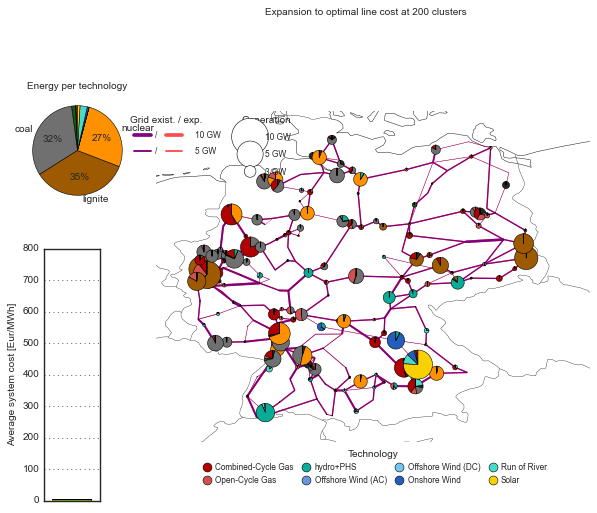

In [84]:
# SPDX-FileCopyrightText: : 2017-2020 The PyPSA-Eur Authors
#
# SPDX-License-Identifier: GPL-3.0-or-later

"""
Plots map with pie charts and cost box bar charts.

Relevant Settings
-----------------

Inputs
------

Outputs
-------

Description
-----------

"""

"""import os
abspath = os.path.abspath(__file__)
#abspath = '/Users/chiara/Documents/Universitaet/Master/MASTERARBEIT/pypsa-eur/scripts/'
dname = os.path.dirname(abspath)
os.chdir(dname)"""
#
import logging
from _helpers import (load_network_for_plots, aggregate_p, aggregate_costs,
                      configure_logging)
#
import pandas as pd
import numpy as np
from six.moves import zip

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
to_rgba = mpl.colors.colorConverter.to_rgba

logger = logging.getLogger(__name__)
#
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (72./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

def set_plot_style():
    plt.style.use(['classic', 'seaborn-white',
                {'axes.grid': False, 'grid.linestyle': '--', 'grid.color': u'0.6',
                    'hatch.color': 'white',
                    'patch.linewidth': 0.5,
                    'font.size': 9,
                    'legend.fontsize': 'small',
                    'lines.linewidth': 1.5,
                    'pdf.fonttype': 42,
                }])

def plot_map(n, ax=None, attribute='p_nom', opts={}):
    if ax is None:
        ax = plt.gca()

    ## DATA
    line_colors = {'cur': "purple",
                   'exp': mpl.colors.rgb2hex(to_rgba("red", 0.7), True)}
    tech_colors = opts['tech_colors']

    if attribute == 'p_nom':
        # bus_sizes = n.generators_t.p.sum().loc[n.generators.carrier == "load"].groupby(n.generators.bus).sum()
        bus_sizes = pd.concat((n.generators.query('carrier != "load"').groupby(['bus', 'carrier']).p_nom_opt.sum(),
                               n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()))
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
    else:
        raise 'plotting of {} has not been implemented yet'.format(attribute)


    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))

    ## FORMAT
    linewidth_factor = opts['map'][attribute]['linewidth_factor']
    bus_size_factor  = opts['map'][attribute]['bus_size_factor']

    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor,
           link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'],
           link_colors=line_colors['exp'],
           bus_sizes=bus_sizes/bus_size_factor,
           bus_colors=tech_colors,
           boundaries=map_boundaries,
           geomap=True,
           ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor,
           link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='purple',
           link_colors='purple',
           bus_sizes=0,
#           bus_colors=tech_colors,
           boundaries=map_boundaries,
           geomap=False,
           ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    # TODO : Check if this also works with cartopy
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['exp'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.25, 1.01),
                     frameon=False,
                     labelspacing=0.8, handletextpad=1.5,
                     title='Grid exist. / exp.                    ')
    ax.add_artist(l1_1)

    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("/")
    l1_2 = ax.legend(handles, labels,
                loc="upper right", bbox_to_anchor=(0.02, 1.01),
                frameon=False,
                labelspacing=0.8, handletextpad=0.5,
                title=' ')
    ax.add_artist(l1_2)

    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=bus_size_factor, facecolor="w")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(0.18, 1.01),
                frameon=False, labelspacing=1.0,
                title='Generation',
                handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)

    techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
                handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')

    return fig
#

def plot_total_energy_pie(n, ax=None):
    if ax is None: ax = plt.gca()

    ax.set_title('Energy per technology', fontdict=dict(fontsize="medium"))

    e_primary = aggregate_p(n).drop('load', errors='ignore').loc[lambda s: s>0]

    patches, texts, autotexts = ax.pie(e_primary,
        startangle=90,
        labels = e_primary.rename(opts['nice_names']).index,
        autopct='%.0f%%',
        shadow=False,
        colors = [opts['tech_colors'][tech] for tech in e_primary.index])
    for t1, t2, i in zip(texts, autotexts, e_primary.index):
        if e_primary.at[i] < 0.04 * e_primary.sum():
            t1.remove()
            t2.remove()

def plot_total_cost_bar(n, ax=None):
    if ax is None: ax = plt.gca()

    total_load = (n.snapshot_weightings * n.loads_t.p.sum(axis=1)).sum()
    tech_colors = opts['tech_colors']

    def split_costs(n):
        costs = aggregate_costs(n).reset_index(level=0, drop=True)
        costs_ex = aggregate_costs(n, existing_only=True).reset_index(level=0, drop=True)
        return (costs['capital'].add(costs['marginal'], fill_value=0.),
                costs_ex['capital'], costs['capital'] - costs_ex['capital'], costs['marginal'])

    costs, costs_cap_ex, costs_cap_new, costs_marg = split_costs(n)

    costs_graph = pd.DataFrame(dict(a=costs.drop('load', errors='ignore')),
                            index=['AC-AC', 'AC line', 'onwind', 'offwind-ac',
                                   'offwind-dc', 'solar', 'OCGT','CCGT', 'battery', 'H2']).dropna()
    bottom = np.array([0., 0.])
    texts = []

    for i,ind in enumerate(costs_graph.index):
        data = np.asarray(costs_graph.loc[ind])/total_load
        ax.bar([0.5], data, bottom=bottom, color=tech_colors[ind],
               width=0.7, zorder=-1)
        bottom_sub = bottom
        bottom = bottom+data

        if ind in opts['conv_techs'] + ['AC line']:
            for c in [costs_cap_ex, costs_marg]:
                if ind in c:
                    data_sub = np.asarray([c.loc[ind]])/total_load
                    ax.bar([0.5], data_sub, linewidth=0,
                        bottom=bottom_sub, color=tech_colors[ind],
                        width=0.7, zorder=-1, alpha=0.8)
                    bottom_sub += data_sub

        if abs(data[-1]) < 5:
            continue

        text = ax.text(1.1,(bottom-0.5*data)[-1]-3,opts['nice_names'].get(ind,ind))
        texts.append(text)

    ax.set_ylabel("Average system cost [Eur/MWh]")
    ax.set_ylim([0, opts.get('costs_max', 80)])
    ax.set_xlim([0, 1])
    ax.set_xticklabels([])
    ax.grid(True, axis="y", color='k', linestyle='dotted')
#%%
from _helpers import mock_snakemake
snakemake = mock_snakemake('plot_network', network='elec', simpl='300',
                          clusters='200', ll='copt', opts='1H-noex',
                          attr='p_nom', ext="pdf")
configure_logging(snakemake)
set_plot_style()
#
opts = snakemake.config['plotting']
map_figsize = opts['map']['figsize']
map_boundaries = opts['map']['boundaries']
#
n = load_network_for_plots(snakemake.input.network, snakemake.input.tech_costs, snakemake.config)
#
scenario_opts = snakemake.wildcards.opts.split('-')
#
fig, ax = plt.subplots(figsize=map_figsize, subplot_kw={"projection": ccrs.PlateCarree()})
#
plot_map(n, ax, snakemake.wildcards.attr, opts)
#
fig.savefig(snakemake.output.only_map, dpi=150, bbox_inches='tight')
#%%
ax1 = fig.add_axes([-0.115, 0.625, 0.2, 0.2])
plot_total_energy_pie(n, ax1)

ax2 = fig.add_axes([-0.075, 0.1, 0.1, 0.45])
plot_total_cost_bar(n, ax2)
#
ll = snakemake.wildcards.ll
ll_type = ll[0]
ll_factor = ll[1:]
lbl = dict(c='line cost', v='line volume')[ll_type]
amnt = '{ll} x today\'s'.format(ll=ll_factor) if ll_factor != 'opt' else 'optimal'
fig.suptitle('Expansion to {amount} {label} at {clusters} clusters'
            .format(amount=amnt, label=lbl, clusters=snakemake.wildcards.clusters))

fig.savefig(snakemake.output.ext, transparent=True, bbox_inches='tight')
#


# Compare redispatch in multiple-node networks -> check whether it converges

In [78]:
# Load multiple solved DISPATCH networks from networks_redispatch folder
folder = "C:\\Users\\Willem\\pypsa-eur\\networks_redispatch\\solved"

# n10 =   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_10_ec_lcopt_1H-noex.nc")
# n30 =   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_30_ec_lcopt_1H-noex.nc")
# n50 =   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_50_ec_lcopt_1H-noex.nc")
# n80 =   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_80_ec_lcopt_1H-noex.nc")
# n90 =   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_90_ec_lcopt_1H-noex.nc")
# n100 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_100_ec_lcopt_1H-noex.nc")
# n110 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_110_ec_lcopt_1H-noex.nc")
# n120 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_120_ec_lcopt_1H-noex.nc")
# n130 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_130_ec_lcopt_1H-noex.nc")
# n140 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_140_ec_lcopt_1H-noex.nc")
# n150 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_150_ec_lcopt_1H-noex.nc")
# n160 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_160_ec_lcopt_1H-noex.nc")
# n170 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_170_ec_lcopt_1H-noex.nc")
# n180 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_180_ec_lcopt_1H-noex.nc")
# n190 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_190_ec_lcopt_1H-noex.nc")
n200 =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_200_ec_lcopt_1H-noex.nc")


INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


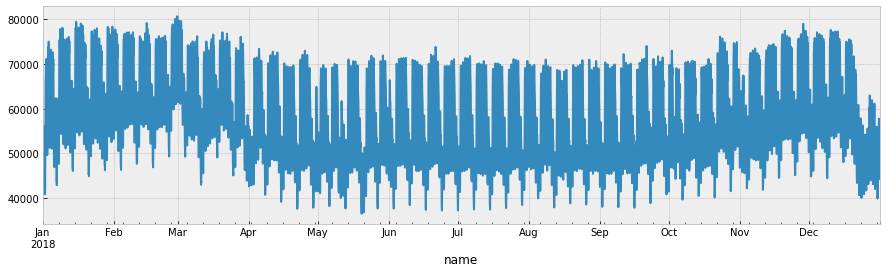

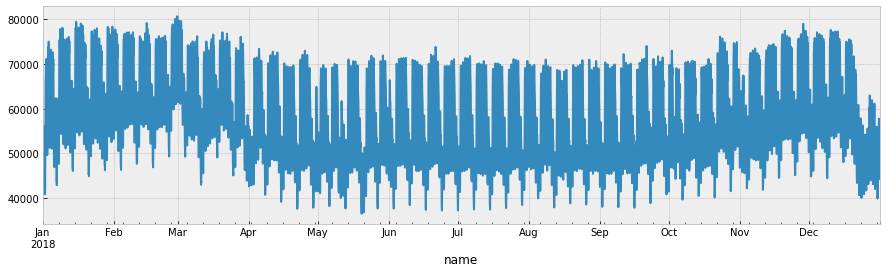

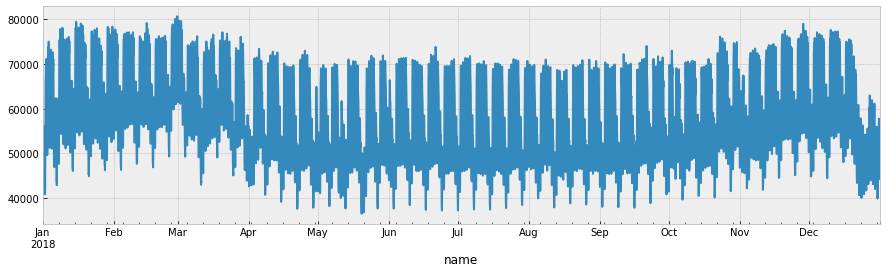

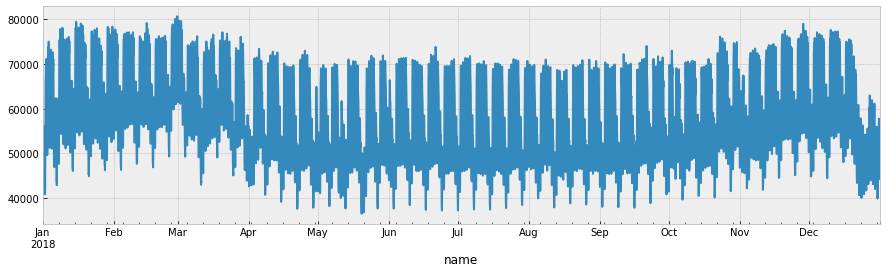

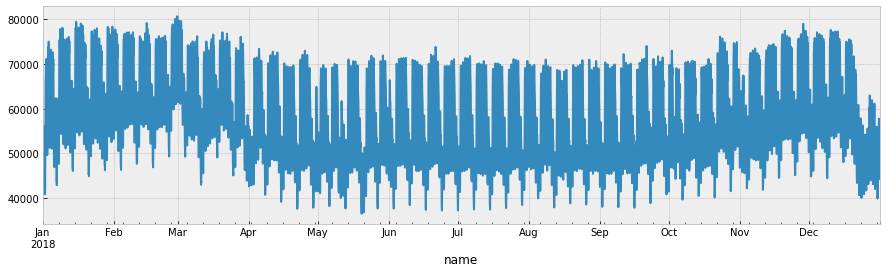

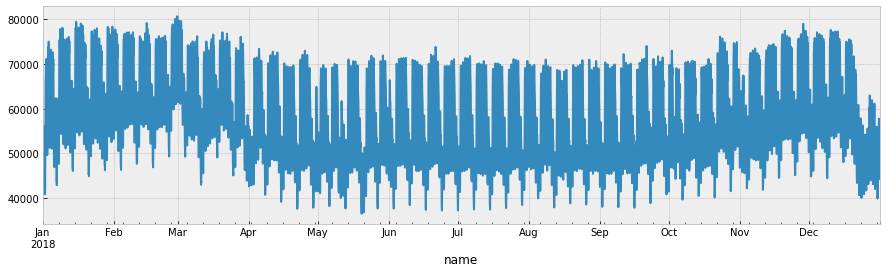

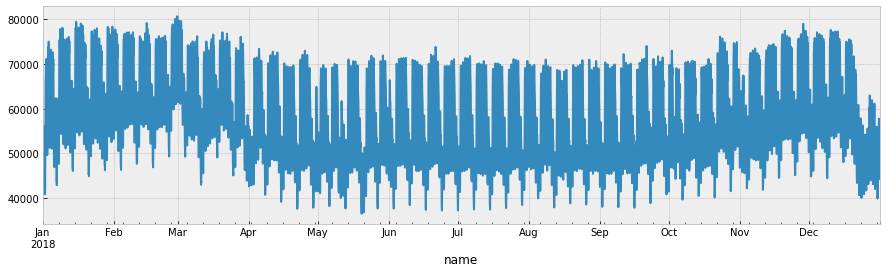

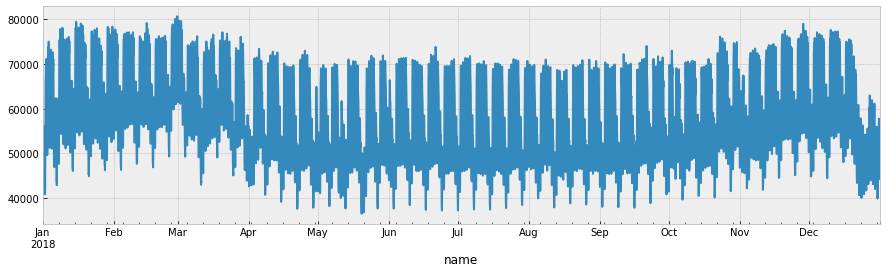

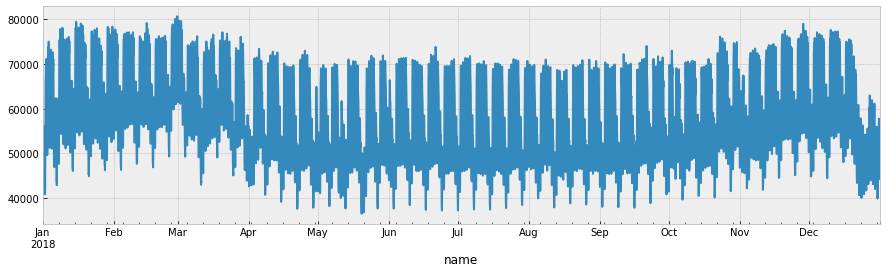

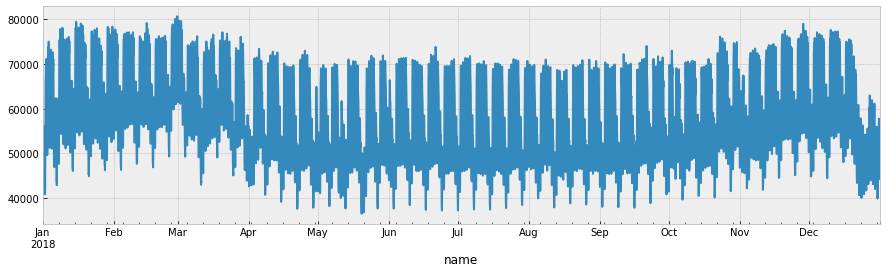

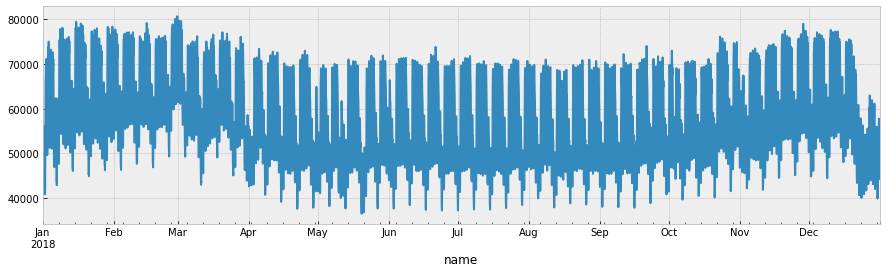

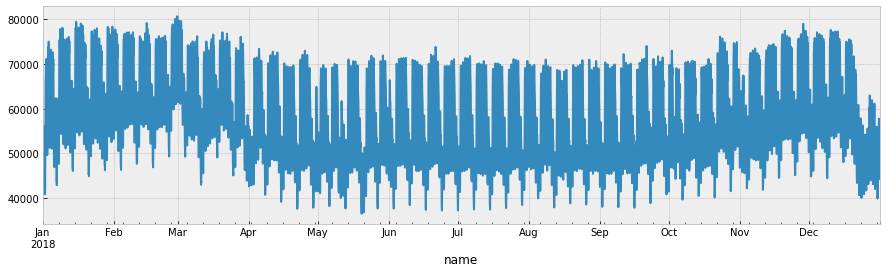

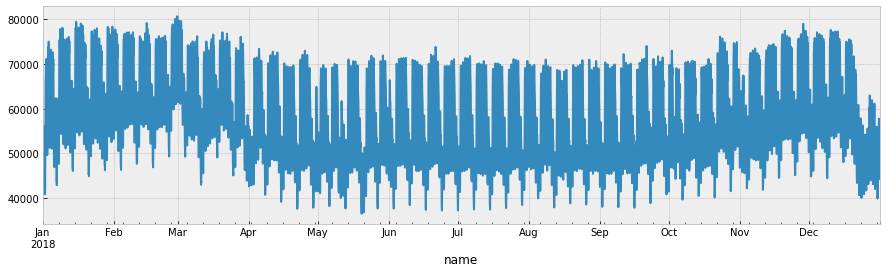

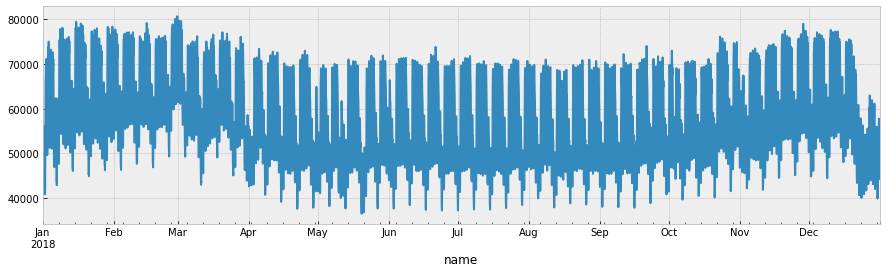

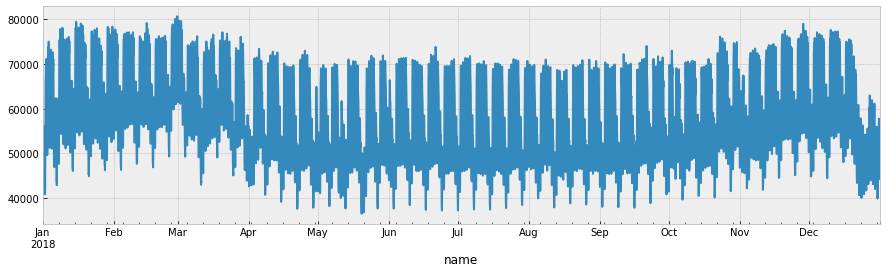

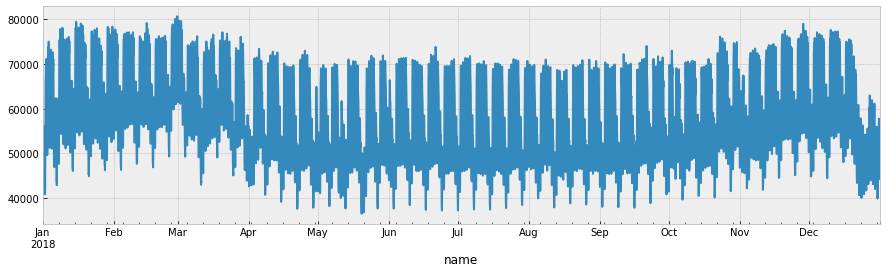

In [5]:
n10.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
plt.show()
n30.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
plt.show()
n50.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
plt.show()
n80.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
plt.show()
n90.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
plt.show()
n100.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n110.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n120.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n130.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n140.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n150.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n160.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n170.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n180.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n190.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()
n200.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
plt.show()

In [5]:
# n10_rd=   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_10_ec_lcopt_1H-noex.nc")
# n30_rd=   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_30_ec_lcopt_1H-noex.nc")
# n50_rd=   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_50_ec_lcopt_1H-noex.nc")
# n80_rd=   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_80_ec_lcopt_1H-noex.nc")
# n90_rd=   pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_90_ec_lcopt_1H-noex.nc")
# n100_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_100_ec_lcopt_1H-noex.nc")
# n110_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_110_ec_lcopt_1H-noex.nc")
# n120_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_120_ec_lcopt_1H-noex.nc")
# n130_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_130_ec_lcopt_1H-noex.nc")
# n140_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_140_ec_lcopt_1H-noex.nc")
# n150_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_150_ec_lcopt_1H-noex.nc")
# n160_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_160_ec_lcopt_1H-noex.nc")
# n170_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_170_ec_lcopt_1H-noex.nc")
# n180_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_180_ec_lcopt_1H-noex.nc")
# n190_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_190_ec_lcopt_1H-noex.nc")
n200_rd =  pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\Willem\\pypsa-eur\\networks_redispatch\\results\\redispatch\\elec_s300_200_ec_lcopt_1H-noex.nc'

In [11]:
# n10_rd.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
# plt.show()
# n30_rd.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
# plt.show()
# n50_rd.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
# plt.show()
# n80_rd.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
# plt.show()
# n90_rd.loads_t.p.sum(axis = 1).plot(figsize= (15,4))
# plt.show()
# n100_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n110_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n120_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n130_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n140_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n150_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n160_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n170_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n180_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n190_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()
# n200_rd.loads_t.p.sum(axis = 1).plot(figsize=(15,4))
# plt.show()

In [12]:
# Check whether redispatch costs converge:
# ---------------------------

# df_n10 , df_n10_day, df_n10_week  = analyze_objective_rd(n10_rd)
# df_n30 , df_n30_day, df_n30_week  = analyze_objective_rd(n30_rd)
# df_n50 , df_n50_day, df_n50_week  = analyze_objective_rd(n50_rd)
# df_n80 , df_n80_day, df_n80_week  = analyze_objective_rd(n80_rd)
# df_n90 , df_n90_day, df_n90_week  = analyze_objective_rd(n90_rd)
# df_n100, df_n100_day, df_n100_week = analyze_objective_rd(n100_rd)
# df_n110, df_n110_day, df_n110_week = analyze_objective_rd(n110_rd)
# df_n120, df_n120_day, df_n120_week = analyze_objective_rd(n120_rd)
# df_n130, df_n130_day, df_n130_week = analyze_objective_rd(n130_rd)
# df_n140, df_n140_day, df_n140_week = analyze_objective_rd(n140_rd)
# df_n150, df_n150_day, df_n150_week = analyze_objective_rd(n150_rd)
# df_n160, df_n160_day, df_n160_week = analyze_objective_rd(n160_rd)
# df_n170, df_n170_day, df_n170_week = analyze_objective_rd(n170_rd)
# df_n180, df_n180_day, df_n180_week = analyze_objective_rd(n180_rd)
# df_n190, df_n190_day, df_n190_week = analyze_objective_rd(n190_rd)
df_n200, df_n200_day, df_n200_week = analyze_objective_rd(n200_rd)

# list_rd_day = [df_n10_day, df_n30_day, df_n50_day, df_n80_day, df_n90_day, df_n100_day, df_n110_day, df_n120_day, 
#                df_n130_day, df_n140_day, df_n150_day, df_n160_day, df_n170_day, df_n180_day, df_n190_day, df_n200_day]
# list_rd_week = [df_n10_week, df_n30_week, df_n50_week, df_n80_week,  df_n90_week, df_n100_week, df_n110_week, df_n120_week,
#                 df_n130_week, df_n140_week, df_n150_week, df_n160_week, df_n170_week, df_n180_week, df_n190_week, df_n200_week]
# list_obj_values = [ n10_rd.objective, n30_rd.objective, n50_rd.objective, n80_rd.objective, n90_rd.objective, n100_rd.objective,
#                     n110_rd.objective, n120_rd.objective, n130_rd.objective, n140_rd.objective, n150_rd.objective, n160_rd.objective, n170_rd.objective,
#                     n180_rd.objective, n190_rd.objective, n200_rd.objective]

# # Create dataframes for direct comparison of rd costs of each network
# # --------------------------

# # concat the DAILY ramp up cost of each network
# df_all_rd_day = pd.concat(list_rd_day, axis = 1)
# df_all_rd_day_ramp = df_all_rd_day["sum_ramp_cost"]
# df_all_rd_day_ramp.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]
# # concat the DAILY curtailment cost of each network
# df_all_rd_day_curtail = df_all_rd_day["sum_curtailment_cost"]
# df_all_rd_day_curtail.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]
# # concat the DAILY total redispatch cost of each network
# df_all_rd_day_total = df_all_rd_day["redispatch_cost"]
# df_all_rd_day_total.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]

# # concat the WEEKLY ramp up cost of each network
# df_all_rd_week = pd.concat(list_rd_week, axis = 1)
# df_all_rd_week_ramp = df_all_rd_week["sum_ramp_cost"]
# df_all_rd_week_ramp.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]
# # concat the WEEKLY curtailment cost of each network
# df_all_rd_week_curtail = df_all_rd_week["sum_curtailment_cost"]
# df_all_rd_week_curtail.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]
# # concat the WEEKLY total redispatch cost of each network
# df_all_rd_week_total = df_all_rd_week["redispatch_cost"]
# df_all_rd_week_total.columns = ["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"]

# # Redispatch cost "elbow curve"
# s_obj_values = pd.Series(list_obj_values, index=["10 buses","30 buses","50 buses","80 buses","90 buses","100 buses","110 buses","120 buses",
#                               "130 buses","140 buses","150 buses","160 buses","170 buses","180 buses","190 buses","200 buses"])
# display(df_all_rd_day_total)
# display(df_all_rd_week_total)
# display(s_obj_values)



377320447.2299688


## Notes: Redispatch realisticity

### total redispatch volume for 2018 too large for all networks (reality: ~ 360 mio euro)
- 2 ansätze:
1.
- => increase line capacity a little bit (currently at 70% capacity, increate by 5% to 75% capacity {5 % of 100 %, that means 70% + 5%*100/70 (5 prozentPUNKTE auf 100% gerechnet, nicht 5% aufschlag ausgehend von 70%)
- rerun the redispatch simulation for every day.
2.
- identify and resolve local congestions that are unrealistically strict in the model
- plot line loading, see which lines have the highest shadow prices.
    

### Redispatch cost Verlauf:
- man sieht: redispatch costs begin to converge around 100 nodes already, but have gradual differences in the distribution based on clustering (or - in opposite) splitting of lines, leading to local congestion problems that have not been there before.
- der verlauf zeigt im segment 100 nodes einige inconsistencies -> begin bei 130 knoten
- plotting the lnetworks where it begins to converge: 130 - 200
    - man sieht: Einzelne redispatch spikes lassen nach, kurve wird graduell höher aber in den spitzen flacher
    - MAN SIEHT AUCH: am ende der simulation gibt es kosten spikes.
    - vermutlich hergeleitet aufgrund lokaler infeasibilities die nicht die realität abbilden (insbesonder im vgl mit dem realen verlauf des redispatch)
    
### Verlauf shadow prices: 
- analysis showed that 2 lines have by far the largest shadow prices, those lines have been extended to 1.0 lines in the model (previously 0.67 lines)
- capacity has been increased by 20% to account for accurate historic redispatch costs

### Changes made:
- increase line volume on unrealistically congested lines to 1 line (not 0.67) and 0.8 capacity

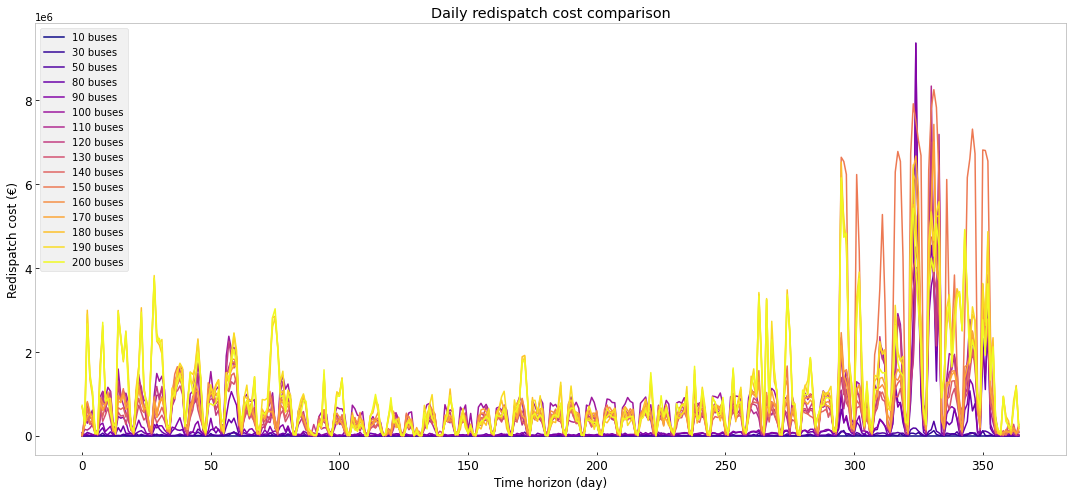

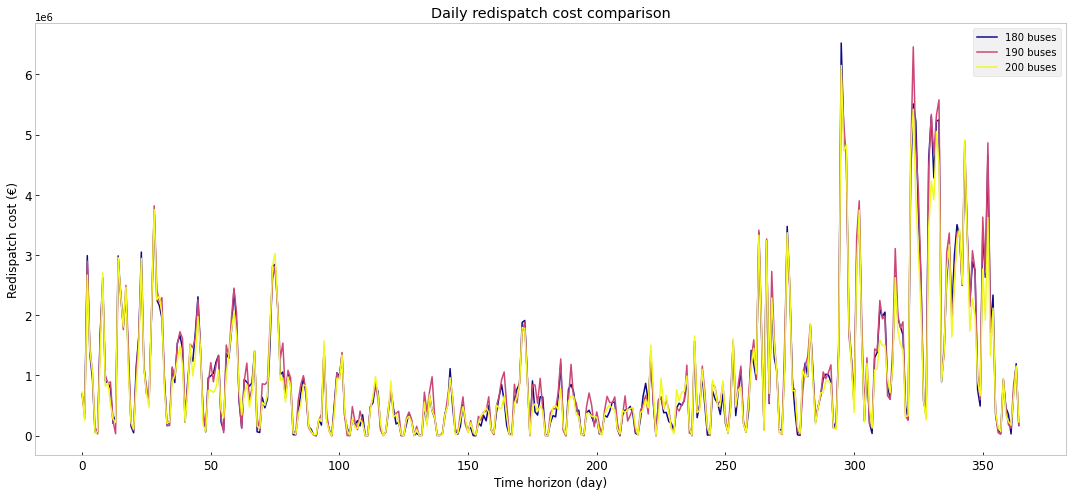

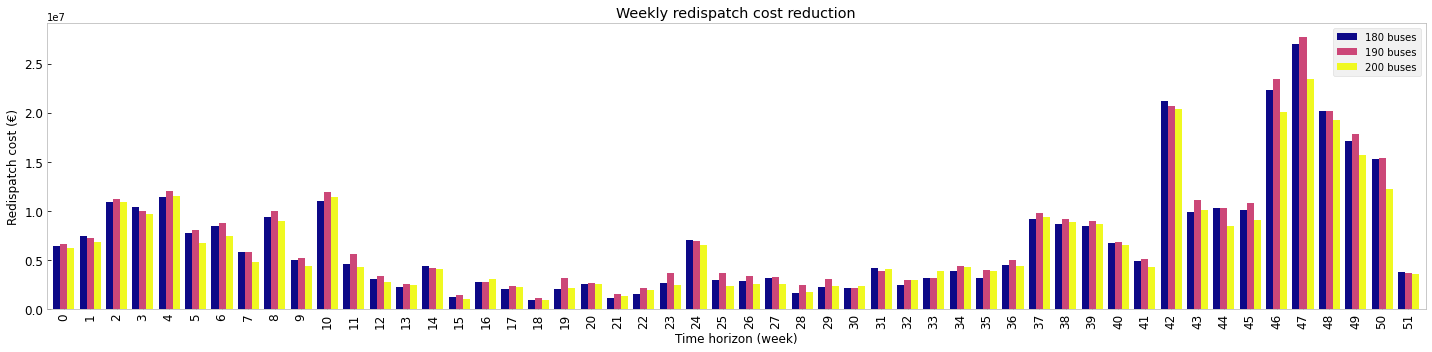

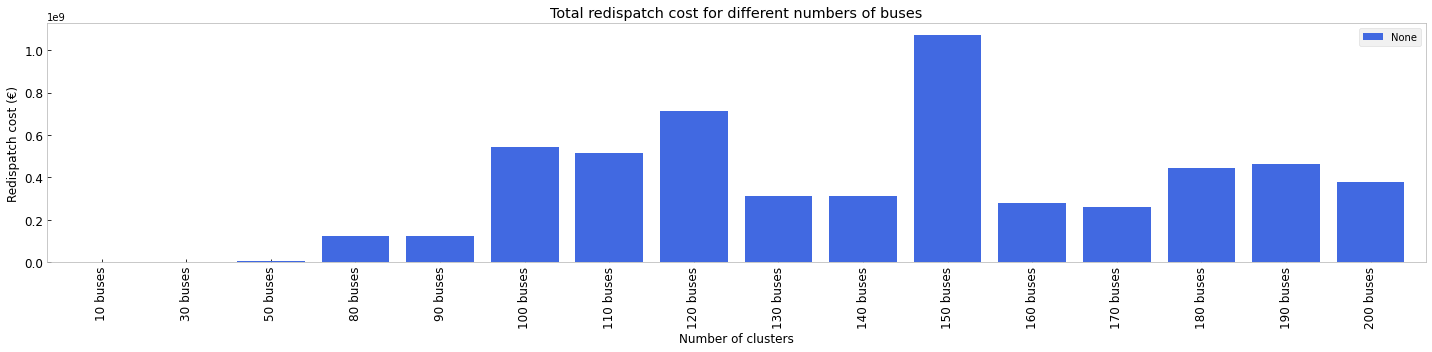

In [36]:
# Plot shape of redispatch COST curves
# ----------------------------

# Redispatch costs per day comparison
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_all_rd_day_total.plot.line(stacked = False, ax = ax, title = "Daily redispatch cost comparison", 
                                   cmap = "plasma", legend = True, linewidth = 1.5, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch costs per day comparison for largest networks (100 - 200 nodes)
fig, ax  = plt.subplots(figsize = (15, 7))
cols = ["180 buses","190 buses","200 buses"]
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_all_rd_day_total[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost comparison", 
                                   cmap = "plasma", legend = True, linewidth = 1.5, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost comparison per WEEK
fig, ax1  = plt.subplots(figsize = (20, 5))
ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax1.set_xlabel("Time horizon (week)", fontsize = 12)
ax1 = df_all_rd_week_total[cols].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   cmap = "plasma", legend = True, width = 0.8, fontsize = 12)

ax1.set_facecolor('white')
ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax1.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Elbow curve (redispatch cost depending on number of clusters)
fig, ax2  = plt.subplots(figsize = (20, 5))
ax2.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax2.set_xlabel("Number of clusters", fontsize = 12)
ax2 = s_obj_values.plot.bar(stacked = False, ax = ax2, title = "Total redispatch cost for different numbers of buses", 
                                  color = "royalblue", legend = True, width = 0.8, fontsize = 12)
ax2.set_facecolor('white')
ax2.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)
fig.tight_layout()
plt.show()

In [154]:
n200_rd.generators


weight     p_nom carrier  marginal_cost     bus  efficiency  \
name                                                                          
DE0 0 CCGT         NaN     178.3    CCGT            0.0   DE0 0       0.500   
DE0 0 CCGT_pos     NaN     178.3    CCGT           47.2   DE0 0       0.500   
DE0 0 CCGT_neg     NaN     178.3    CCGT            0.0   DE0 0       0.500   
DE0 0 coal         NaN      17.4    coal            0.0   DE0 0       0.464   
DE0 0 coal_neg     NaN      17.4    coal            0.0   DE0 0       0.464   
...                ...       ...     ...            ...     ...         ...   
load_196           NaN  100000.0    load        25000.0  DE0 95       1.000   
load_197           NaN  100000.0    load        25000.0  DE0 96       1.000   
load_198           NaN  100000.0    load        25000.0  DE0 97       1.000   
load_199           NaN  100000.0    load        25000.0  DE0 98       1.000   
load_200           NaN  100000.0    load        25000.0  DE0 99       1.000   

               control  p_nom_opt  p_max_pu type  p_nom_extendable  p_nom_min  \
name                                                                            
DE0 0 CCGT       Slack      178.3       1.0                  False        0.0   
DE0 0 CCGT_pos      PQ      178.3       1.0                  False        0.0   
DE0 0 CCGT_neg      PQ      178.3       0.0                  False        0.0   
DE0 0 coal          PQ       17.4       1.0                  False        0.0   
DE0 0 coal_neg      PQ       17.4       0.0                  False        0.0   
...                ...        ...       ...  ...               ...        ...   
load_196            PQ   100000.0       1.0                  False        0.0   
load_197            PQ   100000.0       1.0                  False        0.0   
load_198            PQ   100000.0       1.0                  False        0.0   
load_199            PQ   100000.0       1.0                  False        0.0   
load_200            PQ   100000.0       1.0                  False        0.0   

                p_nom_max  p_min_pu  p_set  q_set  sign  capital_cost  \
name                                                                    
DE0 0 CCGT            inf       0.0    0.0    0.0   1.0           0.0   
DE0 0 CCGT_pos        inf       0.0    0.0    0.0   1.0           0.0   
DE0 0 CCGT_neg        inf       0.0    0.0    0.0   1.0           0.0   
DE0 0 coal            inf       0.0    0.0    0.0   1.0           0.0   
DE0 0 coal_neg        inf       0.0    0.0    0.0   1.0           0.0   
...                   ...       ...    ...    ...   ...           ...   
load_196              inf       0.0    0.0    0.0   1.0           0.0   
load_197              inf       0.0    0.0    0.0   1.0           0.0   
load_198              inf       0.0    0.0    0.0   1.0           0.0   
load_199              inf       0.0    0.0    0.0   1.0           0.0   
load_200              inf       0.0    0.0    0.0   1.0           0.0   

                committable  start_up_cost  shut_down_cost  min_up_time  \
name                                                                      
DE0 0 CCGT            False            0.0             0.0            0   
DE0 0 CCGT_pos        False            0.0             0.0            0   
DE0 0 CCGT_neg        False            0.0             0.0            0   
DE0 0 coal            False            0.0             0.0            0   
DE0 0 coal_neg        False            0.0             0.0            0   
...                     ...            ...             ...          ...   
load_196              False            0.0             0.0            0   
load_197              False            0.0             0.0            0   
load_198              False            0.0             0.0            0   
load_199              False            0.0             0.0            0   
load_200              False            0.0             0.0            0   

        

In [106]:
g = n200.generators
display(g)
gwind = g[(g["carrier"] == "onwind") | (g["carrier"] == "offwind-ac") | (g["carrier"] == "offwind-dc")]

gsolar = g[g["carrier"]== "solar"].sort_values(by=['p_nom'])
display(gsolar)
gwind = gwind.sort_values(by=['p_nom'])
display(gwind)

p_nom_max      weight         p_nom   capital_cost  \
name                                                                 
DE0 0 CCGT            inf    0.000000  1.783000e+02       0.000000   
DE0 0 coal            inf    0.000000  1.740000e+01       0.000000   
DE0 0 onwind   898.781853  118.624776  4.600000e-03  109295.569252   
DE0 0 ror             inf    1.594000  1.594000e+00  270940.715283   
DE0 0 solar   1094.489070  129.022946  1.211225e+02   55064.071419   
...                   ...         ...           ...            ...   
DE0 95 load           inf         NaN  1.000000e+09       0.000000   
DE0 96 load           inf         NaN  1.000000e+09       0.000000   
DE0 97 load           inf         NaN  1.000000e+09       0.000000   
DE0 98 load           inf         NaN  1.000000e+09       0.000000   
DE0 99 load           inf         NaN  1.000000e+09       0.000000   

              p_nom_extendable carrier  marginal_cost     bus  efficiency  \
name                                                                        
DE0 0 CCGT               False    CCGT      47.210369   DE0 0       0.500   
DE0 0 coal               False    coal      24.112458   DE0 0       0.464   
DE0 0 onwind              True  onwind       0.024223   DE0 0       1.000   
DE0 0 ror                False     ror       0.009523   DE0 0       0.900   
DE0 0 solar               True   solar       0.020923   DE0 0       1.000   
...                        ...     ...            ...     ...         ...   
DE0 95 load              False    load     100.009635  DE0 95       1.000   
DE0 96 load              False    load     100.010471  DE0 96       1.000   
DE0 97 load              False    load     100.009010  DE0 97       1.000   
DE0 98 load              False    load     100.010397  DE0 98       1.000   
DE0 99 load              False    load     100.010985  DE0 99       1.000   

             control     p_nom_opt   sign type  p_nom_min  p_min_pu  p_max_pu  \
name                                                                            
DE0 0 CCGT     Slack  1.783000e+02  1.000             0.0       0.0       1.0   
DE0 0 coal            1.740000e+01  1.000             0.0       0.0       1.0   
DE0 0 onwind          5.069864e-04  1.000             0.0       0.0       1.0   
DE0 0 ror             1.594000e+00  1.000             0.0       0.0       1.0   
DE0 0 solar           8.143863e-04  1.000             0.0       0.0       1.0   
...              ...           ...    ...  ...        ...       ...       ...   
DE0 95 load       PQ  1.000000e+09  0.001             0.0       0.0       1.0   
DE0 96 load       PQ  1.000000e+09  0.001             0.0       0.0       1.0   
DE0 97 load       PQ  1.000000e+09  0.001             0.0       0.0       1.0   
DE0 98 load       PQ  1.000000e+09  0.001             0.0       0.0       1.0   
DE0 99 load       PQ  1.000000e+09  0.001             0.0       0.0       1.0   

              p_set  q_set  committable  start_up_cost  shut_down_cost  \
name                                                                     
DE0 0 CCGT      0.0    0.0        False            0.0             0.0   
DE0 0 coal      0.0    0.0        False            0.0             0.0   
DE0 0 onwind    0.0    0.0        False            0.0             0.0   
DE0 0 ror       0.0    0.0        False            0.0             0.0   
DE0 0 solar     0.0    0.0        False            0.0             0.0   
...             ...    ...          ...            ...             ...   
DE0 95 load     0.0    0.0        False            0.0             0.0   
DE0 96 load     0.0    0.0        False            0.0             0.0   
DE0 97 load     0.0    0.0        False            0.0             0.0   
DE0 98 load     0.0    0.0        False            0.0             0.0   
DE0 99 load     0.0    0.0        False            0.0             0.0   

              min_up_time  min_down_time  up_time_before  down_time_before  \
name    

p_nom_max       weight        p_nom  capital_cost  \
name                                                                  
DE0 192 solar    197.597063    22.478232    12.960717  55064.071419   
DE0 77 solar     293.792615    33.351409    13.967873  55064.071419   
DE0 126 solar    299.543890    34.965838    14.051467  55064.071419   
DE0 21 solar     220.125237    25.175609    14.351538  55064.071419   
DE0 152 solar    373.217656    41.491340    14.902836  55064.071419   
...                     ...          ...          ...           ...   
DE0 60 solar    3743.524455   448.347630   536.369017  55064.071419   
DE0 50 solar    8937.653604   962.869446   698.767446  55064.071419   
DE0 13 solar   10017.360202  1147.869709   854.035332  55064.071419   
DE0 35 solar    4632.228609   557.896743   927.509903  55064.071419   
DE0 48 solar    9456.808872  1144.616013  1548.203760  55064.071419   

               p_nom_extendable carrier  marginal_cost      bus  efficiency  \
name                                                                          
DE0 192 solar              True   solar       0.020326  DE0 192         1.0   
DE0 77 solar               True   solar       0.019797   DE0 77         1.0   
DE0 126 solar              True   solar       0.019328  DE0 126         1.0   
DE0 21 solar               True   solar       0.019689   DE0 21         1.0   
DE0 152 solar              True   solar       0.019098  DE0 152         1.0   
...                         ...     ...            ...      ...         ...   
DE0 60 solar               True   solar       0.020276   DE0 60         1.0   
DE0 50 solar               True   solar       0.019181   DE0 50         1.0   
DE0 13 solar               True   solar       0.020160   DE0 13         1.0   
DE0 35 solar               True   solar       0.020273   DE0 35         1.0   
DE0 48 solar               True   solar       0.019149   DE0 48         1.0   

              control    p_nom_opt  sign type  p_nom_min  p_min_pu  p_max_pu  \
name                                                                           
DE0 192 solar             0.000690   1.0             0.0       0.0       1.0   
DE0 77 solar              0.000679   1.0             0.0       0.0       1.0   
DE0 126 solar             0.000701   1.0             0.0       0.0       1.0   
DE0 21 solar              0.000747   1.0             0.0       0.0       1.0   
DE0 152 solar             0.000736   1.0             0.0       0.0       1.0   
...               ...          ...   ...  ...        ...       ...       ...   
DE0 60 solar              0.000910   1.0             0.0       0.0       1.0   
DE0 50 solar              0.000857   1.0             0.0       0.0       1.0   
DE0 13 solar              0.000877   1.0             0.0       0.0       1.0   
DE0 35 solar              0.001132   1.0             0.0       0.0       1.0   
DE0 48 solar           4665.408241   1.0             0.0       0.0       1.0   

               p_set  q_set  committable  start_up_cost  shut_down_cost  \
name                                                                      
DE0 192 solar    0.0    0.0        False            0.0             0.0   
DE0 77 solar     0.0    0.0        False            0.0             0.0   
DE0 126 solar    0.0    0.0        False            0.0             0.0   
DE0 21 solar     0.0    0.0        False            0.0             0.0   
DE0 152 solar    0.0    0.0        False            0.0             0.0   
...              ...    ...          ...            ...             ...   
DE0 60 solar     0.0    0.0        False            0.0             0.0   
DE0 50 solar     0.0    0.0        False            0.0             0.0   
DE0 13 solar     0.0    0.0        False            0.0             0.0   
DE0 35 solar     0.0    0.0        False            0.0             0.0   
DE0 48 solar     0.0    0.0        False            0.0             0.0   

               min_up_time  min_down_time  up_tim

p_nom_max        weight      p_nom   capital_cost  \
name                                                                       
DE0 163 onwind         27.329731      4.818947     0.0000  109295.569252   
DE0 13 offwind-dc   57432.232033  27830.934019     0.0000  249279.628415   
DE0 86 offwind-ac    4016.284717   1580.666438     0.0000  207997.840018   
DE0 86 offwind-dc    2050.574572    862.042851     0.0000  222640.700660   
DE0 139 offwind-ac    313.372244    122.364660     0.0000  215716.494139   
...                          ...           ...        ...            ...   
DE0 72 onwind        3213.090545    609.553063   579.4100  109295.569252   
DE0 75 onwind        3523.295793    773.047477   630.7100  109295.569252   
DE0 50 onwind        9799.723976   3248.637512   782.9843  109295.569252   
DE0 139 onwind       4016.711337   1251.221687   832.7852  109295.569252   
DE0 13 onwind        8425.899056   2862.025855  1245.0390  109295.569252   

                    p_nom_extendable     carrier  marginal_cost      bus  \
name                                                                       
DE0 163 onwind                  True      onwind       0.024477  DE0 163   
DE0 13 offwind-dc               True  offwind-dc       0.025987   DE0 13   
DE0 86 offwind-ac               True  offwind-ac       0.025409   DE0 86   
DE0 86 offwind-dc               True  offwind-dc       0.024946   DE0 86   
DE0 139 offwind-ac              True  offwind-ac       0.024345  DE0 139   
...                              ...         ...            ...      ...   
DE0 72 onwind                   True      onwind       0.024283   DE0 72   
DE0 75 onwind                   True      onwind       0.025334   DE0 75   
DE0 50 onwind                   True      onwind       0.025812   DE0 50   
DE0 139 onwind                  True      onwind       0.025161  DE0 139   
DE0 13 onwind                   True      onwind       0.025342   DE0 13   

                    efficiency control  p_nom_opt  sign type  p_nom_min  \
name                                                                      
DE0 163 onwind             1.0           0.000689   1.0             0.0   
DE0 13 offwind-dc          1.0           0.000318   1.0             0.0   
DE0 86 offwind-ac          1.0           0.000337   1.0             0.0   
DE0 86 offwind-dc          1.0           0.000280   1.0             0.0   
DE0 139 offwind-ac         1.0           0.000290   1.0             0.0   
...                        ...     ...        ...   ...  ...        ...   
DE0 72 onwind              1.0           0.000794   1.0             0.0   
DE0 75 onwind              1.0           0.000832   1.0             0.0   
DE0 50 onwind              1.0           0.001360   1.0             0.0   
DE0 139 onwind             1.0           0.000996   1.0             0.0   
DE0 13 onwind              1.0           0.001094   1.0             0.0   

                    p_min_pu  p_max_pu  p_set  q_set  committable  \
name                                                                
DE0 163 onwind           0.0       1.0    0.0    0.0        False   
DE0 13 offwind-dc        0.0       1.0    0.0    0.0        False   
DE0 86 offwind-ac        0.0       1.0    0.0    0.0        False   
DE0 86 offwind-dc        0.0       1.0    0.0    0.0        False   
DE0 139 offwind-ac       0.0       1.0    0.0    0.0        False   
...                      ...       ...    ...    ...          ...   
DE0 72 onwind            0.0       1.0    0.0    0.0        False   
DE0 75 onwind            0.0       1.0    0.0    0.0        False   
DE0 50 onwind            0.0       1.0    0.0    0.0        False   
DE0 139 onwind           0.0       1.0    0.0    0.0        False   
DE0 13 onwind            0.0       1.0    0.0    0.0        False   

                    start_up_cost  shut_down_cost  min_up_time  min_down_time  \
name                                                                            
DE0 163 o

In [2]:
# Double check loads

#Load single pypsa-eur network:
n = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_130_ec_lcopt_1H-noex.nc")
n1 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_130_ec_lcopt_1H-noex.nc")
n1_1 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_130_ec_lcopt_1H-noex_bat.nc")

n2 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300_130_ec_lcopt_1H-noex.nc")


INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex_bat.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


{'CCGT': 47.2,
 'OCGT': 58.3846,
 'biomass': 14.9573,
 'coal': 24.1034,
 'lignite': 13.4877,
 'nuclear': 16.9021,
 'offwind': 0.015,
 'oil': 130.2265,
 'onwind': 0.015,
 'ror': 0.01,
 'solar': 0.01}


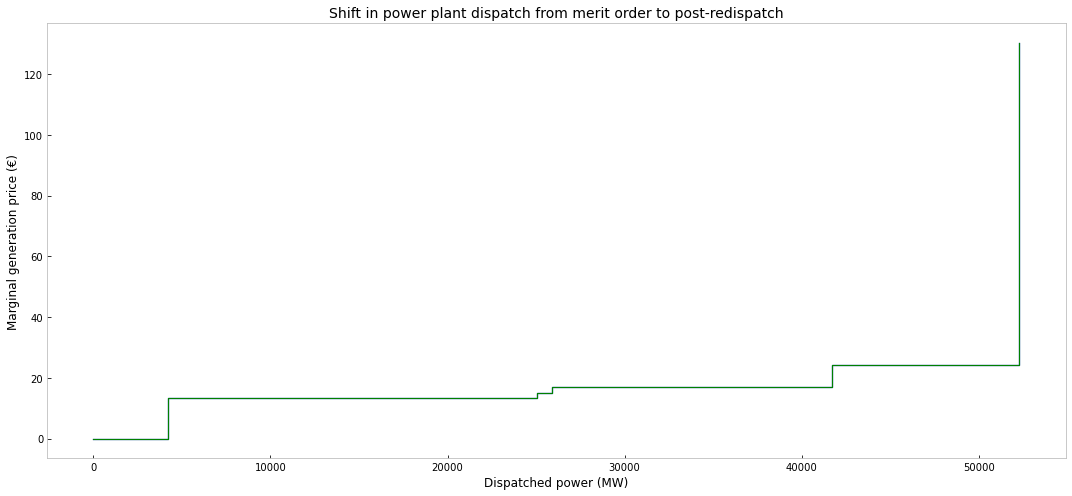

In [160]:
# merit order test pypsa-eur network

n200_eur = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_200_ec_lcopt_1H-noex.nc")
df = n200_eur.generators_t.p.copy()

# Generate Merit order per day
df_200_gen = network_d.generators.copy()
dict_prices = df_200_gen.groupby(["carrier"]).mean()["marginal_cost"].round(4).to_dict()
dict_prices["offwind"] = dict_prices.pop("offwind-ac")
dict_prices.pop("offwind-dc")
for key in dict_prices:
    if dict_prices[key] == 0:
        dict_prices.update({key: 0.01})
pprint(dict_prices)

cols_CCGT = [column for column in list(df) if "CCGT" in column]
cols_OCGT = [column for column in list(df) if "OCGT" in column]
cols_oil = [column for column in list(df) if "oil" in column]
cols_lignite = [column for column in list(df) if "lignite" in column]
cols_nuclear = [column for column in list(df) if "nuclear" in column]
cols_coal = [column for column in list(df) if "coal" in column]
cols_biomass = [column for column in list(df) if "biomass" in column]
cols_offwind = [column for column in list(df) if "offwind" in column]
cols_onwind = [column for column in list(df) if "onwind" in column]
cols_solar = [column for column in list(df) if "solar" in column]
cols_runofriver = [column for column in list(df) if "ror" in column]

df["OCGT"] = df[cols_OCGT].sum(axis = 1)
df["CCGT"] = df[cols_CCGT].sum(axis = 1)
df["oil"] = df[cols_oil].sum(axis = 1)
df["lignite"] = df[cols_lignite].sum(axis = 1)
df["nuclear"] = df[cols_nuclear].sum(axis = 1)
df["coal"] = df[cols_coal].sum(axis = 1)
df["biomass"] = df[cols_biomass].sum(axis = 1)
df["offwind"] = df[cols_offwind].sum(axis = 1)
df["onwind"] = df[cols_onwind].sum(axis = 1)
df["solar"] = df[cols_solar].sum(axis = 1)
df["ror"] = df[cols_runofriver].sum(axis = 1)
df_merit = df.loc[:,"OCGT":"ror"]

# Map Marginal prices and sort dataframe for merit order
df_merit = df_merit.T.round(4)
df_merit['Marginal price'] = df_merit.index.map(dict_prices)
df_merit = df_merit.sort_values(by = "Marginal price", axis = 0)
df_merit = df_merit.T
# Control sum
df_merit["sum"] = df_merit.sum(axis = 1)

s_merit = df_merit.iloc[-1,:]

def plot_merit_order(s_dispatch_p_t, s_merit, s_redispatch_p_t):
    '''
    Plots merit order curve as step function.
    -----
    Param:
    s_dispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_redispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_merit: series with marginal generator prices
    '''
    np_x = np.cumsum(s_dispatch_p_t.iloc[:-1].to_numpy())
    np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-1].to_numpy())
    np_y = s_merit.iloc[:-1].to_numpy()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    # Plot merit order of dispatch & redispatch
    ax.step(np_x, np_y, color = "blue", linewidth = 1.2)
    ax.step(np_x2, np_y, color = "green", linewidth = 1.2)
    
    ax.set_ylabel('Marginal generation price (€)',  fontsize = 12)
    ax.set_xlabel("Dispatched power (MW)", fontsize = 12)
    ax.set_title("Shift in power plant dispatch from merit order to post-redispatch",  fontsize = 14)
    ax.set_facecolor('white')
    ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()
    plt.show()
    

# Plot merit order shift for every of the 5 largest/smallest in cathegories:
# a) biggest redispatch cost saving
# b) biggest grid loads
# c) smallest grid loard



plot_merit_order(df_merit.iloc[50,:], s_merit, df_merit.iloc[50,:])

# Redispatch Workflow: Prepare network for 2025 and 2030

Freiheitsgrade für networks in 2025 und 2030:

1.	Demand side ? (additional load curves by kit)
2.	Nuclear fade out
3.	Start of coal and lignite fade out
4.	Wind power extensions
5.  Solar power extensions
6.  Biomass extension
7.	Natural Gas extension (Steigerung erdgas)
8.  Transmission line extensions (HVDC Links)
9.  Marginal generation prices change

In [41]:
# Create networks out of old network for 2030

n_200 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_200_ec_lcopt_1H-noex.nc")
n_200_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_200_ec_lcopt_1H-noex.nc")

display(n_200.generators.groupby("carrier")["p_nom"].sum())
display(n_200_optim.generators.groupby("carrier")["p_nom"].sum())
display(n_test13.generators.groupby("carrier")["p_nom"].sum())

#### TODO: CREATE SEPARATE SOLVE_REDISPATCH_NETWORK without set_parameters_from_optimized
#### ("solve_redispatch_network_future" oder so ähnlich)

def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.
    
    CHANGE IN FUNCTION: wind power allocation esp. in the north was VERY weird. Therefore: Setting p_nom of wind generators 
    to p_nom and NOT p_nom_opt
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
            np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
            n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)

    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False
    
    l_shedding = abs(n_optim.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(2).index.to_list()
    display(l_shedding)
    n.lines.loc[l_shedding,"s_max_pu"] = 0.80
    n.lines.loc[l_shedding,"num_parallel"] = 1

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    if not n.links.empty:
        links_dc_i = n.links.index[n.links.carrier == 'DC']
        n.links.loc[links_dc_i, 'p_nom'] = \
            n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
        n.links.loc[links_dc_i, 'p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False    
    # Overwrite renewables with un-optimized capacities to approximate real life better
    gen_onwind = n.generators.index[n.generators.carrier == "onwind"]
    gen_offwind = n.generators.index[(n.generators.carrier == "offwind-ac")|(n.generators.carrier == "offwind-ac")]
    gen_solar = n.generators.index[n.generators.carrier == "solar"]
    #Overwrite onwind power values with p_nom * 0.2
    n.generators.loc[gen_onwind, 'p_nom'] = n_optim.generators['p_nom'].reindex(gen_onwind, fill_value=0.) * 1 + 0.01
    # Overwrite offwind power values with p_nom_max * 0.1
    n.generators.loc[gen_offwind, 'p_nom'] = \
        n_optim.generators['p_nom_max'].reindex(gen_offwind, fill_value=0.) * 0.2 + 0.01
    # Overwrite solar power values with p_nom * 0.1
    n.generators.loc[gen_solar, 'p_nom'] = \
        n_optim.generators['p_nom'].reindex(gen_solar, fill_value=0.) * 0.9 + 0.01
        
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n

# Methodology: Iteratively remove rows until desired capacity reached
def remove_generator_until_capacity_reached(network, network_optim, cap_goal, carrier):
    """
    Heuristik:
    Function that removes the LEAST USED generators of a carrier until desired 
    capacity is reached (with 5% inaccuracy margin). This is done by ranking the generators by their mean utilization (loading)
    from the optimized input network.
    Param:
    cap_goal: Desired installed generator capacity
    """
    gen_names = network.generators[network.generators["carrier"] == carrier].index.tolist()
    s_gen_p_nom = network.generators[network.generators["carrier"] == carrier].p_nom

    df_gen_t = network_optim.generators_t.p[gen_names].append(s_gen_p_nom)
    s_utilization = (df_gen_t/df_gen_t.iloc[-1]).iloc[:-1].mean(axis=0)
    l_gen_remove = []

    df_gen = network.generators[network.generators["carrier"] == carrier]
    df_gen["utilization"] = s_utilization
    df_gen = df_gen.sort_values(by=["utilization"])
    for gen, next_gen in zip(df_gen.index, df_gen.index[1:]):
        # if sum of remaing generators fulfils desired capacity, remove current generator
        if df_gen["p_nom"].loc[next_gen:].sum() > cap_goal:
            l_gen_remove.append(gen)
    network.mremove("Generator", l_gen_remove)
    # display(network.generators[network.generators["carrier"] == carrier])
    return network

n_200 = set_parameters_from_optimized(n_200, n_200_optim)

INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


carrier
CCGT          18120.910000
OCGT           8044.269704
biomass         839.020000
coal          28069.379795
lignite       20833.500000
nuclear       15788.438693
offwind-ac       16.100000
offwind-dc        0.000000
oil            3696.400000
onwind        19897.836987
ror            2907.579410
solar         31443.798921
Name: p_nom, dtype: float64

carrier
CCGT          1.812091e+04
OCGT          8.044270e+03
biomass       8.390200e+02
coal          2.806938e+04
lignite       2.083350e+04
load          2.000000e+11
nuclear       1.578844e+04
offwind-ac    1.610000e+01
offwind-dc    0.000000e+00
oil           3.696400e+03
onwind        1.989784e+04
ror           2.907579e+03
solar         3.144380e+04
Name: p_nom, dtype: float64

carrier
CCGT          1.812091e+04
OCGT          8.044270e+03
biomass       8.390200e+02
coal          2.806938e+04
lignite       2.083350e+04
load          2.000000e+11
nuclear       1.578844e+04
offwind-ac    1.610000e+01
offwind-dc    0.000000e+00
oil           3.696400e+03
onwind        1.989784e+04
ror           2.907579e+03
solar         3.144380e+04
Name: p_nom, dtype: float64

['150', '49']

In [25]:
display(network.generators[n_200.generators["carrier"] == "onwind"]["p_nom"].sum())


11940.632192199999

In [7]:
# Create future networks
n_2025 = n_200.copy()
n_2030 = n_200.copy()

# Ad 1. DEMAND SIDE
# ----------------

# Determine total yearly load in TWH
load_2018 = n_200.loads_t.p_set.sum(axis=1).sum()

# Aus NDP:

# Nettostromverbrauch in Szenario 2025 B:
load_2025B = 528400000
ratio2025 = load_2025B / load_2018
display(ratio2025)

# Nettostromverbrauch in Szenario 2030 B:
load_2030B = 543900000
ratio2030 = load_2030B / load_2018
display(ratio2030)

# Scale load curves accordingly
# Proportional scaling: Why is this ok? It increases the loads at every point in time by x%. This is ok because it implicitely
# accounts for demo/geographic change (cities getting bigger, loads grow faster & larger than loads in villages)


n_2025.loads_t.p_set = n_200.loads_t.p_set.copy() * ratio2025
n_2030.loads_t.p_set = n_200.loads_t.p_set.copy() * ratio2030




1.0208905593667124

1.0508371976524504

In [24]:
n_2030.generators.groupby("carrier").sum()

p_nom_max        weight         p_nom  capital_cost  \
carrier                                                              
CCGT                 inf      0.000000  24378.048965  0.000000e+00   
OCGT                 inf      0.000000  10821.951035  0.000000e+00   
biomass              inf      0.000000    839.020000  0.000000e+00   
coal                 inf      0.000000  11096.237328  0.000000e+00   
lignite              inf      0.000000  12121.000000  0.000000e+00   
offwind-ac  2.250560e+04   8396.251642   4501.209077  1.838779e+06   
offwind-dc  6.718060e+04  32355.226944      0.001297  9.240328e+05   
oil                  inf      0.000000   3696.400000  0.000000e+00   
onwind      4.460423e+05  82284.135389  11940.632192  2.109404e+07   
ror                  inf   2907.579410   2907.579410  3.061630e+07   
solar       3.604510e+05  41225.495493  12579.449569  1.062737e+07   

            p_nom_extendable  marginal_cost  efficiency  p_nom_opt  p_nom_min  \
carrier                                                                         
CCGT                       0    2360.000000      25.000        0.0        0.0   
OCGT                       0    4378.846154      29.250        0.0        0.0   
biomass                    0     463.675214      14.508        0.0        0.0   
coal                       0     361.551724       6.960        0.0        0.0   
lignite                    0      40.463087       1.341        0.0        0.0   
offwind-ac                 0       0.135000       9.000        0.0        0.0   
offwind-dc                 0       0.060000       4.000        0.0        0.0   
oil                        0    2995.208651       9.039        0.0        0.0   
onwind                     0       2.895000     193.000        0.0        0.0   
ror                        0       0.000000     101.700        0.0        0.0   
solar                      0       1.930000     193.000        0.0        0.0   

            p_min_pu  p_max_pu  p_set  q_set   sign  committable  \
carrier                                                            
CCGT             0.0      50.0    0.0    0.0   50.0            0   
OCGT             0.0      75.0    0.0    0.0   75.0            0   
biomass          0.0      31.0    0.0    0.0   31.0            0   
coal             0.0      15.0    0.0    0.0   15.0            0   
lignite          0.0       3.0    0.0    0.0    3.0            0   
offwind-ac       0.0       9.0    0.0    0.0    9.0            0   
offwind-dc       0.0       4.0    0.0    0.0    4.0            0   
oil              0.0      23.0    0.0    0.0   23.0            0   
onwind           0.0     193.0    0.0    0.0  193.0            0   
ror              0.0     113.0    0.0    0.0  113.0            0   
solar            0.0     193.0    0.0    0.0  193.0            0   

            start_up_cost  shut_down_cost  min_up_time  min_down_time  \
carrier                                                                 
CCGT                  0.0             0.0            0              0   
OCGT                  0.0             0.0            0              0   
biomass               0.0             0.0            0              0   
coal                  0.0             0.0            0              0   
lignite               0.0             0.0            0              0   
offwind-ac            0.0             0.0            0              0   
offwind-dc            0.0             0.0            0              0   
oil                   0.0             0.0            0              0   
onwind                0.0             0.0            0              0   
ror                   0.0             0.0            0              0   
solar                 0.0             0.0            0              0   

            up_time_before  down_time_before  ramp_limit_up  ramp_limit_down  \
carrier                                                                        
CCGT                    50                 0           

In [95]:
# CHANGE GENERATION CAPACITY
# --------------------------

# total installed coal capacity according to NDP in 2017 and 2030:
# CONVENTIONAL CARRIERS
c_coal = 25000
c_coal2025 = 13500
c_coal2030 = 9800

c_lignite = 21200
c_lignite2025 = 
c_lignite2030 = 9300

c_gas = 29600
c_gas2030 = 35200

c_oil = 4400
c_oil2030 = 4100

# PHES
c_phs = 9500
c_phs2030 = 11600

# RENEWABLES
c_onwind = 50500
c_onwind2030 = 81500

c_offwind = 4300
c_offwind2030 = 17000

c_biomass = 7600
c_biomass2030 = 6000 




# Check real capacities in the grid
network = n_2030
# display(network.generators[n_2030.generators["carrier"] == "offwind-ac"]["p_nom"].sum())
# display(network.generators[n_2030.generators["carrier"] == "offwind-dc"]["p_nom"].sum())
# display(network.generators[n_2030.generators["carrier"] == "solar"]["p_nom"].sum())





# AD 2 NUCLEAR FADE OUT
# ---------------------

# remove nuclear generators from network
n_2030.mremove("Generator", n_2030.generators[n_2030.generators["carrier"] == "nuclear"].index)


# AD 3 START OF COAL AND LIGNITE FADE OUT
# --------------------------

# Adjust installed coal capacity to 2030
n_2030 = remove_generator_until_capacity_reached(n_2030, n_200_optim, c_coal2030, "coal")
# Adjust installed lignite capacity to 2030
n_2030 = remove_generator_until_capacity_reached(n_2030, n_200_optim, c_lignite2030, "lignite")

# AD 4 WIND POWER EXTENSION (onwind + offwind)
# --------------------------


# AD 5 SOLAR POWER EXTENSION
# --------------------------
c_biomass_from_network = n_2030.generators[network.generators["carrier"] == "biomass"].p_nom.sum()
display(c_biomass_from_network)
n_2030.generators.loc[network.generators["carrier"] == "biomass", "p_nom"] = \
    n_2030.generators.p_nom * c_biomass2030 / c_biomass


# AD 6 BIOMASS EXTENSION
# ----------------------
# Methodology: multiply p_nom capacities with the ratio between NDP 2017 and 2030. 
# This ratio better represents the new capacities, because the optimized pypsa-eur network has much lower biomass (830) than the NDP capacities

c_biomass_from_network = n_2030.generators[network.generators["carrier"] == "biomass"].p_nom.sum()
display(c_biomass_from_network)
n_2030.generators.loc[network.generators["carrier"] == "biomass", "p_nom"] = \
    n_2030.generators.p_nom * c_biomass2030 / c_biomass




# AD 7 NATURAL GAS EXTENSION
# --------------------------

# shift from oil generators to gas generators
# Method: Existing oil generators are being removed according to "remove_generator_until_capacity_reached" rule,
# existing gas generators are extended proportionally according to the ratio of ndp 2017 to ndp 2030

# Adjust installed oil capacity to 2030
n_2030 = remove_generator_until_capacity_reached(n_2030, n_200_optim, c_oil2030, "oil")

# Extend existing gas capacities
df_gen_gas = n_2030.generators[(n_2030.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT")]
c_gas_from_network = df_gen_gas.p_nom.sum()
n_2030.generators.loc[(n_2030.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT"), "p_nom"] = \
    n_2030.generators.p_nom * c_gas2030 / c_gas_from

# display(n_2030.generators.loc[(n_2030.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT")])


#### TODO: check whether total installed capacity represents the ratio between total capacity 2017 in NDP and total capacity 2030 in NDP


839.02

### Backup Code (Ältere Versionen)

In [ ]:
network_rd.links

In [ ]:
n_300 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300_200_ec_lcopt_1H-noex.nc")


In [ ]:
n_300.plot()
display(n_300.lines)
display(n_300.storage_units)
display(n_300.loads_t.p_set)
loads_df = n_300.loads_t.p_set.copy()
loads_df["sum"] = loads_df.sum(axis = 1)
display(loads_df)
display(n_300.generators_t.p_set)
linas = n_300.lines
linass = network_rd.lines
linas = linas.append(linas.sum(axis = 0), ignore_index=True)
linass = linass.append(linass.sum(axis = 0), ignore_index=True)
display(linas)
display(linass)

In [4]:
n_noex = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\\elec_s300_130_ec_lcopt_1H-noex.nc")


INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


In [8]:
# Load shedding validity check
df_gen_shed = n_noex.generators_t.p.copy()
df_gen_shed["load_shedding"] = df_gen_shed.loc[:,"DE0 0 load" : "DE0 99 load"].sum(axis = 1)
df_gen_shed["sum"] = df_gen_shed.iloc[:,:-1].sum(axis = 1)
df_gen_shed["load_shedding_share"] = df_gen_shed["load_shedding"] / df_gen_shed["sum"]

# DAILY load shedding average
df_gen_shed_day = df_gen_shed.iloc[:,:-2].groupby(np.arange(len(df_gen_shed.iloc[:,:-2]))//24).sum()
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_day = df_gen_shed_day.append(df_gen_shed_day.sum(axis = 0), ignore_index = True)
df_gen_shed_day["load_shedding"] = df_gen_shed_day.loc[:,"DE0 0 load" : "DE0 99 load"].sum(axis = 1)
df_gen_shed_day["sum"] = df_gen_shed_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_day["load_shedding_share"] = df_gen_shed_day["load_shedding"] / df_gen_shed_day["sum"]
print("Maximal relative load shedding per day: " + str(round(df_gen_shed_day["load_shedding_share"].iloc[:-1].max(), 4)))

display(df_gen_shed_day)

# Maximum load shedding:





Maximal relative load shedding per day: 0.3353


name  DE0 0 lignite  DE0 0 onwind      DE0 0 ror  DE0 0 solar  DE0 1 OCGT  \
0      1.047360e+05      0.006597     914.396425     0.000520    0.001840   
1      1.047360e+05      0.003103     914.396444     0.000039    0.001908   
2      1.047360e+05      0.009345     914.397297     0.000154    0.002091   
3      1.047360e+05      0.007474     914.397212     0.000418    0.002232   
4      1.047360e+05      0.006517     914.397073     0.000401    0.002278   
..              ...           ...            ...          ...         ...   
361    1.047360e+05      0.002345     540.808997     0.000020    0.002212   
362    1.047360e+05      0.003161     472.209584     0.000004    0.002006   
363    1.047360e+05      0.006714     417.082248     0.000201    0.001949   
364    1.047360e+05      0.000773     177.865397     0.000144    0.002159   
365    3.822864e+07      0.728119  177434.925770     0.463846    1.024002   

name  DE0 1 biomass    DE0 1 coal  DE0 1 onwind  DE0 1 solar    DE0 10 CCGT  \
0        297.589779  1.683190e+03      0.006508     0.000526       0.003180   
1        297.589741  2.911387e+03      0.003346     0.000296       0.003473   
2        297.592264  3.528473e+03      0.008930     0.000444       0.006336   
3        297.592115  2.845773e+03      0.004592     0.000008       0.005627   
4        297.591912  3.675036e+03      0.003398     0.000038       0.004849   
..              ...           ...           ...          ...            ...   
361      297.590156  3.494968e+03      0.000000     0.001038       0.002995   
362      297.589647  3.275185e+03      0.001670     0.000049       0.003069   
363      297.589471  2.374758e+03      0.002426     0.000094       0.003090   
364      297.589924  2.974903e+03      0.000151     0.000120       0.002934   
365   108620.980556  1.349084e+06      0.431064     0.471795  360283.206458   

name  DE0 10 OCGT   DE0 10 coal  DE0 10 oil  DE0 10 onwind  DE0 10 solar  \
0        0.002060  3.023681e+03    0.000610       0.007611      0.000715   
1        0.002192  1.368958e+04    0.000652       0.002023      0.000066   
2        0.003030  1.478469e+04    0.000717       0.011795      0.000193   
3        0.002867  1.858952e+04    0.000708       0.008816      0.000276   
4        0.002651  1.396102e+04    0.000695       0.007251      0.000212   
..            ...           ...         ...            ...           ...   
361      0.001979  6.874560e+02    0.000625       0.002335      0.000032   
362      0.002015  3.117871e+02    0.000621       0.003419      0.000031   
363      0.002014  3.970764e+03    0.000607       0.007220      0.000324   
364      0.001940  1.188558e+02    0.000612       0.001185      0.000042   
365   7421.509656  3.448497e+06    0.250879       0.933906      0.512070   

name  DE0 100 biomass  DE0 100 onwind  DE0 100 ror  DE0 100 solar  \
0          446.391551        0.008790     4.077458       0.000605   
1          446.391937        0.002054     4.077459       0.000214   
2          446.394555        0.012513     4.077981       0.000184   
3          446.394370        0.008034     4.077919       0.000132   
4          446.393886        0.008372     4.077814       0.000194   
..                ...             ...          ...            ...   
361        446.391548        0.002363     2.410501       0.000160   
362        446.391493        0.004426     2.104416       0.000027   
363        446.391554        0.008028     1.858457       0.000436   
364        446.391175        0.001919     0.790953       0.000018   
365     162933.459420        1.070369   790.865538       0.490245   

name  DE0 101 OCGT  DE0 101 coal  DE0 101 oil  DE0 101 onwind  DE0 101 ror  \
0         0.001900  2.583869e+03     0.000574        0.005277    18.236885   
1         0.001906  1.397231e+04     0.000562        0.004641    18.236818   
2         0.001995  1.418551e+04     0.000547        0.007505    18.237136   
3         0.002163  1.409524e+04     0.000574        0.005251    18.2371

In [59]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.
    
    CHANGE IN FUNCTION: wind power allocation esp. in the north was VERY weird. Therefore: Setting p_nom of wind generators 
    to p_nom and NOT p_nom_opt
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
            np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
            n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)
    
    l_shedding = abs(n_optim.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(3).index.to_list()

    display(l_shedding)
    
    n.lines.loc[l_shedding,"s_max_pu"] = 0.85
    n.lines.loc[l_shedding,"num_parallel"] = 1

    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    if not n.links.empty:
        links_dc_i = n.links.index[n.links.carrier == 'DC']
        n.links.loc[links_dc_i, 'p_nom'] = \
            n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
        n.links['p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    gen_onwind = n.generators.index[n.generators.carrier == "onwind"]
    gen_offwind = n.generators.index[(n.generators.carrier == "offwind-ac")|(n.generators.carrier == "offwind-ac")]
    gen_solar = n.generators.index[n.generators.carrier == "solar"]
    
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    # Overwrite onwind power values with p_nom * 0.2
    n.generators.loc[gen_onwind, 'p_nom'] = n_optim.generators['p_nom'].reindex(gen_onwind, fill_value=0.) * 1 + 0.01
    # Overwrite offwind power values with p_nom_max * 0.1
    n.generators.loc[gen_offwind, 'p_nom'] = \
        n_optim.generators['p_nom_max'].reindex(gen_offwind, fill_value=0.) * 0.2+ 0.01
    # Overwrite solar power values with p_nom * 0.08
    n.generators.loc[gen_solar, 'p_nom'] = \
        n_optim.generators['p_nom'].reindex(gen_solar, fill_value=0.) * 1 + 0.01
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False

    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n




ntwrk = set_parameters_from_optimized(ntwrk1, ntwrk1_)


display(ntwrk.lines.sort_values(by=["s_max_pu"]))

['150', '49', '47']

bus0     bus1  num_parallel     length                         type  \
name                                                                           
1       DE0 0   DE0 60       2.00000  36.572250  Al/St 240/40 4-bundle 380.0   
183   DE0 170  DE0 198       3.00000  29.072904  Al/St 240/40 4-bundle 380.0   
184   DE0 170   DE0 27       2.00000  27.041483  Al/St 240/40 4-bundle 380.0   
185   DE0 171    DE0 5       0.67036  41.714541  Al/St 240/40 4-bundle 380.0   
186   DE0 171   DE0 50       0.67036  70.286077  Al/St 240/40 4-bundle 380.0   
...       ...      ...           ...        ...                          ...   
98    DE0 130  DE0 148       2.00000  85.573902  Al/St 240/40 4-bundle 380.0   
287    DE0 91   DE0 94       2.00000  86.986619  Al/St 240/40 4-bundle 380.0   
47    DE0 113  DE0 143       1.00000  82.043870  Al/St 240/40 4-bundle 380.0   
150   DE0 154   DE0 48       1.00000  43.766042  Al/St 240/40 4-bundle 380.0   
49    DE0 113   DE0 57       1.00000  59.544068  Al/St 240/40 4-bundle 380.0   

      s_max_pu        s_nom  capital_cost    s_nom_min    x    r    g    b  \
name                                                                         
1         0.70  3396.205223   1389.879188  3396.205223  0.0  0.0  0.0  0.0   
183       0.70  5094.307835   1104.876613  5094.307835  0.0  0.0  0.0  0.0   
184       0.70  3396.205223   1027.675213  3396.205223  0.0  0.0  0.0  0.0   
185       0.70  1138.340255   1585.305065  1138.340255  0.0  0.0  0.0  0.0   
186       0.70  1138.340255   2671.127871  1138.340255  0.0  0.0  0.0  0.0   
...        ...          ...           ...          ...  ...  ...  ...  ...   
98        0.70  3396.205223   3252.121114  3396.205223  0.0  0.0  0.0  0.0   
287       0.70  3396.205223   3305.809516  3396.205223  0.0  0.0  0.0  0.0   
47        0.85  3396.205223   3117.966979  3396.205223  0.0  0.0  0.0  0.0   
150       0.85  1138.340255   1663.269598  1138.340255  0.0  0.0  0.0  0.0   
49        0.85  1138.340255   2262.892246  1138.340255  0.0  0.0  0.0  0.0   

      s_nom_extendable  s_nom_max  terrain_factor  v_ang_min  v_ang_max  \
name                                                                      
1                False        inf             1.0       -inf        inf   
183              False        inf             1.0       -inf        inf   
184              False        inf             1.0       -inf        inf   
185              False        inf             1.0       -inf        inf   
186              False        inf             1.0       -inf        inf   
...                ...        ...             ...        ...        ...   
98               False        inf             1.0       -inf        inf   
287              False        inf             1.0       -inf        inf   
47               False        inf             1.0       -inf        inf   
150              False        inf             1.0       -inf        inf   
49               False        inf             1.0       -inf        inf   

     sub_network  x_pu  r_pu  g_pu  b_pu  x_pu_eff  r_pu_eff  s_nom_opt  
name                                                                     
1                  0.0   0.0   0.0   0.0       0.0       0.0        0.0  
183                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
184                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
185                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
186                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
...          ...   ...   ...   ...   ...       ...       ...        ...  
98                 0.0   0.0   0.0   0.0       0.0       0.0        0.0  
287                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
47                 0.0   0.0   0.0   0.0       0.0       0.0        0.0  
150                0.0   0.0   0.0   0.0       0.0       0.0        0.0  
49                 0.0   0.0   0.0   0.0       0.0       0.0        0.0  

[287 rows x 26

In [96]:

# n_test8 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_08wind.nc")
# n_test9 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_09wind.nc")
# n_test10 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_07wind.nc")
# n_test11 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_04pv.nc")

# n_test12 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_10wind08pv.nc")
# n_test13 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_10wind09pv.nc")
n_test14 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_200_ec_lcopt_1H-noex_10wind07pv.nc")



INFO:pypsa.io:Imported network elec_s300_200_ec_lcopt_1H-noex_10wind07pv.nc has buses, carriers, generators, lines, loads, storage_units


In [109]:

print("0.80 cap 0.8onwind0.6sol0.2offwind8000")
print(n_test8.objective)
print("0.80 cap 0.9onwind0.6sol0.2offwind8000")
print(n_test9.objective)
print("0.80 cap 0.7onwind0.6sol0.2offwind8000")
print(n_test10.objective)
print("0.80 cap 0.6onwind0.4sol0.2offwind8000")
print(n_test11.objective)
print("0.80 cap 1onwind0.8sol0.2offwind8000")
print(n_test12.objective)
print("0.80 cap 1onwind0.9sol0.2offwind8000")
print(n_test13.objective)
print("0.80 cap 1onwind0.7sol0.2offwind8000")
print(n_test14.objective)




0.80 cap 0.8onwind0.6sol0.2offwind8000
352231742.0946276
0.80 cap 0.9onwind0.6sol0.2offwind8000
379580680.38306564
0.80 cap 0.7onwind0.6sol0.2offwind8000
327618017.0837581
0.80 cap 0.6onwind0.4sol0.2offwind8000
341558573.8340683
0.80 cap 1onwind0.8sol0.2offwind8000
380946237.4395254
0.80 cap 1onwind0.9sol0.2offwind8000
371922523.9570437
0.80 cap 1onwind0.7sol0.2offwind8000
393985981.8543725


In [ ]:
df_obj, df_obj_day, df_obj_week =  analyze_objective_rd(n_test13):
display(df_obj_day4)
print(df_obj_day4["delta_rd_cost_rel"].min())

# Plot
plot_objective_analysis(df_obj4, df_obj_day4, df_obj_week4)

In [27]:
n_base = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300.nc")

INFO:pypsa.io:Imported network elec_s300.nc has buses, carriers, generators, lines, links, loads, storage_units


In [30]:
n_base.generators[n_base.generators["carrier"] == "onwind"]["p_nom"].sum()

#n_200.generators.groupby("carrier").sum()

19897.836987000002

# ACTUAL RATIOS BETWEEN PYPSA CAPACITY AND REAL WORLD CAPACITY

In [68]:
n_base = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300.nc")
cap = n_base.generators.groupby("carrier")["p_nom"].sum()
display(cap)
ratio_wind = 50500 / cap.loc["onwind"]
ratio_pv = 43400 / cap.loc["solar"]
display(ratio_pv)

carrier
CCGT          18120.910000
OCGT           8044.269704
biomass         839.020000
coal          28069.379795
lignite       20833.500000
nuclear       15788.438693
offwind-ac       16.100000
offwind-dc        0.000000
oil            3696.400000
onwind        19897.836987
ror            2907.579410
solar         31443.798921
Name: p_nom, dtype: float64

1.3802403490956292

In [46]:
display(n_test11.generators.groupby("carrier")["p_nom"].sum())
display(n_test12.generators.groupby("carrier")["p_nom"].sum())

carrier
CCGT          5.436273e+04
OCGT          2.413281e+04
biomass       1.678040e+03
coal          5.613876e+04
lignite       6.250050e+04
load          1.600000e+07
nuclear       4.736532e+04
offwind-ac    9.002418e+03
offwind-dc    2.594960e-03
oil           1.108920e+04
onwind        2.388126e+04
ror           5.815159e+03
solar         2.515890e+04
Name: p_nom, dtype: float64

carrier
CCGT          5.436273e+04
OCGT          2.413281e+04
biomass       1.678040e+03
coal          5.613876e+04
lignite       6.250050e+04
load          1.600000e+07
nuclear       4.736532e+04
offwind-ac    9.002418e+03
offwind-dc    2.594960e-03
oil           1.108920e+04
onwind        3.979953e+04
ror           5.815159e+03
solar         5.031394e+04
Name: p_nom, dtype: float64

In [48]:
display(n_test12.lines.groupby("type")["s_nom"].sum())

type
Al/St 240/40 4-bundle 380.0    1.008640e+06
Name: s_nom, dtype: float64